In [1]:
%reload_ext autoreload
%autoreload 2
import jax.numpy as jnp
from jax import grad, jit, value_and_grad, make_jaxpr, config
from jax import random, profiler, config, debug, lax
from jax.nn import sigmoid
import numpy as np
import jax
import optax
import h5py

from larndsim.sim_jax import prepare_tracks, simulate_parametrized
from larndsim.softdtw_jax import SoftDTW
from larndsim.consts_jax import build_params_class, load_detector_properties
from numpy.lib import recfunctions as rfn
from larndsim.quenching_jax import quench
from larndsim.drifting_jax import drift
import matplotlib.pyplot as plt

import matplotlib
import matplotlib.cm as cm
from tqdm import tqdm
from larndsim.sim_jax import simulate_signals_parametrized, simulate_drift, pad_size
from larndsim.detsim_jax import id2pixel, get_pixel_coordinates, current_mc, accumulate_signals_parametrized
from larndsim.fee_jax import get_adc_values, digitize
matplotlib.rcParams.update({'font.size': 14})

# jax.config.update('jax_platform_name', 'cpu')

%config InlineBackend.figure_format='retina'

In [2]:
import sys
!{sys.executable} -m pip install -e .

OSError: "/bin/zsh" shell not found

In [2]:
from optimize.dataio import pad_sequence

# to_propagate = ('Ab', 'kb', 'long_diff', 'tran_diff', 'eField', 'lifetime')#, 'shift_x', 'shift_y', 'shift_z')
to_propagate = ('shift_x', 'shift_y', 'shift_z')
#Running some fit
Params = build_params_class(to_propagate)
ref_params = load_detector_properties(Params, "./src/larndsim/detector_properties/module0.yaml",
                                "./src/larndsim/pixel_layouts/multi_tile_layout-2.4.16_v4.yaml")
ref_params = ref_params.replace(Ab=0.8, kb=0.0486, tran_diff=4.0e-6, long_diff=8.8e-6, number_pix_neighbors=0, signal_length=100, electron_sampling_resolution=5e-3, eField=0.5, lifetime=3e3, time_padding=190)
ref_params = ref_params.replace(time_window=ref_params.signal_length)
# ref_params = ref_params.replace(RESET_NOISE_CHARGE=0., UNCORRELATED_NOISE_CHARGE=0., lifetime=1e10, long_diff=0., tran_diff=0.)
# ref_params = ref_params.replace(RESET_NOISE_CHARGE=0.)
# ref_params = ref_params.replace(UNCORRELATED_NOISE_CHARGE=0.)

tracks_files = [
    './prepared_data/input_1.h5',
    './prepared_data/input_2.h5',
    './prepared_data/input_3.h5',
    './prepared_data/input_4.h5'
]
tracks = None
for tracks_file in tracks_files:
    tracks_loc, fields, _ = prepare_tracks(ref_params, tracks_file, False)
    if tracks is None:
        tracks = tracks_loc
    else:
        tracks = jnp.concatenate([tracks, tracks_loc])




In [157]:
wfs_filtered.shape

(1092, 2001)

In [3]:
from larndsim.consts_jax import load_lut
from optimize.simulate import load_events_as_batch
from larndsim.sim_jax import simulate_signals_new, simulate_drift_new, get_renumbering
Params = build_params_class([])
ref_params = load_detector_properties(Params,
                                      "src/larndsim/detector_properties/module0.yaml",
                                      'src/larndsim/pixel_layouts/multi_tile_layout-2.4.16_v4.yaml')

master_key = jax.random.key(0)
rngkey1, rngkey2 = jax.random.split(master_key)

ref_params = ref_params.replace(
    signal_length=150,
    number_pix_neighbors=4,
    electron_sampling_resolution=0.005,
    mc_diff=True,
    # UNCORRELATED_NOISE_CHARGE=0.0,
)

response = load_lut("src/larndsim/detector_properties/response_44.npy")

# dataset, fields = load_events_as_batch("event122.h5", ref_params.electron_sampling_resolution, swap_xz=True)
# tracks = dataset[0]

main_pixels, pixels, nelectrons, t0_after_diff, currents_idx, pIDs_neigh, currents_idx_neigh, nelectrons_neigh, t0_neigh = simulate_drift_new(ref_params, tracks, fields)

################################################
################################################

#Sorting the pixels and getting the unique ones
unique_pixels = jnp.unique(main_pixels.ravel())
padded_size = pad_size(unique_pixels.shape[0], "unique_pixels")

unique_pixels = jnp.sort(jnp.pad(unique_pixels, (0, padded_size - unique_pixels.shape[0]), mode='constant', constant_values=-1))

mask, pix_renumbering_neigh = get_renumbering(pIDs_neigh, unique_pixels)
mask_indices = jnp.nonzero(mask)[0]
padded_size = pad_size(mask_indices.shape[0], "pix_renumbering")
mask_indices = jnp.pad(mask_indices, (0, padded_size - mask_indices.shape[0]), mode='constant', constant_values=-1)

###############################################
###############################################

wfs = simulate_signals_new(ref_params, unique_pixels, pixels, t0_after_diff, response, nelectrons, currents_idx, nelectrons_neigh, mask_indices, pix_renumbering_neigh, t0_neigh, currents_idx_neigh)

nsim = 10000

results = jnp.zeros((nsim, unique_pixels.shape[0], 10))
results_ticks = jnp.zeros((nsim, unique_pixels.shape[0], 10))

for i in tqdm(range(nsim)):
    _, rngkey2 = jax.random.split(rngkey2)

    integral, ticks = get_adc_values(ref_params, wfs[:, 1:], rngkey2)
    adcs = digitize(ref_params, integral)

    results = results.at[i].set(adcs)
    results_ticks = results_ticks.at[i].set(ticks)


TypeError: load_lut() missing 1 required positional argument: 'params'

In [4]:
pars_no_noise = ref_params.replace(RESET_NOISE_CHARGE=0., UNCORRELATED_NOISE_CHARGE=0.)

integral_nonoise, ticks_nonoise = get_adc_values(pars_no_noise, wfs[:, 1:], rngkey2)
adcs_nonoise = digitize(pars_no_noise, integral_nonoise)


In [6]:
from jax.scipy.special import erf
from jax.scipy.stats import norm as normpdf
from jax import debug
from functools import partial

@partial(jit, static_argnames=['Nvalues_scaling'])
def get_adc_values_average_noise(params, pixels_signals, Nvalues_scaling):
    q = pixels_signals*params.t_sampling
    q_sum = q.cumsum(axis=-1)  # Cumulative sum over time ticks

    Npix = pixels_signals.shape[0]
    Nvalues = Nvalues_scaling*Npix

    def find_hit(carry, it):
        q_sum_loc, previous_prob, pixid = carry # q_sum_loc[Nvalues, Nticks] ; previous_prob[Nvalues] ; pixid[Nvalues]
        sigma = params.RESET_NOISE_CHARGE #Found out that only considering the reset noise was sufficient
        # sigma = jnp.sqrt(params.RESET_NOISE_CHARGE**2 + params.UNCORRELATED_NOISE_CHARGE**2)
        eps = 1e-10

        _, Nticks = q_sum_loc.shape

        erf_term = erf((q_sum_loc - params.DISCRIMINATION_THRESHOLD)/(jnp.sqrt(2)*sigma)) # erf_term[Nvalues, Nticks]
        erf_term_signal = jnp.frompyfunc(jnp.maximum, 2, 1).accumulate(erf_term, axis=-1) #erf is increasing so should be faster to make the re-ordering afterwards

        max_future_signal = jnp.frompyfunc(jnp.maximum, 2, 1).accumulate(q_sum_loc[:, ::-1], axis=-1)[:, ::-1]
        
        guess = 0.5*(erf_term_signal[..., 1:] - erf_term_signal[..., :-1]) # guess[Nvalues, Nticks - 1]
        # guess = jnp.clip(guess, 0, 1)  # Ensure guess is between 0 and 1, should not be needed but erf got odd behavior for some reason

        interval = round((3 * params.CLOCK_CYCLE + params.ADC_HOLD_DELAY * params.CLOCK_CYCLE) / params.t_sampling)
        shifted_ticks = jnp.arange(Nticks - 1) + interval + 1 # shifted_ticks[Nticks - 1]
        shifted_ticks = jnp.clip(shifted_ticks, 0, Nticks - 1)

        prob_event = jnp.clip(0.5*(erf_term[..., shifted_ticks] - erf_term[..., :-1]), 0, guess)

        esperance_value = q_sum_loc[..., shifted_ticks] + params.DISCRIMINATION_THRESHOLD - 0.5*(q_sum_loc[..., 1:] + q_sum_loc[..., :-1]) # esperance_value[Nvalues, Nticks - 1]

        norm = jnp.clip(jnp.sum(prob_event, axis=-1) + eps, 0, 1)  # Adding a small epsilon to avoid division by zero ; norm[Nvalues]

        previous_prob_norm = jnp.full(Npix, eps, dtype=jnp.float32)  # Avoid division by zero
        previous_prob_norm = previous_prob_norm.at[pixid].add(previous_prob)

        no_hit_prob_across = jnp.ones(Npix, dtype=jnp.float32)  # Initialize no-hit probability across universes
        no_hit_prob_across = no_hit_prob_across.at[pixid].subtract(norm*previous_prob)  # No-hit probability across universes

        prob_distrib = prob_event*previous_prob[:, None] # prob_distrib[Nvalues, Nticks - 1]

        prob_distrib_across = jnp.zeros((Npix, Nticks - 1), dtype=jnp.float32)  # Initialize probability distribution across universes
        prob_distrib_across = prob_distrib_across.at[pixid].add(prob_distrib)  # prob_distrib_across[Npix, Nticks - 1]

        norm_across = jnp.sum(prob_distrib_across, axis=-1)  # Normalize across universes ; norm_across[Npix]

        tick_avg = jnp.sum(prob_distrib_across/(norm_across[:, None])*jnp.arange(Nticks - 1), axis=-1)  # + 0.5

        charge_avg = jnp.sum(prob_event*esperance_value, axis=-1) # charge_avg[Nvalues] ; average charge for each path

        charge_avg_across = jnp.zeros((Npix,), dtype=jnp.float32)  # Initialize average charge across universes
        charge_avg_across = charge_avg_across.at[pixid].add(charge_avg*previous_prob)/norm_across  # charge_avg_across[Npix]

        future_hit_earliest_end = jnp.clip(shifted_ticks + interval + 1, 0, Nticks - 1) #We shift again
        future_hit_prob = 0.5*(1 + erf((max_future_signal[:, future_hit_earliest_end] - q_sum_loc[:, jnp.clip(shifted_ticks + 1, 0, Nticks - 1)] - params.DISCRIMINATION_THRESHOLD)/(jnp.sqrt(2)*sigma)))
        # debug.print("prob_distrib*future_hit_prob: {a}", a=prob_distrib*future_hit_prob)
        best_paths = jnp.argsort(prob_distrib*future_hit_prob, axis=None, descending=True)[:Nvalues] # best_paths[Nvalues]
        best_path_universe = best_paths // (Nticks - 1)
        best_path_ticks = best_paths % (Nticks - 1)
        best_path_pixid = pixid[best_path_universe]  # best_path_pixid[Nvalues]

        best_path_next_ticks = jnp.clip(shifted_ticks + 1, 0, Nticks - 1) # best_path_next_ticks[Nticks - 1]
        best_path_esperance = q_sum_loc[best_path_universe, best_path_next_ticks[best_path_ticks]]  # best_path_esperance[Nvalues]
        best_path_wfs = q_sum_loc[best_path_universe, :]
        q_sum_new = best_path_wfs - best_path_esperance[..., None]
        # q_sum_new = jnp.clip(q_sum_new, 0, None)  # Ensure no negative values
        new_prob = prob_distrib[best_path_universe, best_path_ticks] # new_prob[Nvalues]
        return (q_sum_new, new_prob, best_path_pixid), (charge_avg_across, tick_avg, no_hit_prob_across)
    
    q_sum_multi = jnp.zeros((Nvalues, q_sum.shape[1]), dtype=jnp.float32)  # Initialize q_sum for multiple universes
    q_sum_multi = q_sum_multi.at[:q_sum.shape[0], :].set(q_sum)
    # debug.print("q_sum_multi: {a}", a=q_sum_multi)
    previous_prob = jnp.zeros(Nvalues, dtype=jnp.float32)  # Initialize previous probability
    previous_prob = previous_prob.at[:q_sum.shape[0]].set(1.0)  # Set the first universe probability to 1.0
    pixid = jnp.full((Nvalues,), -1, dtype=jnp.int32)  # Initialize pixel IDs for multiple universes
    pixid = pixid.at[:q_sum.shape[0]].set(jnp.arange(q_sum.shape[0]))  # Set pixel IDs for the first universe

    init_loop = (q_sum_multi, previous_prob, pixid)  # Initialize previous_prob
    # init_loop = (q_sum_multi[1080:1081], previous_prob[1080:1081])  # Initialize previous_prob
    # _, (charge_avg, tick_avg, no_hit_prob, guess) = lax.scan(find_hit, init_loop, jnp.arange(0, params.MAX_ADC_VALUES))

    # _, (charge_avg, tick_avg, no_hit_prob, guess) = lax.scan(find_hit, init_loop, jnp.arange(0, 1))
    # _, (charge_avg, tick_avg, no_hit_prob, leftover) = lax.scan(find_hit, init_loop, jnp.arange(0, params.MAX_ADC_VALUES))
    _, (charge_avg, tick_avg, no_hit_prob) = lax.scan(find_hit, init_loop, jnp.arange(0, 5))
    # carry, (charge_avg, tick_avg, no_hit_prob, guess) = find_hit(init_loop, 0)
    # carry, (charge_avg, tick_avg, no_hit_prob, guess) = find_hit(carry, 1)
    # carry, (charge_avg, tick_avg, no_hit_prob, guess) = find_hit(carry, 2)
    # carry, (charge_avg, tick_avg, no_hit_prob, guess) = find_hit(carry, 3)

    return (charge_avg, tick_avg, no_hit_prob)
#Activate jax NAN check
jax.config.update("jax_debug_nans", False)
mask = (np.sum(results_ticks < 1998, axis=(0, 2)) > 0) & (np.sum(results > digitize(ref_params, ref_params.DISCRIMINATION_THRESHOLD), axis=(0, 2)) > 0) & (unique_pixels >= 0)
# mask = mask & (jnp.arange(mask.shape[0])%10 == 0)
adcs_filtered = results[:, mask, :]
adcs_filtered_nonoise = adcs_nonoise[mask, :]
wfs_filtered = wfs[mask, :]
ticks_filtered = results_ticks[:, mask, :]
ticks_nonoise_filtered = ticks_nonoise[mask, :]

In [27]:
charge_avg, tick_avg, no_hit_prob = get_adc_values_average_noise(ref_params, wfs_filtered[:, 1:], 20)

prob_distrib*future_hit_prob: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
prob_distrib*future_hit_prob: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
prob_distrib*future_hit_prob: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
prob_distrib*future_hit_prob: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
prob_distrib*future_hit_prob: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [47]:
sigma = ref_params.RESET_NOISE_CHARGE
roi_threshold = 100


Npix = wfs_filtered.shape[0]
Nticks = wfs_filtered.shape[1] - 1

roi_start = jnp.argmax(wfs_filtered[:, 1:] > roi_threshold, axis=1)
roi_end = wfs_filtered.shape[1] - jnp.argmax(wfs_filtered[:, :1:-1] > roi_threshold, axis=1)

with_roi = roi_start > 0

largest_roi = jnp.max((roi_end-roi_start)[with_roi])

wfs_with_roi = wfs_filtered[:, 1:].at[jnp.arange(Npix)[:, None], (jnp.arange(largest_roi) + roi_start[:, None])].get(unique_indices=True)

(array([  1.,   0.,   1.,   0.,   0.,   3.,   4.,   4.,   2.,   5.,  32.,
        125., 402., 311.,  83.,  32.,  19.,  13.,   7.,  22.,   4.,   6.,
          2.,   2.,   1.,   1.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          1.]),
 array([ 50.  ,  59.04,  68.08,  77.12,  86.16,  95.2 , 104.24, 113.28,
        122.32, 131.36, 140.4 , 149.44, 158.48, 167.52, 176.56, 185.6 ,
        194.64, 203.68, 212.72, 221.76, 230.8 , 239.84, 248.88, 257.92,
        266.96, 276.  , 285.04, 294.08, 303.12, 312.16, 321.2 , 330.24,
        339.28, 348.32, 357.36

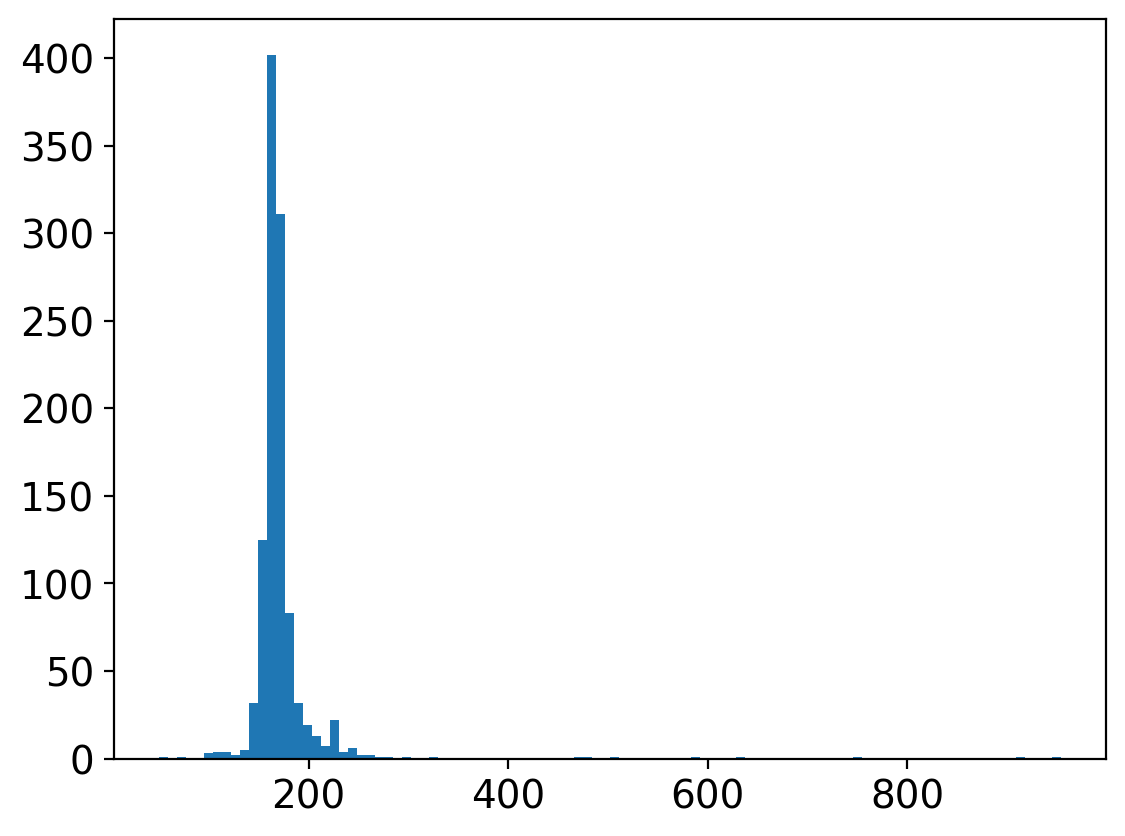

In [48]:
plt.hist((roi_end-roi_start)[with_roi], bins=100)

In [15]:
A = jnp.array([
    [0, 1, 2],
    [3, 4, 5],
    [6, 7, 8]
])

B = jnp.zeros_like(A)

A[jnp.arange(3)[:, None], jnp.arange(3)[None, :]]

Array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]], dtype=int32)

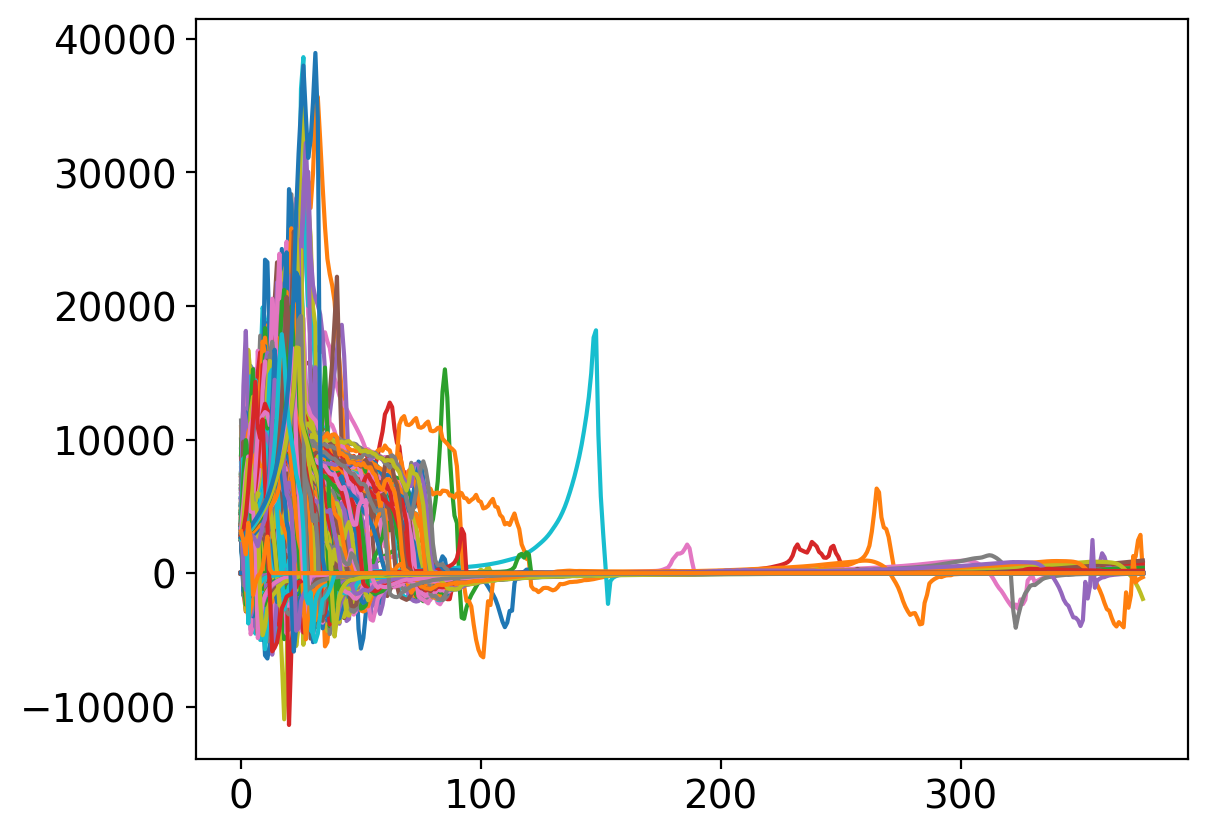

In [22]:
plt.plot(wfs_with_roi.T);

In [72]:
wfs_with_roi

Array([[   0.4571656,    4.3480372,    5.2228765, ...,    0.       ,
           0.       ,    0.       ],
       [   0.       ,    0.       ,    0.       , ...,    0.       ,
           0.       ,    0.       ],
       [   0.       ,    0.       ,    0.       , ...,    0.       ,
           0.       ,    0.       ],
       ...,
       [   0.       ,    0.       ,    0.       , ..., -103.1666   ,
         -94.44685  ,  -87.00529  ],
       [   0.       ,    0.       ,    0.       , ...,    0.       ,
           0.       ,    0.       ],
       [   0.       ,    0.       ,    0.       , ...,    0.       ,
           0.       ,    0.       ]], dtype=float32)

/lscratch/pgranger/tmp/ipykernel_3387338/1709241411.py:52: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


[778.46576 802.996   820.6985        nan       nan]
[1.7881393e-07 5.4575539e-05 9.6752393e-01 1.0000000e+00 1.0000000e+00]
Guess no-hit probability: 0.96752393
Measured no-hit probability: 0.9723
Measured avg adc: 84.5158
Guess avg adc: 151.80534
Guess time tick: 820.6985
Measured time tick: 820.49097


(700.0, 900.0)

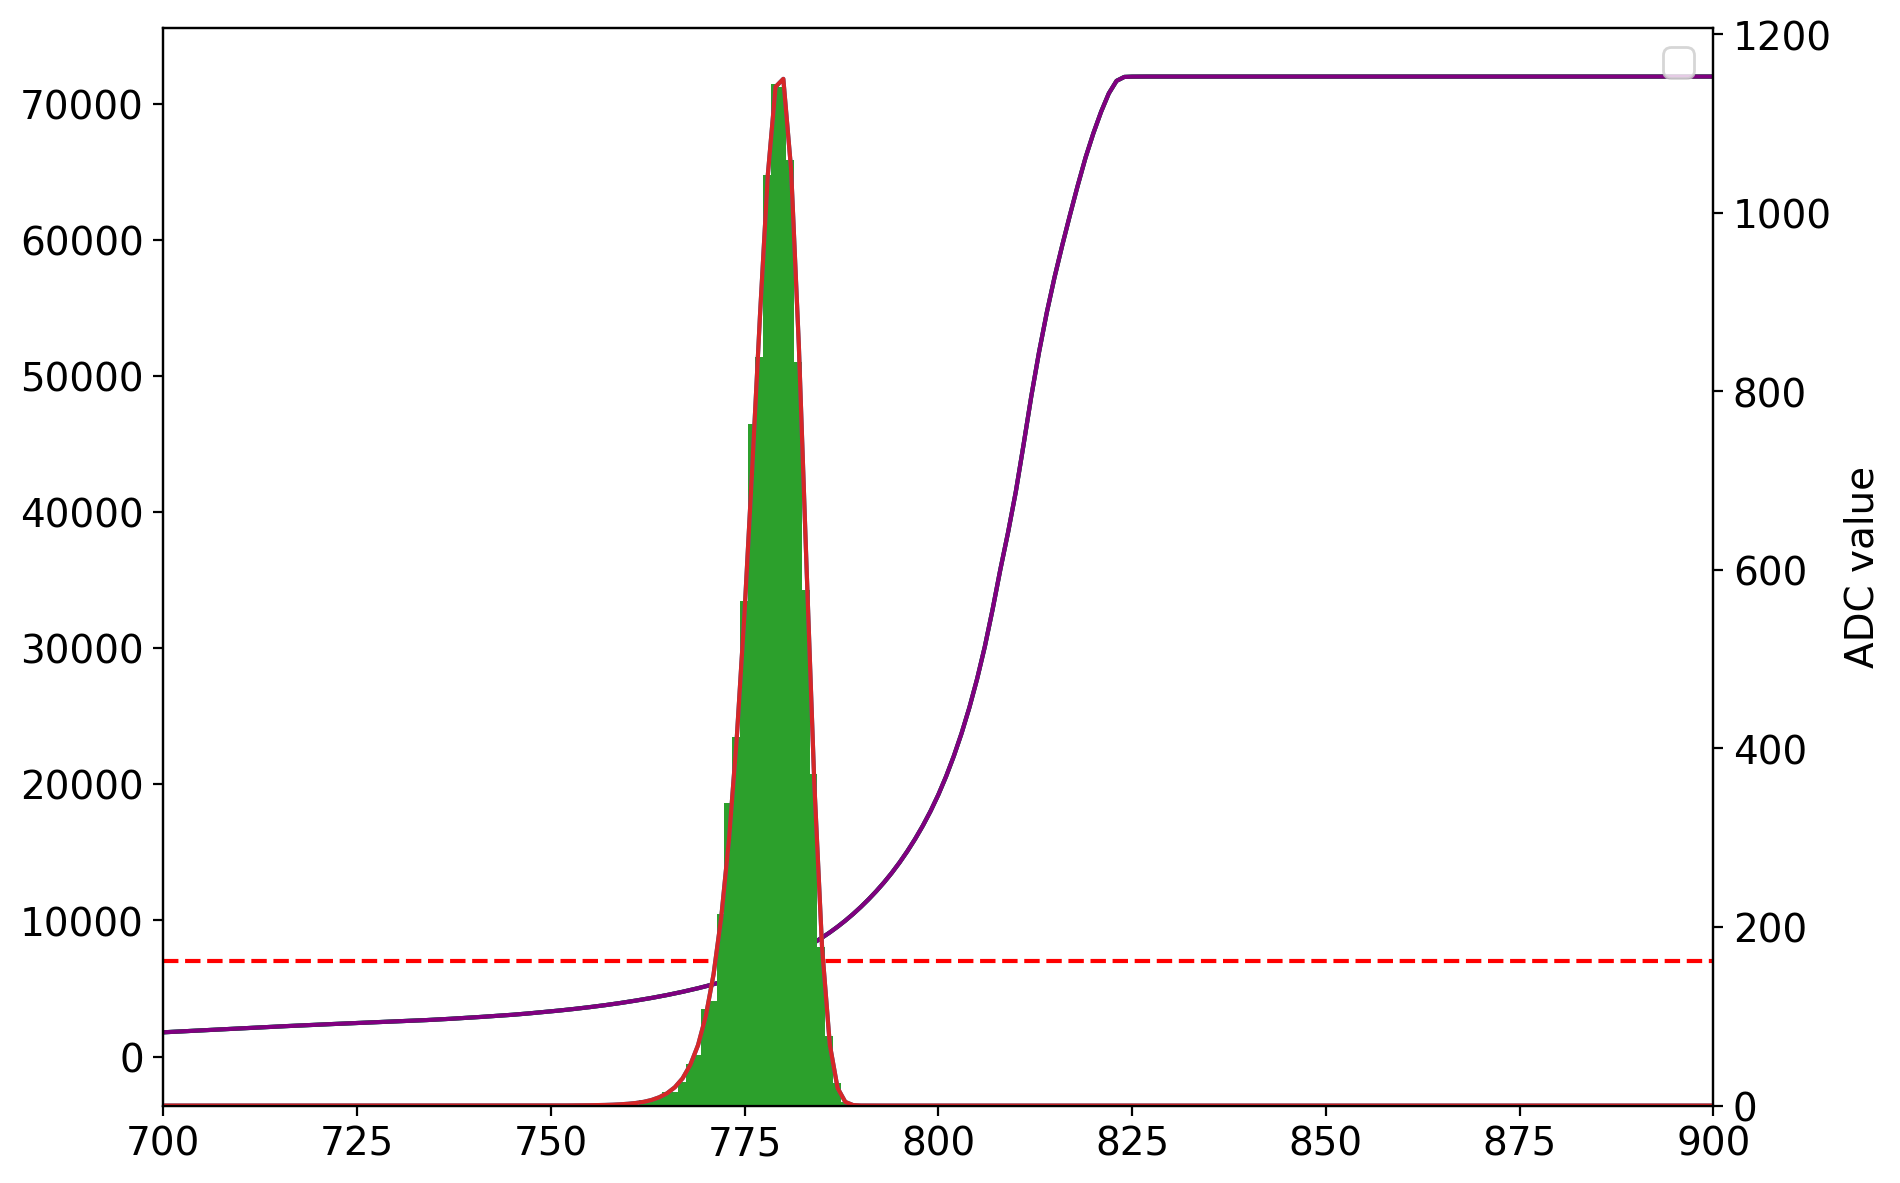

In [67]:
# iplot = 81 #1018 81 289
iplot = 11 #1018 81 289
hitidx = 2

params = ref_params

plt.figure(figsize=(10, 7))
# q_sum = (wfs_filtered[:, 1:]*ref_params.t_sampling).cumsum(axis=-1)
plt.plot(q_sum[iplot], label='Waveform')
signal = jnp.frompyfunc(jnp.maximum, 2, 1, identity=0).accumulate(q_sum, axis=-1)
plt.plot(signal[iplot], label='Signal', color='green')
plt.axhline(ref_params.DISCRIMINATION_THRESHOLD, color='r', linestyle='--', label='Discrimination threshold')
# plt.plot(average_measured_adc[:, 0], label='Average measured ADC', color='blue')
_, Nticks = q_sum.shape
  
erf_term = erf((q_sum[iplot] - params.DISCRIMINATION_THRESHOLD)/(jnp.sqrt(2)*sigma)) # erf_term[Nvalues, Nticks]
erf_term_signal = jnp.frompyfunc(jnp.maximum, 2, 1).accumulate(erf_term, axis=-1) #erf is increasing so should be faster to make the re-ordering afterwards
max_future_signal = jnp.frompyfunc(jnp.maximum, 2, 1).accumulate(q_sum[iplot, ::-1], axis=-1)[::-1]

guess = 0.5*(erf_term_signal[1:] - erf_term_signal[:-1]) # guess[Nvalues, Nticks - 1]
prob_event = jnp.clip(0.5*(erf_term[shifted_ticks] - erf_term[:-1]), 0, guess)



sigma = ref_params.RESET_NOISE_CHARGE  # Found out that only considering the reset noise was sufficient
interval = round((3 * ref_params.CLOCK_CYCLE + ref_params.ADC_HOLD_DELAY * ref_params.CLOCK_CYCLE) / ref_params.t_sampling)
shifted_ticks = jnp.arange(q_sum.shape[1] - 1) + interval + 1
shifted_ticks = jnp.clip(shifted_ticks, 0, q_sum.shape[1] - 1)
esperance_value = q_sum[iplot, shifted_ticks] #+ sigma*0.5*(1 + erf((q_sum[iplot, :] - ref_params.DISCRIMINATION_THRESHOLD)/(jnp.sqrt(2)*sigma)))/(1 + erf(-(ref_params.DISCRIMINATION_THRESHOLD - q_sum[iplot, :])/(jnp.sqrt(2)*sigma)) + 1e-5)
esperance_value = q_sum[:, shifted_ticks] + sigma*(normpdf.pdf(q_sum[:, :-1], loc=ref_params.DISCRIMINATION_THRESHOLD, scale=sigma) - normpdf.pdf(q_sum[:, 1:], loc=ref_params.DISCRIMINATION_THRESHOLD, scale=sigma))/(erf((signal[:, 1:] - ref_params.DISCRIMINATION_THRESHOLD)/(jnp.sqrt(2)*sigma)) - erf((signal[:, :-1] - ref_params.DISCRIMINATION_THRESHOLD)/(jnp.sqrt(2)*sigma)) + 1e-5)

plt.plot(q_sum[iplot], label='Esperance value', color='purple')

ax2 = plt.gca().twinx()

ax2.plot(prob_event*10000)


future_hit_earliest_end = jnp.clip(shifted_ticks + interval + 1, 0, Nticks - 1) #We shift again
future_hit_prob = 0.5*(1 + erf((max_future_signal[future_hit_earliest_end] - q_sum[iplot, jnp.clip(shifted_ticks + 1, 0, Nticks - 1)] - params.DISCRIMINATION_THRESHOLD)/(jnp.sqrt(2)*sigma)))
# ax2.plot(future_hit_prob*0.1)
# prob_charge_pass = jnp.clip((1 + erf(-(ref_params.DISCRIMINATION_THRESHOLD - q_sum[iplot, shifted_ticks])/(jnp.sqrt(2)*sigma))) / (1 + erf(-(ref_params.DISCRIMINATION_THRESHOLD - q_sum[iplot, :])/(jnp.sqrt(2)*sigma)) + 1e-5), 0, 1)

# ax2.plot(guess[0, iplot, :]*prob_charge_pass[1:], label='Guess', color='purple' )
# ax2.plot(guess[0, iplot, :], label='Guess', color='orange' )
# ax2.plot(guess[0, iplot, :].cumsum(), label='Guess', color='red' )

plt.xlabel('Time tick')
plt.ylabel('ADC value')
# plt.xlim(680, 820)
# plt.xlim(0, 90)
plt.legend()
print(tick_avg[:, iplot])
print(no_hit_prob[:, iplot])
# plt.axvline(tick_avg[0, iplot], color='orange', linestyle='--', label='Guess tick')
# plt.axvline(average_measured[iplot, hitidx], color='blue', linestyle='--', label='Measured tick')
sigma = ref_params.RESET_NOISE_CHARGE  # Found out that only considering the reset noise was sufficient
# norm = 0.5*(erf((q_sum[iplot, -1] - ref_params.DISCRIMINATION_THRESHOLD)/(jnp.sqrt(2)*sigma)) - erf((q_sum[iplot, :1] - ref_params.DISCRIMINATION_THRESHOLD)/(jnp.sqrt(2)*sigma)))
# guess_plot = 0.5*(erf((signal[1:] - ref_params.DISCRIMINATION_THRESHOLD)/(jnp.sqrt(2)*sigma)) - erf((signal[:-1] - ref_params.DISCRIMINATION_THRESHOLD)/(jnp.sqrt(2)*sigma)))
# guess_plot = 0.5*(erf((signal[iplot, 1:] - ref_params.DISCRIMINATION_THRESHOLD)/(jnp.sqrt(2)*sigma)) - erf((signal[iplot, :-1] - ref_params.DISCRIMINATION_THRESHOLD)/(jnp.sqrt(2)*sigma)))



print("Guess no-hit probability:", no_hit_prob[hitidx, iplot])
print("Measured no-hit probability:", measured_no_hit_prob[iplot, hitidx])
# plt.plot(guess_plot, label='Guess (plot)', color='purple')
print("Measured avg adc:", average_measured_adc[iplot, hitidx])
print("Guess avg adc:", adc_avg[hitidx, iplot])
print("Guess time tick:", tick_avg[hitidx, iplot])
print("Measured time tick:", average_measured[iplot, hitidx])

retriggered = ticks_filtered[:, iplot, 0]
retriggered = retriggered[ticks_filtered[:, iplot, 1] < 1998]

plt.hist(ticks_filtered[:, iplot, 0], bins=np.linspace(0, 2000, 2000))
plt.hist(retriggered, bins=np.linspace(0, 2000, 2000))
plt.plot(prob_event*future_hit_prob*10000)

# shifted_ticks2 = jnp.clip(shifted_ticks + 1, 0, q_sum_loc.shape[1] - 1)

plt.xlim(700, 900)
# plt.plot(shifted_ticks, prob_charge_pass, label='Probability of charge passing', color='purple')
# print((prob_charge_pass[..., :-1]*guess[0, iplot, :]).sum())


In [26]:
%timeit get_adc_values_average_noise(ref_params, wfs_filtered[:, 1:,], 200)

5.57 s ± 27.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [27]:
# wfs_with_roi
%timeit get_adc_values_average_noise(ref_params, wfs_filtered[:, 1:,], 20)

669 ms ± 18.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [28]:
%timeit get_adc_values_average_noise(ref_params, wfs_with_roi, 20)

122 ms ± 6.89 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Text(15.472222222222216, 0.5, 'Number of times')

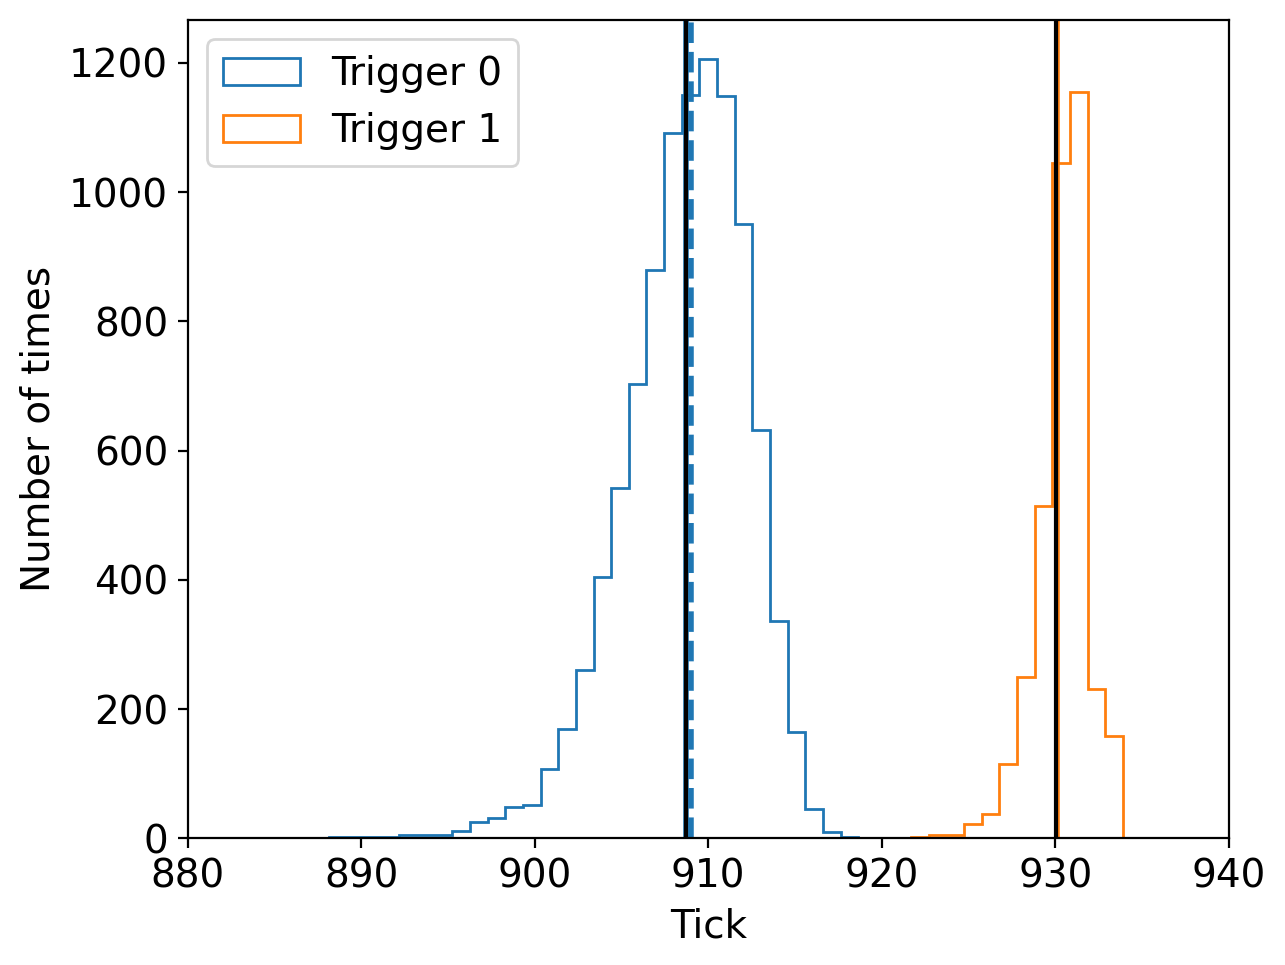

In [149]:
iplot = 524
lb = 880
hb = 940
bins = jnp.linspace(lb, hb, hb - lb)
for i in range(2):
    _, _, patches = plt.hist(ticks_filtered[:, iplot, i], bins=bins, histtype='step', label=f"Trigger {i}")
    color = patches[-1].get_ec()
    plt.axvline(ticks_nonoise_filtered[iplot, i], color=color, linewidth=2, linestyle='dashed')
    masked = ticks_filtered[:, iplot, i]
    masked = masked[masked < 1998]
    plt.axvline(jnp.nanmean(masked), color=color, linewidth=2)
    plt.axvline(tick_avg[i, iplot], color='k')
    
plt.xlim(lb, hb)
plt.legend()
plt.tight_layout()
plt.xlabel("Tick")
plt.ylabel("Number of times")

Text(15.472222222222216, 0.5, 'Number of times')

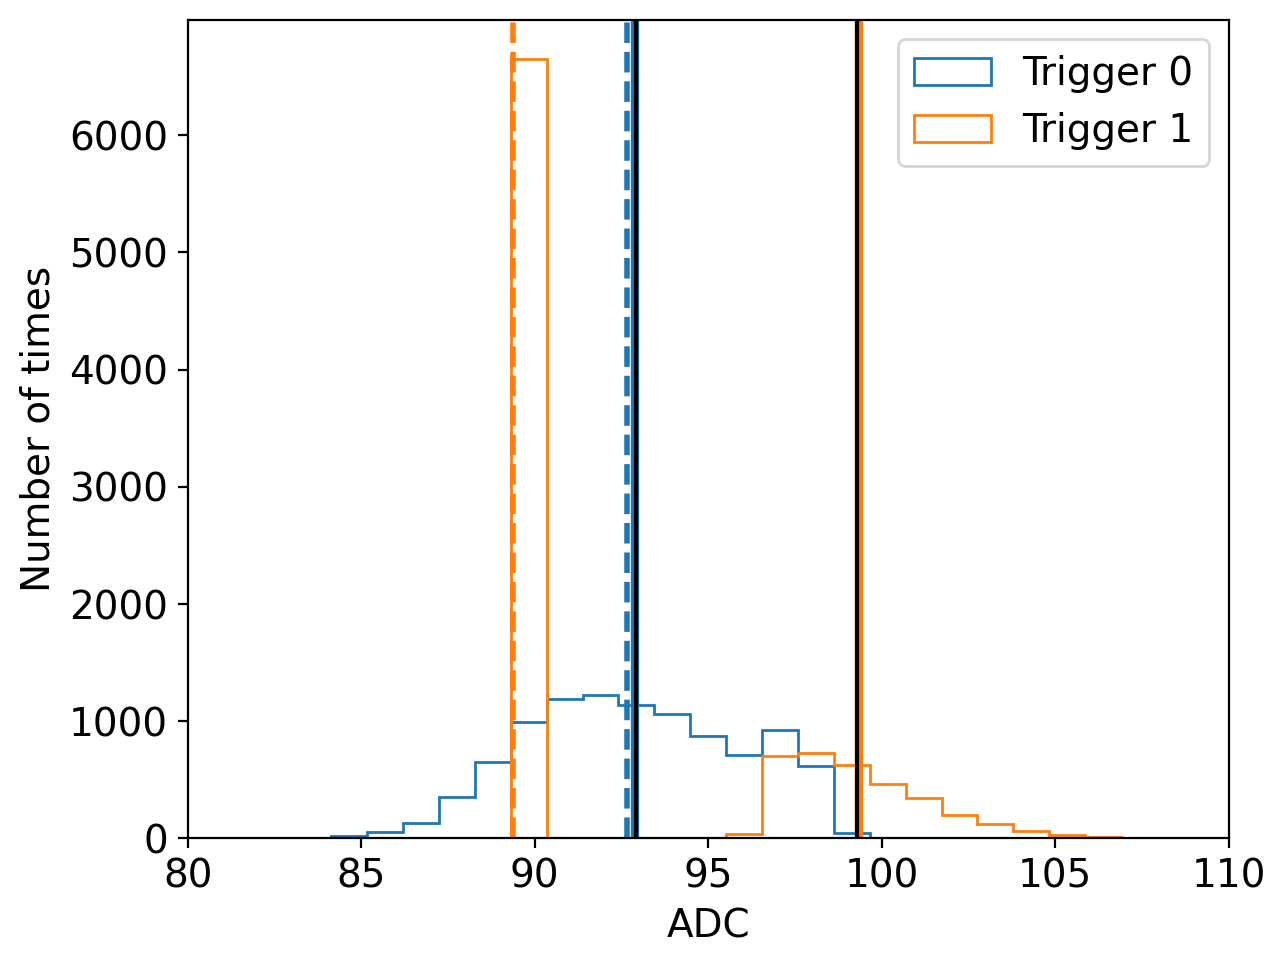

In [147]:
iplot = 524
lb = 80
hb = 110
bins = jnp.linspace(lb, hb, hb - lb)
for i in range(2):
    _, _, patches = plt.hist(adcs_filtered[:, iplot, i] + 15*i, bins=bins, histtype='step', label=f"Trigger {i}")
    color = patches[-1].get_ec()
    plt.axvline(adcs_filtered_nonoise[iplot, i] + 15*i, color=color, linewidth=2, linestyle='dashed')
    masked = adcs_filtered[:, iplot, i]
    masked = masked[masked > 80]
    plt.axvline(jnp.nanmean(masked) + 15*i, color=color, linewidth=3)
    plt.axvline(adc_avg[i, iplot] + 15*i, color='k')
    
plt.xlim(lb, hb)
plt.legend()
plt.tight_layout()
plt.xlabel("ADC")
plt.ylabel("Number of times")

[[1.1920929e-07 1.1920929e-07 1.1920929e-07 ... 0.0000000e+00
  0.0000000e+00 7.1289366e-01]
 [1.0000000e+00 8.7836802e-01 8.1572014e-01 ... 2.1699029e-01
  3.9532839e-05 1.0000000e+00]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  9.9999523e-01 1.0000000e+00]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 1.0000000e+00]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 1.0000000e+00]]
charge_avg shape: (5, 1092) tick_avg shape: (5, 1092) no_hit_prob shape: (5, 1092)


Text(0, 0.5, 'No-hit probability difference')

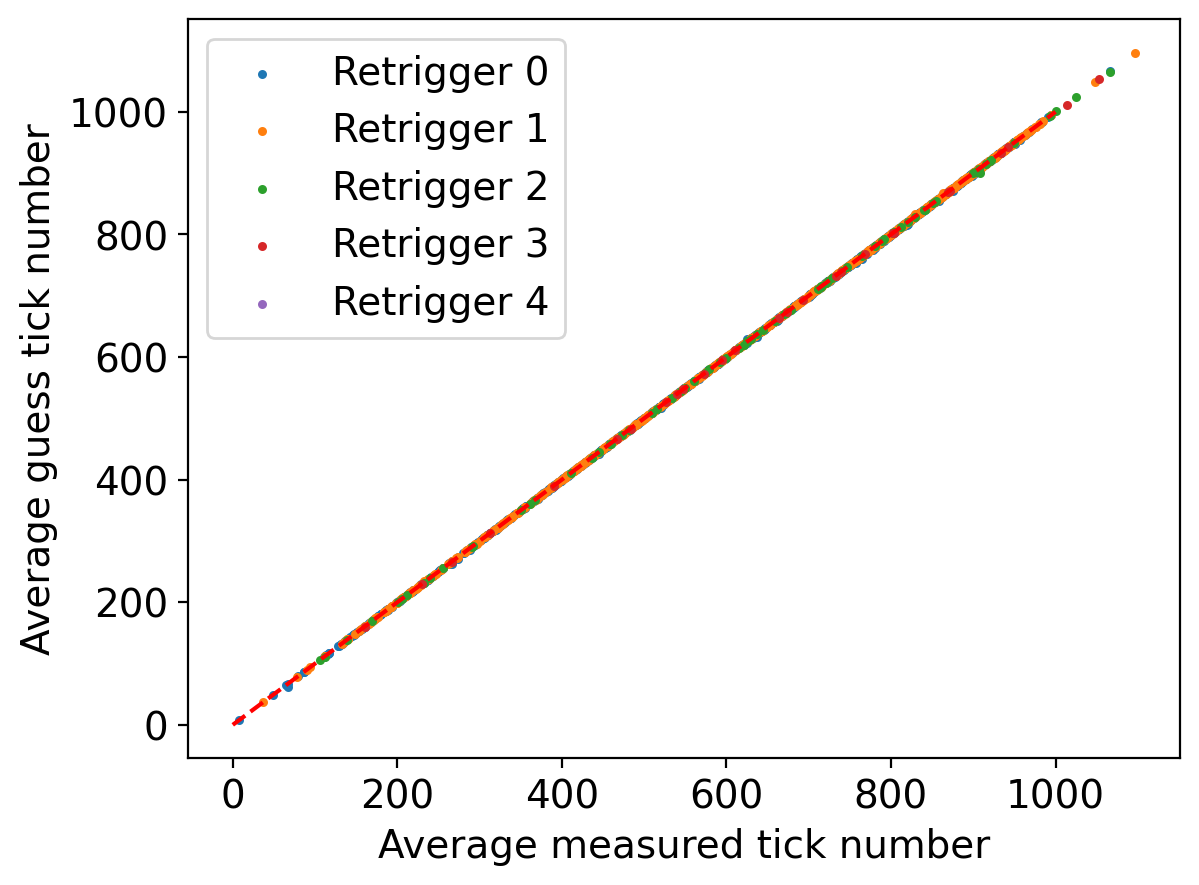

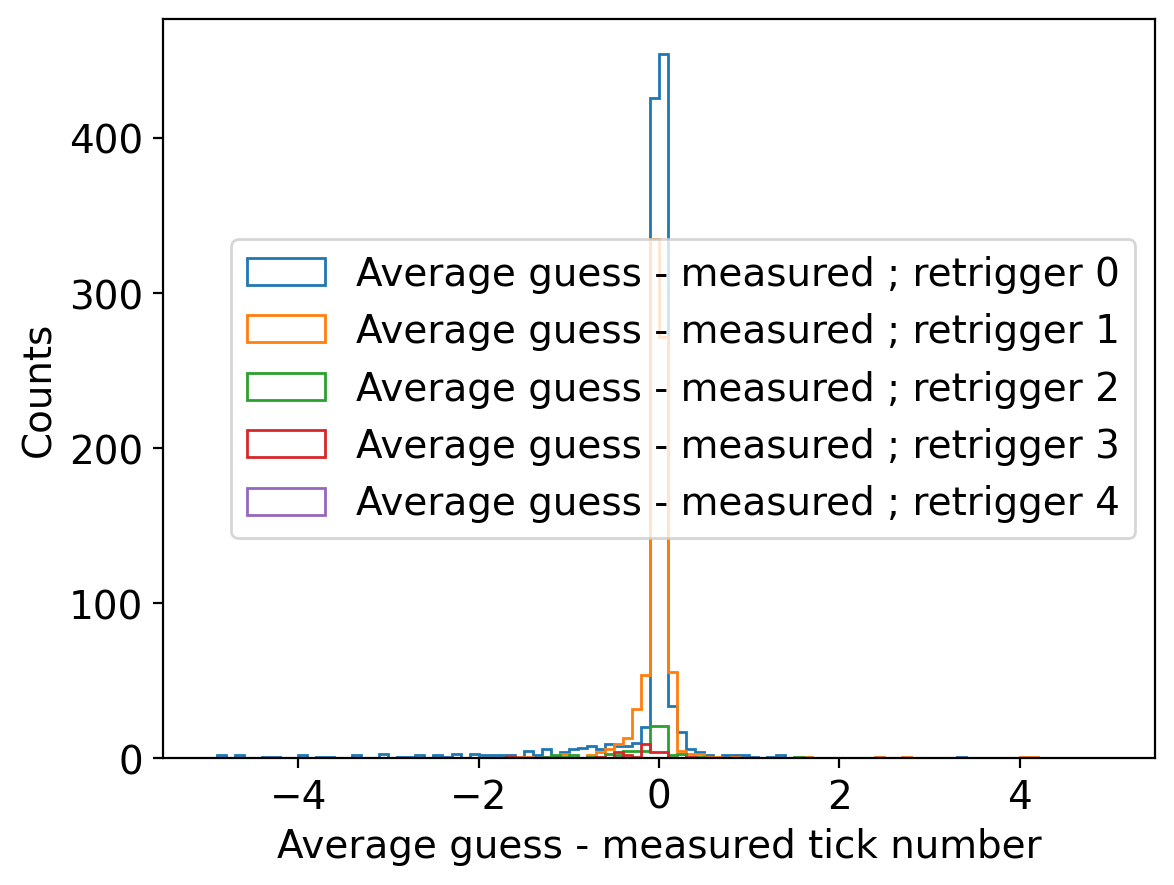

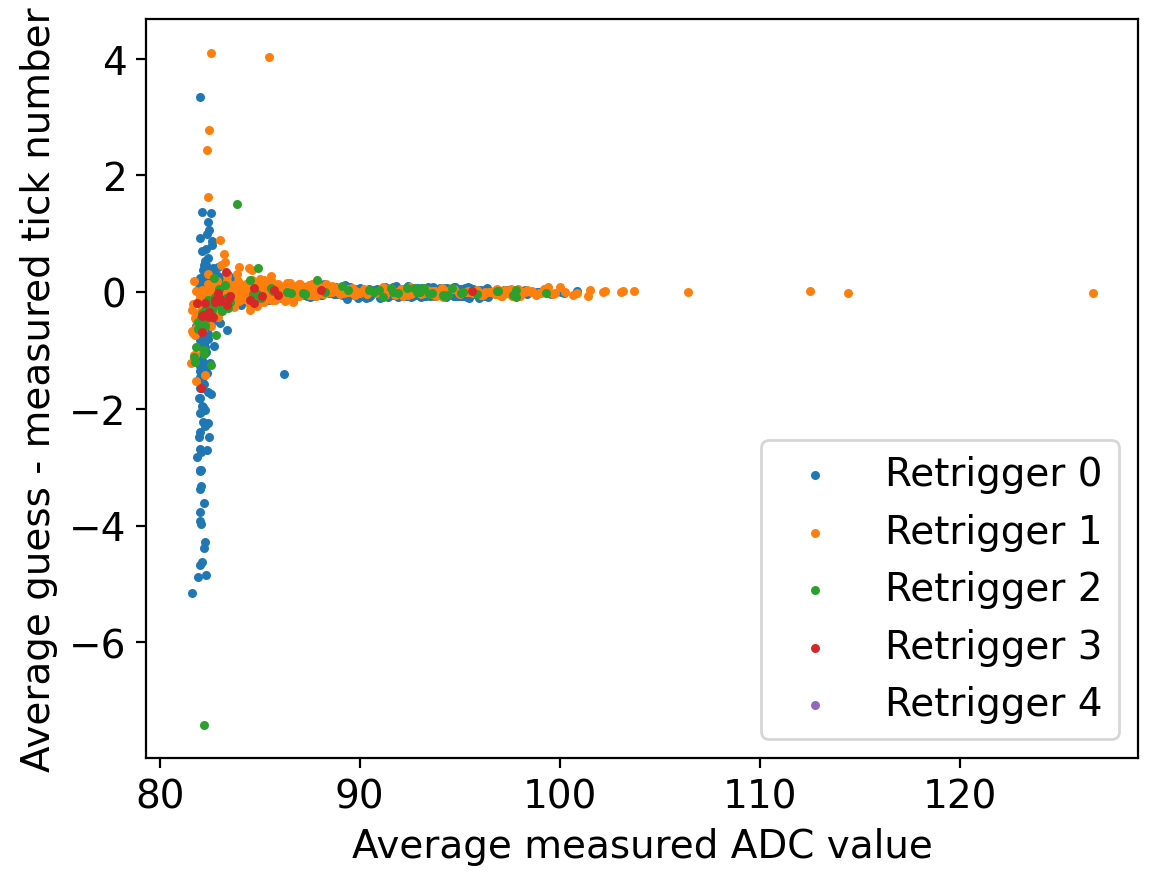

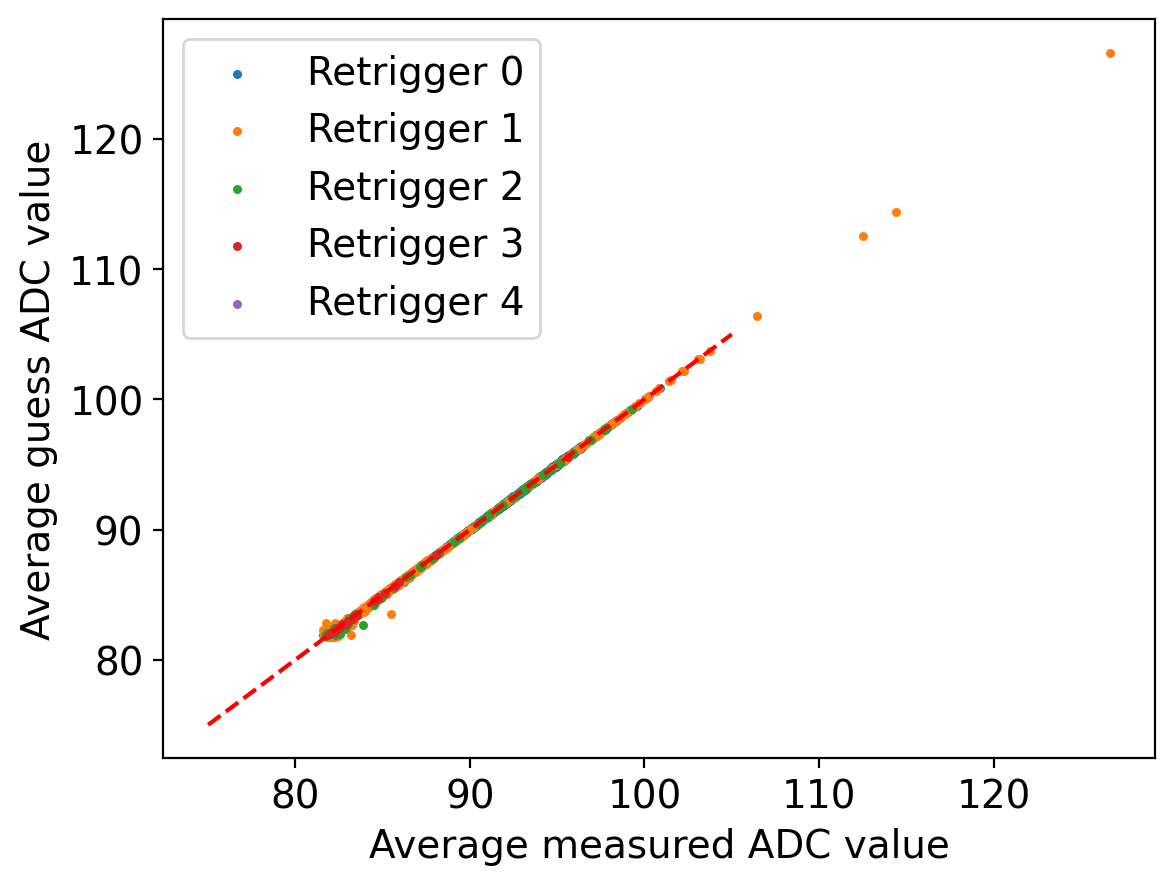

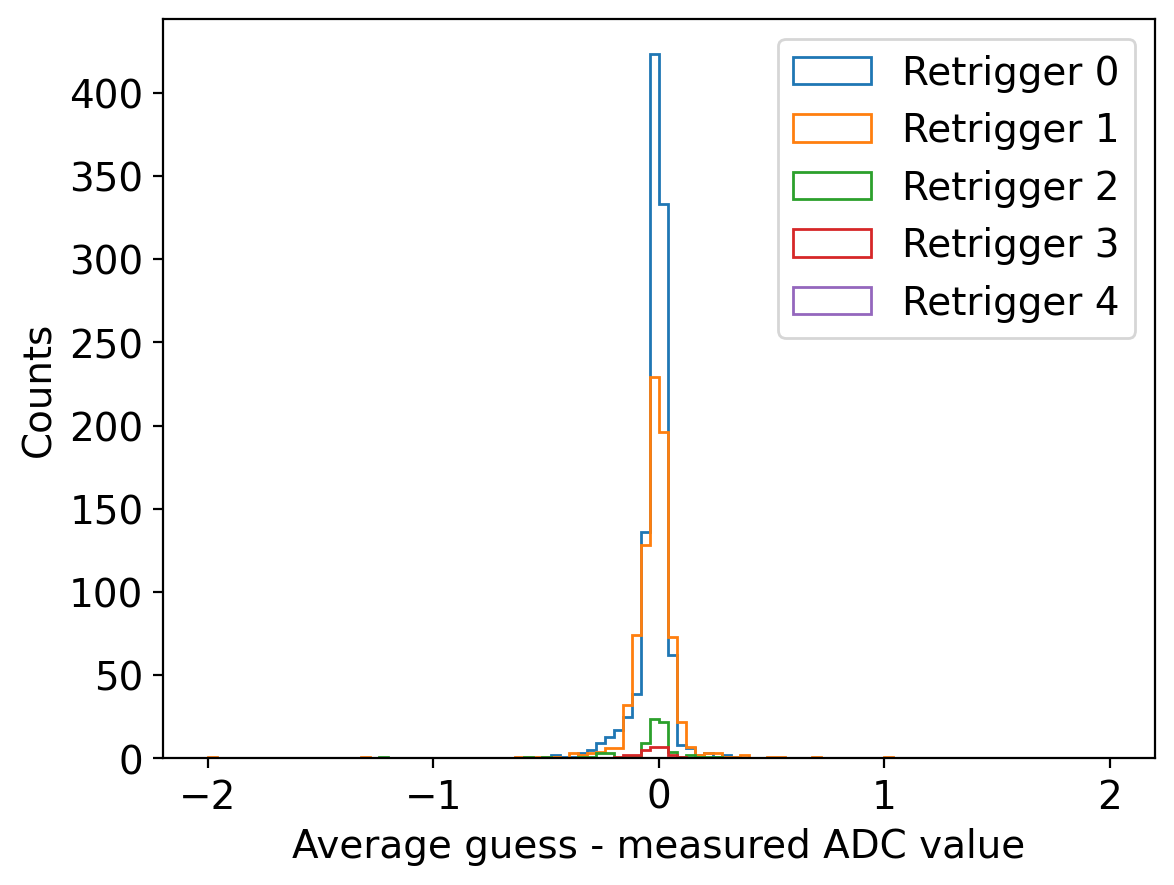

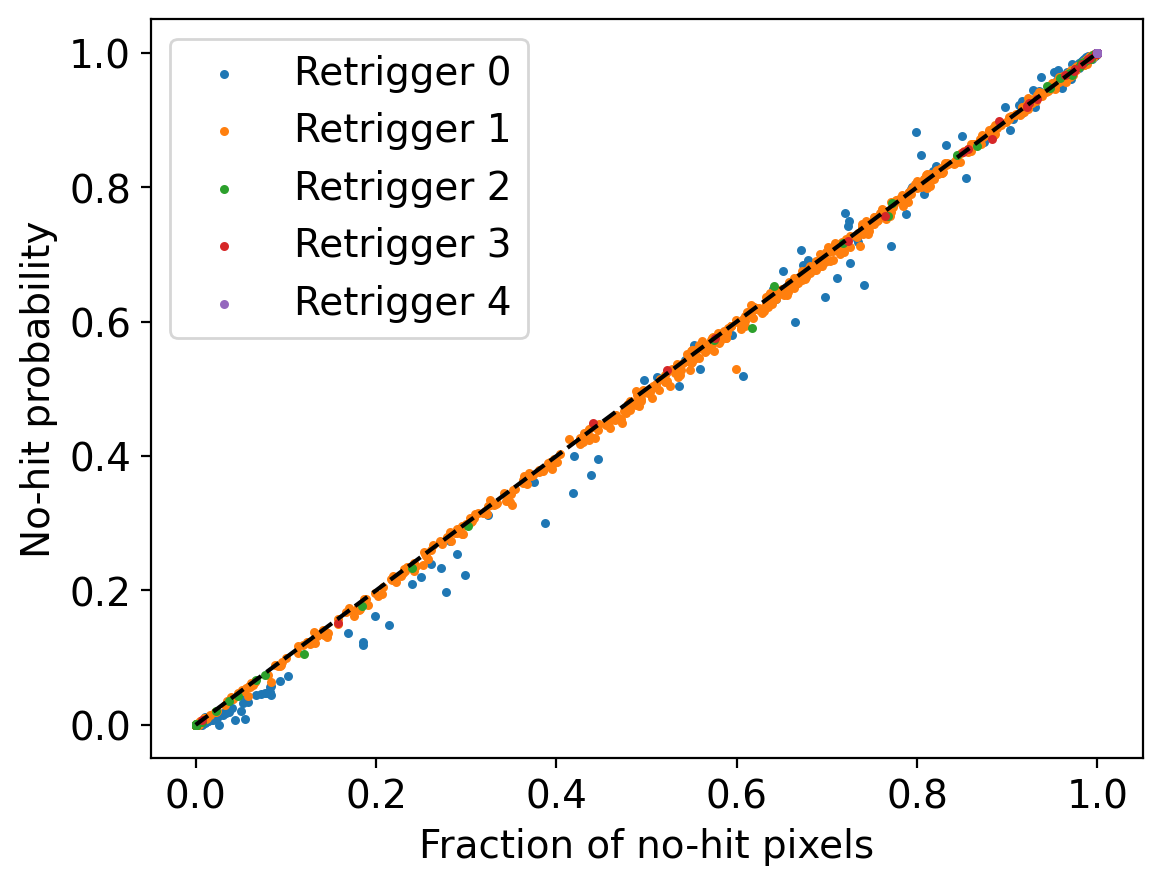

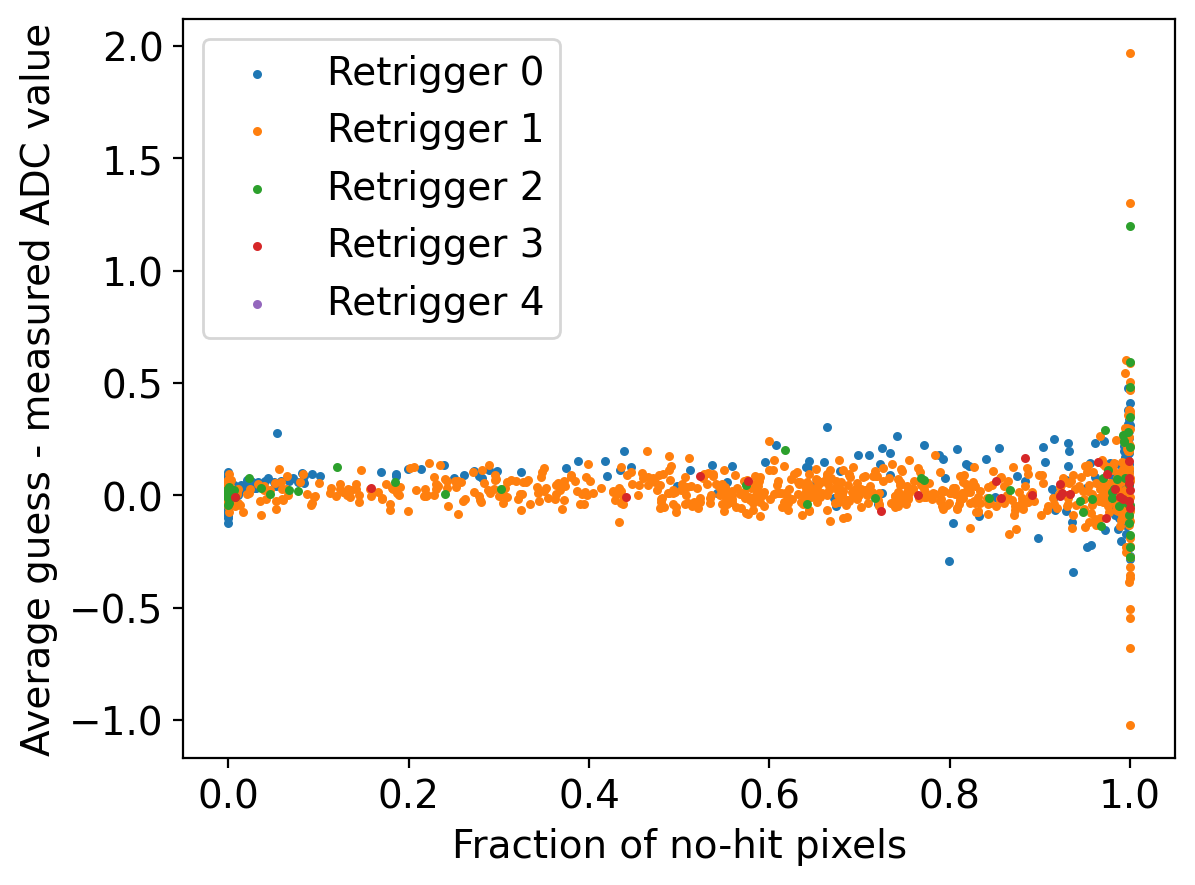

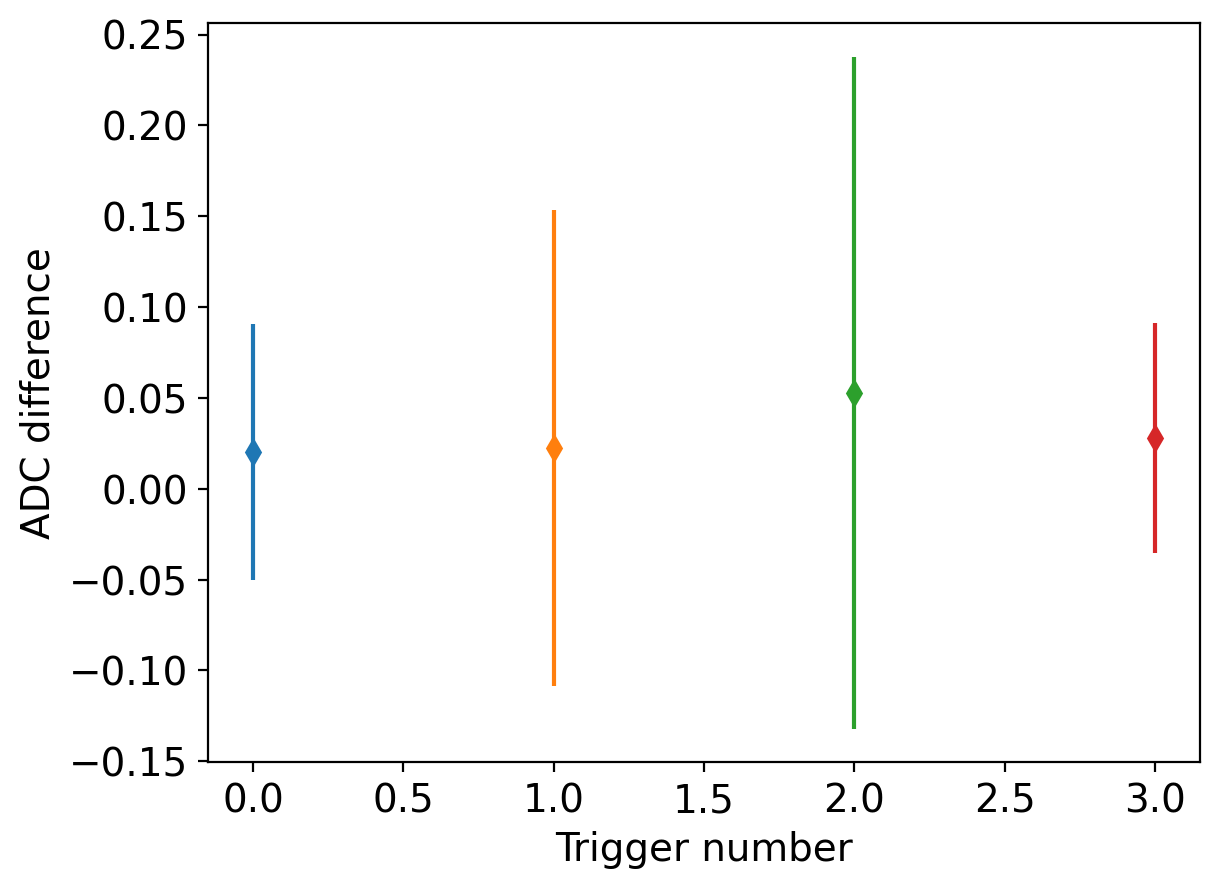

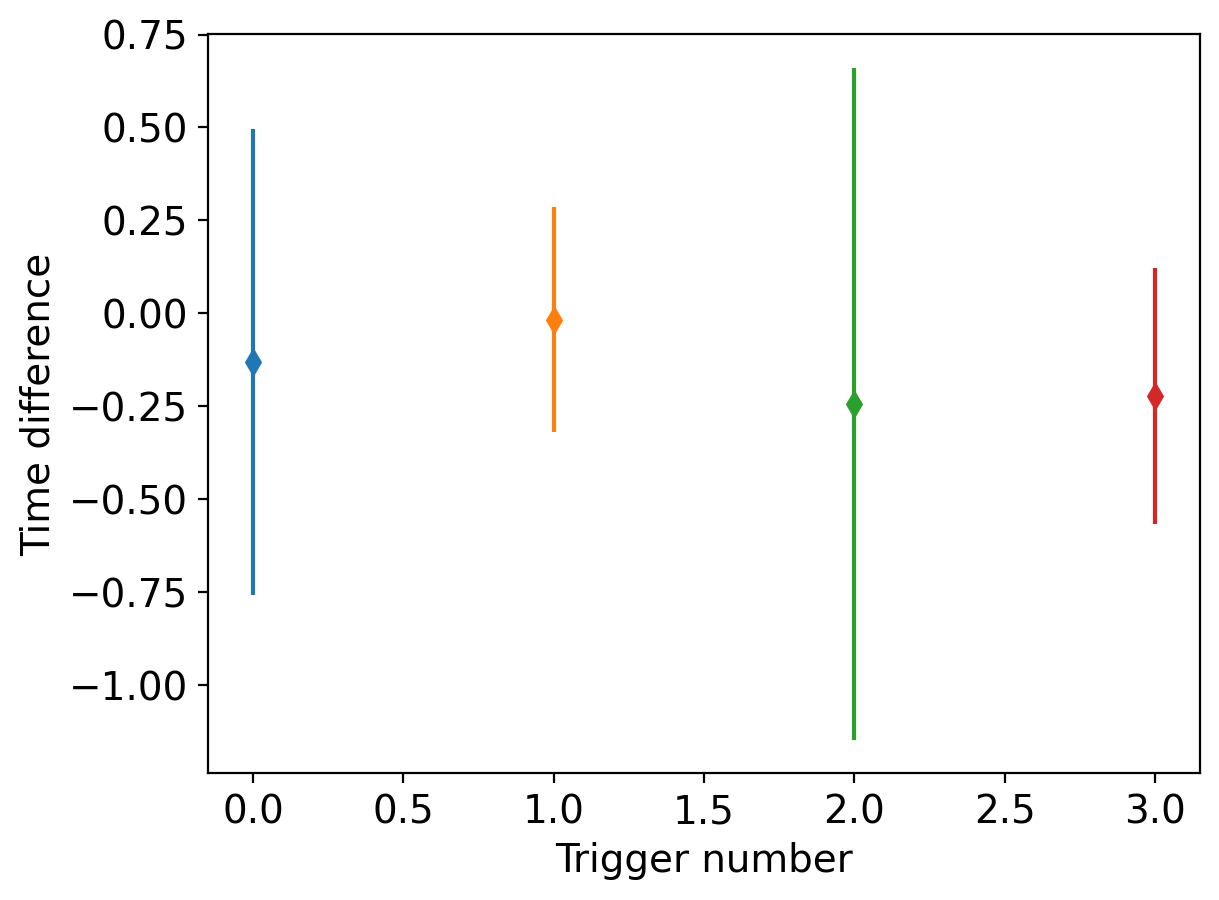

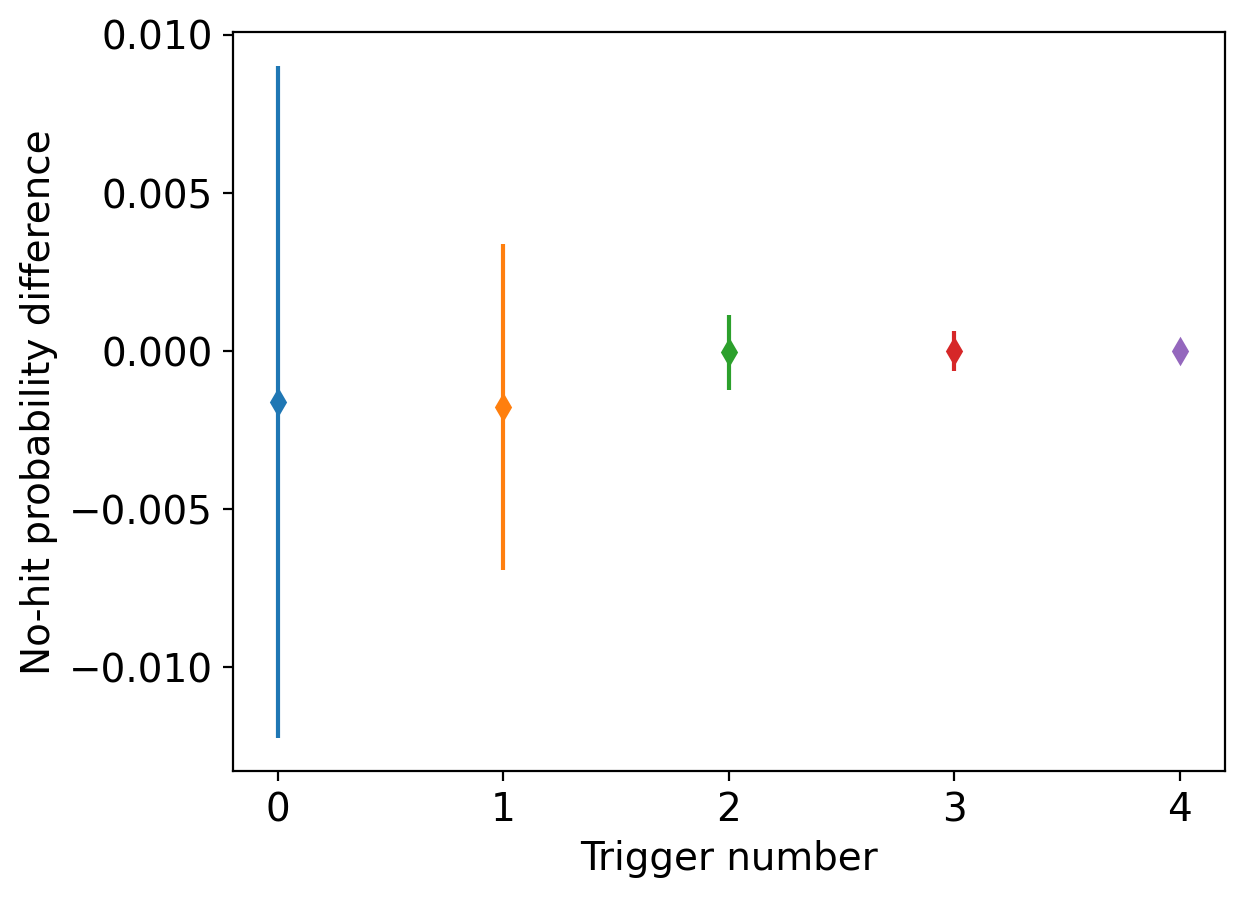

In [51]:
q_sum = (wfs_filtered[:, 1:] * ref_params.t_sampling).cumsum(axis=-1)  # Cumulative sum over time ticks
# charge_avg, tick_avg, no_hit_prob, guess = get_adc_values_average_noise(ref_params, wfs_filtered[:, 1:])

sigma = ref_params.RESET_NOISE_CHARGE
roi_threshold = 0.01


Npix = wfs_filtered.shape[0]
Nticks = wfs_filtered.shape[1] - 1

roi_start = jnp.argmax(wfs_filtered[:, 1:] > roi_threshold, axis=1)
roi_end = wfs_filtered.shape[1] - jnp.argmax(wfs_filtered[:, :1:-1] > roi_threshold, axis=1)

with_roi = roi_start > 0

largest_roi = jnp.max((roi_end-roi_start)[with_roi])
# largest_roi = 1999

wfs_with_roi = wfs_filtered[:, 1:].at[jnp.arange(Npix)[:, None], (jnp.arange(largest_roi) + roi_start[:, None])].get(unique_indices=True)

charge_avg, tick_avg, no_hit_prob = get_adc_values_average_noise(ref_params, wfs_with_roi, 20)
tick_avg = tick_avg + roi_start
print(no_hit_prob)

print("charge_avg shape:", charge_avg.shape, "tick_avg shape:", tick_avg.shape, "no_hit_prob shape:", no_hit_prob.shape)
adc_avg = digitize(ref_params, charge_avg)

mask = (ticks_filtered < 1998) & (adcs_filtered > digitize(ref_params, ref_params.DISCRIMINATION_THRESHOLD))


average_measured = jnp.sum(ticks_filtered*mask, axis=0)/jnp.sum(mask, axis=0)

for i in range(5):
    plt.scatter(average_measured[:, i], tick_avg[i, :], s=5, label=f'Retrigger {i}')

plt.plot([0, 1000], [0, 1000], color='r', linestyle='--')
plt.xlabel('Average measured tick number')
plt.ylabel('Average guess tick number')
plt.legend()



plt.figure()
for i in range(5):
    plt.hist(tick_avg[i, :] - average_measured[:, i], bins=100, range=(-5, 5), histtype='step', label=f'Average guess - measured ; retrigger {i}');
plt.xlabel('Average guess - measured tick number')
plt.ylabel('Counts')
plt.legend()


average_measured_adc = jnp.sum(adcs_filtered*mask, axis=0)/jnp.sum(mask, axis=0)

plt.figure()
for i in range(5):
    plt.scatter(average_measured_adc[:, i], tick_avg[i, :] - average_measured[:, i], s=5, label=f'Retrigger {i}')

plt.xlabel('Average measured ADC value')
plt.ylabel('Average guess - measured tick number')
plt.legend()

plt.figure()
for i in range(5):
    plt.scatter(average_measured_adc[:, i], adc_avg[i, :], s=5, label=f'Retrigger {i}')
plt.plot([75, 105], [75, 105], color='r', linestyle='--')
plt.xlabel('Average measured ADC value')
plt.ylabel('Average guess ADC value')
plt.legend()

plt.figure()
for i in range(5):
    plt.hist(adc_avg[i, :].flatten() - average_measured_adc[:, i].flatten(), bins=100, range=(-2, 2), histtype='step', label=f'Retrigger {i}');
plt.xlabel('Average guess - measured ADC value')
plt.ylabel('Counts')
plt.legend()


plt.figure()

measured_no_hit_prob = np.mean(~mask, axis=0)
for i in range(0, 5):
    plt.scatter(measured_no_hit_prob[:, i], no_hit_prob[i, :], s=5, label=f'Retrigger {i}')
plt.xlabel('Fraction of no-hit pixels')
plt.ylabel('No-hit probability')
plt.plot([0, 1], [0, 1], color='k', linestyle='--')
plt.legend()


plt.figure()
for i in range(0, 5):
    plt.scatter(measured_no_hit_prob[:, i], average_measured_adc[:, i] - adc_avg[i, :], s=5, label=f'Retrigger {i}')
plt.xlabel('Fraction of no-hit pixels')
plt.ylabel('Average guess - measured ADC value')
plt.legend()

plt.figure()
for i in range(0, 5):
    avg_diff = jnp.nanmean(average_measured_adc[:, i] - adc_avg[i, :])
    std_diff = jnp.nanstd(average_measured_adc[:, i] - adc_avg[i, :])
    plt.errorbar(i, avg_diff, yerr=std_diff, marker='d')
plt.xlabel("Trigger number")
plt.ylabel("ADC difference")

plt.figure()
for i in range(0, 5):
    avg_diff = jnp.nanmean(tick_avg[i, :] - average_measured[:, i])
    std_diff = jnp.nanstd(tick_avg[i, :] - average_measured[:, i])
    plt.errorbar(i, avg_diff, yerr=std_diff, marker='d')
plt.xlabel("Trigger number")
plt.ylabel("Time difference")

plt.figure()
for i in range(0, 5):
    avg_diff = jnp.nanmean(no_hit_prob[i, :] - measured_no_hit_prob[:, i])
    std_diff = jnp.nanstd(no_hit_prob[i, :] - measured_no_hit_prob[:, i])
    plt.errorbar(i, avg_diff, yerr=std_diff, marker='d')
plt.xlabel("Trigger number")
plt.ylabel("No-hit probability difference")

# plt.xscale('log')
# plt.yscale('log')
# plt.legend()

# print("Average tick difference:", np.mean(tick_avg - average_measured.T, axis=1)[0])
# print("Std tick difference:", np.std(tick_avg - average_measured.T, axis=1)[0])
# print("Average ADC difference:", np.mean(adc_avg - average_measured_adc.T, axis=1)[0])
# print("Std ADC difference:", np.std(adc_avg - average_measured_adc.T, axis=1)[0])
# print("Average no-hit probability difference:", np.mean(no_hit_prob - measured_no_hit_prob.T, axis=1)[0])
# print("Std no-hit probability difference:", np.std(no_hit_prob - measured_no_hit_prob.T, axis=1)[0])

In [11]:
q_sum = (wfs_filtered[:, 1:] * ref_params.t_sampling).cumsum(axis=-1)  # Cumulative sum over time ticks

avg_diff_time = []
std_diff_time = []
avg_diff_charge = []
std_diff_charge = []
avg_diff_rate = []
std_diff_rate = []
scalings = [1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
for scaling in tqdm(scalings):
    charge_avg, tick_avg, no_hit_prob = get_adc_values_average_noise(ref_params, wfs_filtered[:, 1:], scaling)
    adc_avg = digitize(ref_params, charge_avg)

    mask = (ticks_filtered < 1998) & (adcs_filtered > digitize(ref_params, ref_params.DISCRIMINATION_THRESHOLD))
    measured_no_hit_prob = np.mean(~mask, axis=0)
    
    average_measured = jnp.sum(ticks_filtered*mask, axis=0)/jnp.sum(mask, axis=0)
    average_measured_adc = jnp.sum(adcs_filtered*mask, axis=0)/jnp.sum(mask, axis=0)
    for i in range(5):
        avg_diff_time.append(jnp.nanmean(tick_avg[i, :] - average_measured[:, i]))
        std_diff_time.append(jnp.nanstd(tick_avg[i, :] - average_measured[:, i]))

        avg_diff_charge.append(jnp.nanmean(adc_avg[i, :] - average_measured_adc[:, i]))
        std_diff_charge.append(jnp.nanstd(adc_avg[i, :] - average_measured_adc[:, i]))

        avg_diff_rate.append(jnp.nanmean(measured_no_hit_prob[:, i] - no_hit_prob[i, :]))
        std_diff_rate.append(jnp.nanstd(measured_no_hit_prob[:, i] - no_hit_prob[i, :]))

100%|██████████| 14/14 [00:36<00:00,  2.59s/it]


Text(0, 0.5, 'Difference in time')

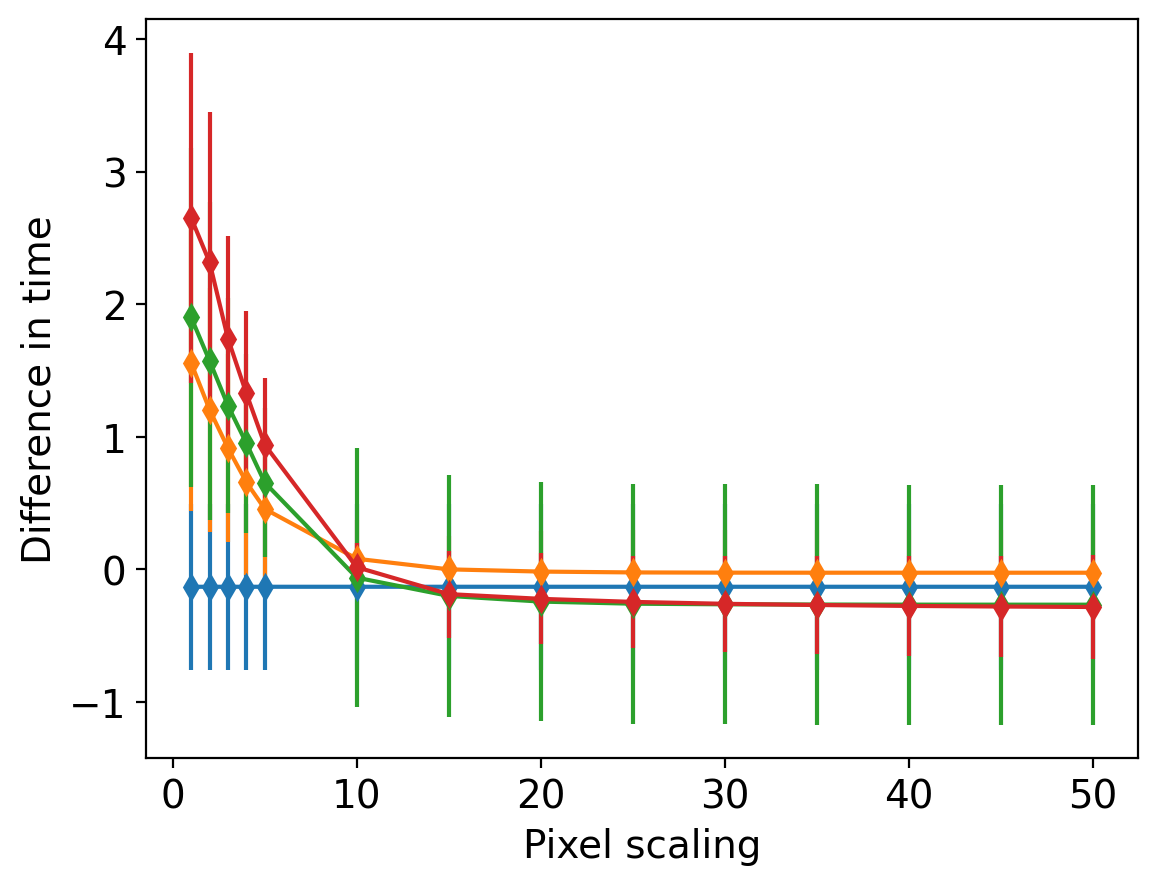

In [12]:
plt.figure()
for i in range(5):
    plt.errorbar(scalings, avg_diff_time[i::5], yerr=std_diff_time[i::5], marker='d')
plt.xlabel("Pixel scaling")
plt.ylabel("Difference in time")

Text(0, 0.5, 'Difference in charge')

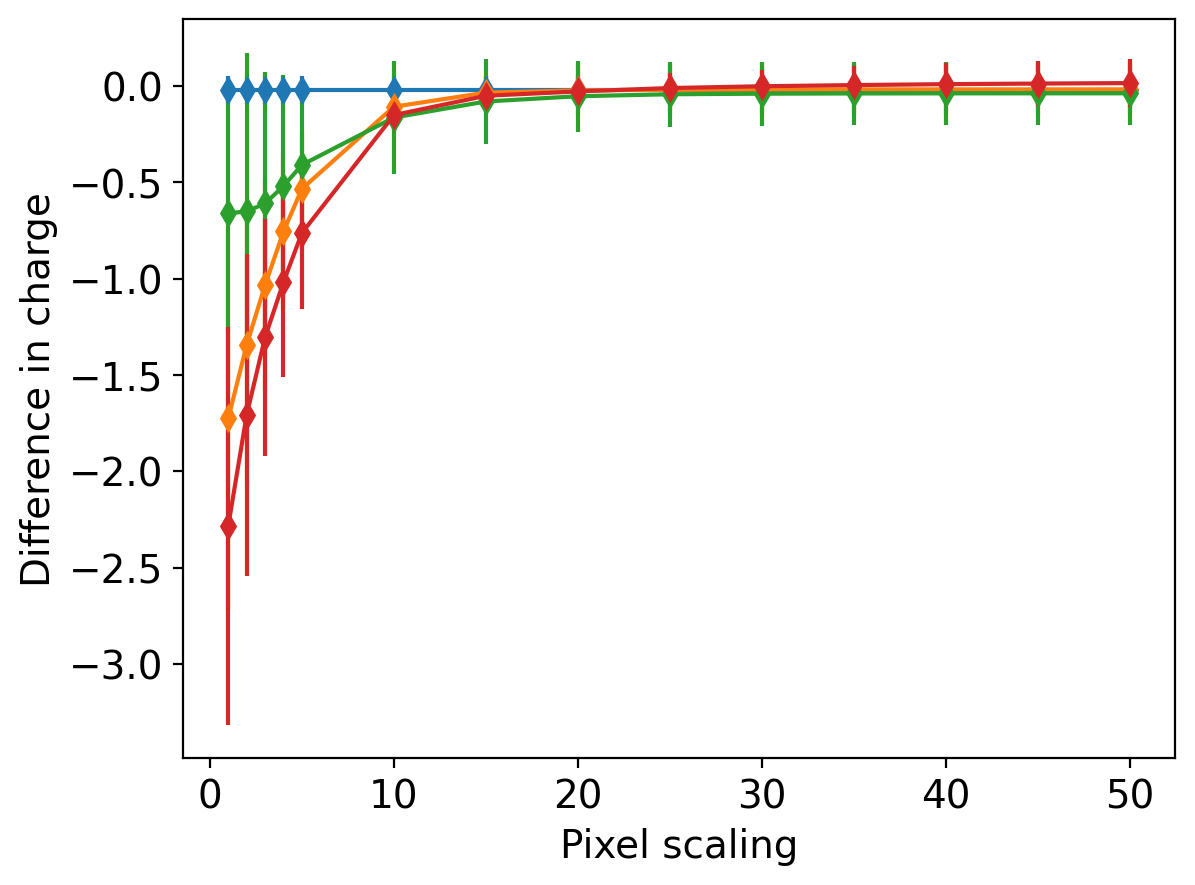

In [13]:
plt.figure()
for i in range(5):
    plt.errorbar(scalings, avg_diff_charge[i::5], yerr=std_diff_charge[i::5], marker='d')
plt.xlabel("Pixel scaling")
plt.ylabel("Difference in charge")


Text(0, 0.5, 'Difference in no-hit-rate')

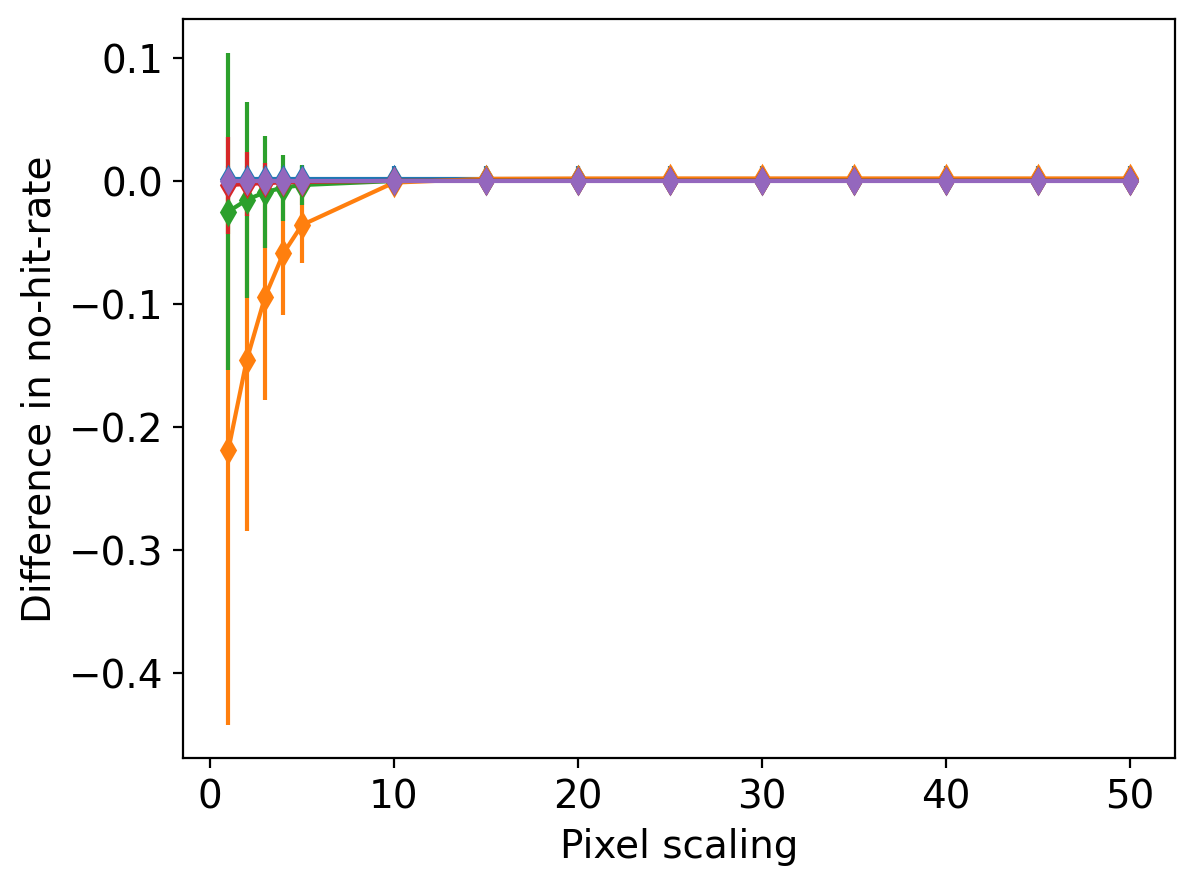

In [14]:
plt.figure()
for i in range(5):
    plt.errorbar(scalings, avg_diff_rate[i::5], yerr=std_diff_rate[i::5], marker='d')
plt.xlabel("Pixel scaling")
plt.ylabel("Difference in no-hit-rate")

In [19]:

Params = build_params_class(["RESET_NOISE_CHARGE"])
ref_params = load_detector_properties(Params,
                                      "src/larndsim/detector_properties/module0.yaml",
                                      'src/larndsim/pixel_layouts/multi_tile_layout-2.4.16_v4.yaml')

ref_params = ref_params.replace(
    signal_length=150,
    number_pix_neighbors=4,
    electron_sampling_resolution=0.005,
    mc_diff=True,
    # UNCORRELATED_NOISE_CHARGE=0.0,
)

(charge_avg, tick_avg, no_hit_prob) = get_adc_values_average_noise(ref_params, wfs_filtered[:, 1:], 20)



def loss(params):
    (charge_avg2, tick_avg2, no_hit_prob2) = get_adc_values_average_noise(params, wfs_filtered[:, 1:], 20)
    return jnp.sum((no_hit_prob - no_hit_prob2)**2)

values = np.linspace(0.5, 1.5, 20)*ref_params.RESET_NOISE_CHARGE
grads = []
for value in tqdm(values):
    modified_params = ref_params.replace(RESET_NOISE_CHARGE=value)
    grads.append(grad(loss)(modified_params).RESET_NOISE_CHARGE)



100%|██████████| 20/20 [01:12<00:00,  3.62s/it]


In [28]:
make_jaxpr(grad(loss))(modified_params)

let clip = { lambda ; a:i32[1999] b:i32[] c:i32[]. let
    d:i32[] = convert_element_type[new_dtype=int32 weak_type=False] b
    e:i32[1999] = max d a
    f:i32[] = convert_element_type[new_dtype=int32 weak_type=False] c
    g:i32[1999] = min f e
  in (g,) } in
let jaxpr = { lambda ; h:f32[] i:f32[]. let j:f32[] = add h i in (j,) } in
let jaxpr1 = { lambda ; k:f32[] l:f32[]. let m:f32[] = add k l in (m,) } in
{ lambda n:f32[1092,2001] o:f32[5,1092]; p:f32[] q:f32[] r:f32[] s:f32[]. let
    t:f32[1092,2000] = slice[
      limit_indices=(1092, 2001)
      start_indices=(0, 1)
      strides=None
    ] n
    _:f32[5,1092] _:f32[5,1092] u:f32[5,1092] v:f32[] w:f32[] x:i32[1999,1] y:i32[2000]
      z:bool[2000] ba:f32[1092] bb:f32[1092,1999] bc:f32[1,1999] bd:f32[1092] be:f32[21840]
      bf:f32[5,21840,2000] bg:f32[5,21840,2000] bh:f32[5,2000,21840] bi:f32[5,2000,21840]
      bj:f32[5,21840,1999] bk:f32[5,21840,1999] bl:f32[5,21840,1999] bm:f32[5,21840,1]
      bn:f32[5,21840,1999] bo:i32[5

Fraction of ticks above lb: 1.2648678


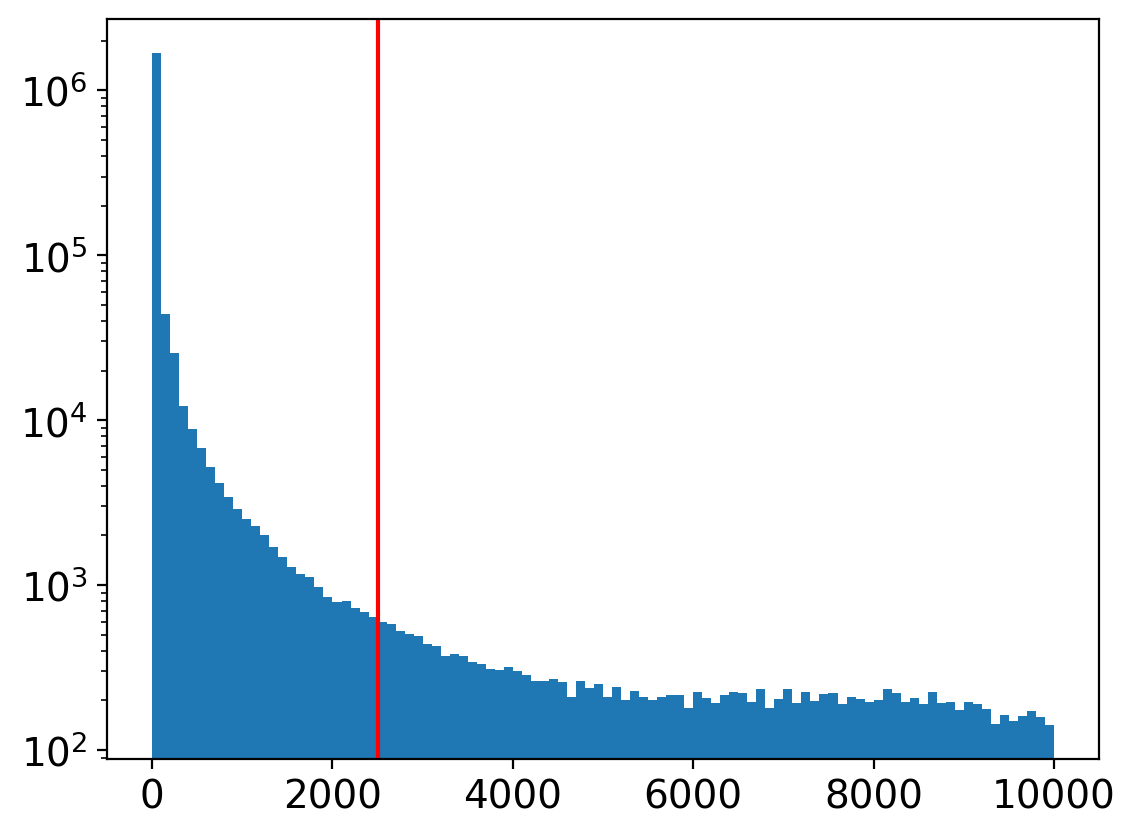

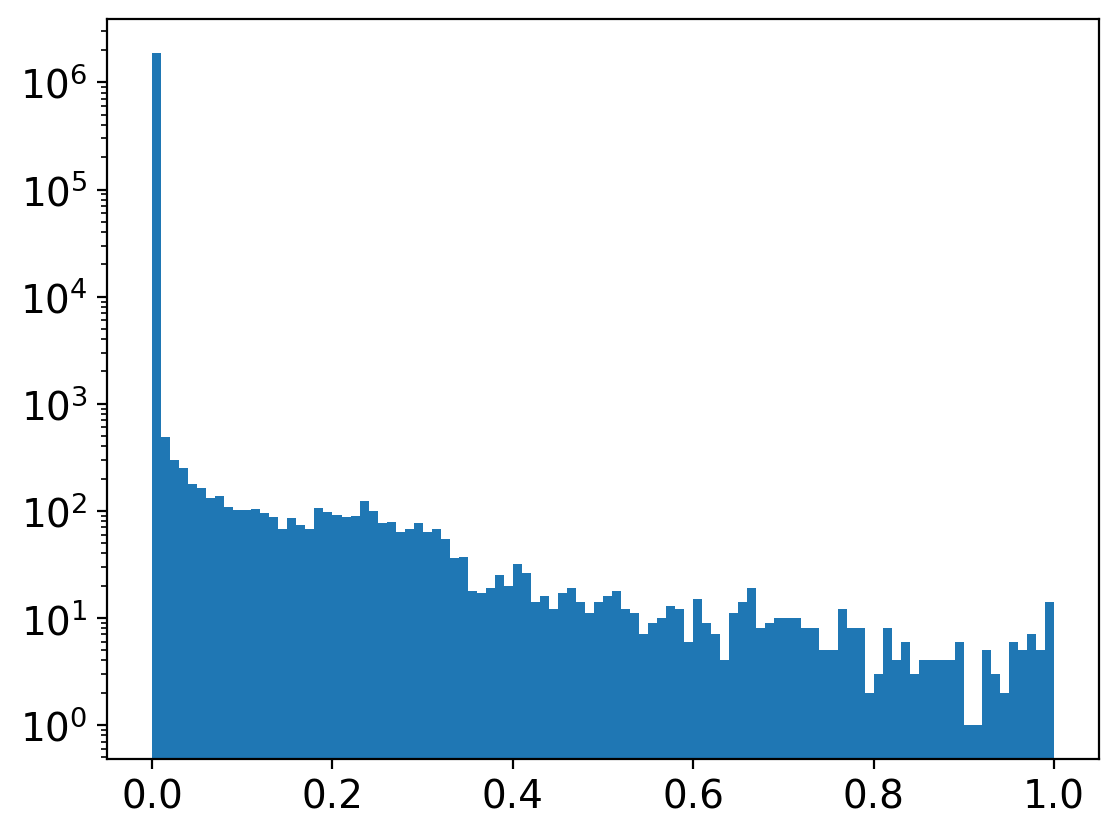

In [34]:
plt.hist(wfs_filtered[:, 1:].flatten(), bins=100, range=(0, 10000));
plt.yscale('log')
# plt.avxhline

sigma = ref_params.RESET_NOISE_CHARGE #Found out that only considering the reset noise was sufficient
# sigma = jnp.sqrt(params.RESET_NOISE_CHARGE**2 + params.UNCORRELATED_NOISE_CHARGE**2)
eps = 1e-10

lb = ref_params.DISCRIMINATION_THRESHOLD - 5*sigma
plt.axvline(lb, color='r')

_, Nticks = wfs_filtered[:, 1:].shape

erf_term = erf((wfs_filtered[:, 1:] - ref_params.DISCRIMINATION_THRESHOLD)/(jnp.sqrt(2)*sigma)) # erf_term[Nvalues, Nticks]
erf_term_signal = jnp.frompyfunc(jnp.maximum, 2, 1).accumulate(erf_term, axis=-1) #erf is increasing so should be faster to make the re-ordering afterwards

guess = 0.5*(erf_term_signal[..., 1:] - erf_term_signal[..., :-1]) # guess[Nvalues, Nticks - 1]
plt.figure()
plt.hist(guess.flatten(), bins=100, range=(0, 1));
plt.yscale('log')

print("Fraction of ticks above lb:", jnp.count_nonzero(wfs_filtered[:, 1:] >= lb)/wfs_filtered[:, 1:].size*100)

In [29]:
ref_params.DISCRIMINATION_THRESHOLD

7000.0

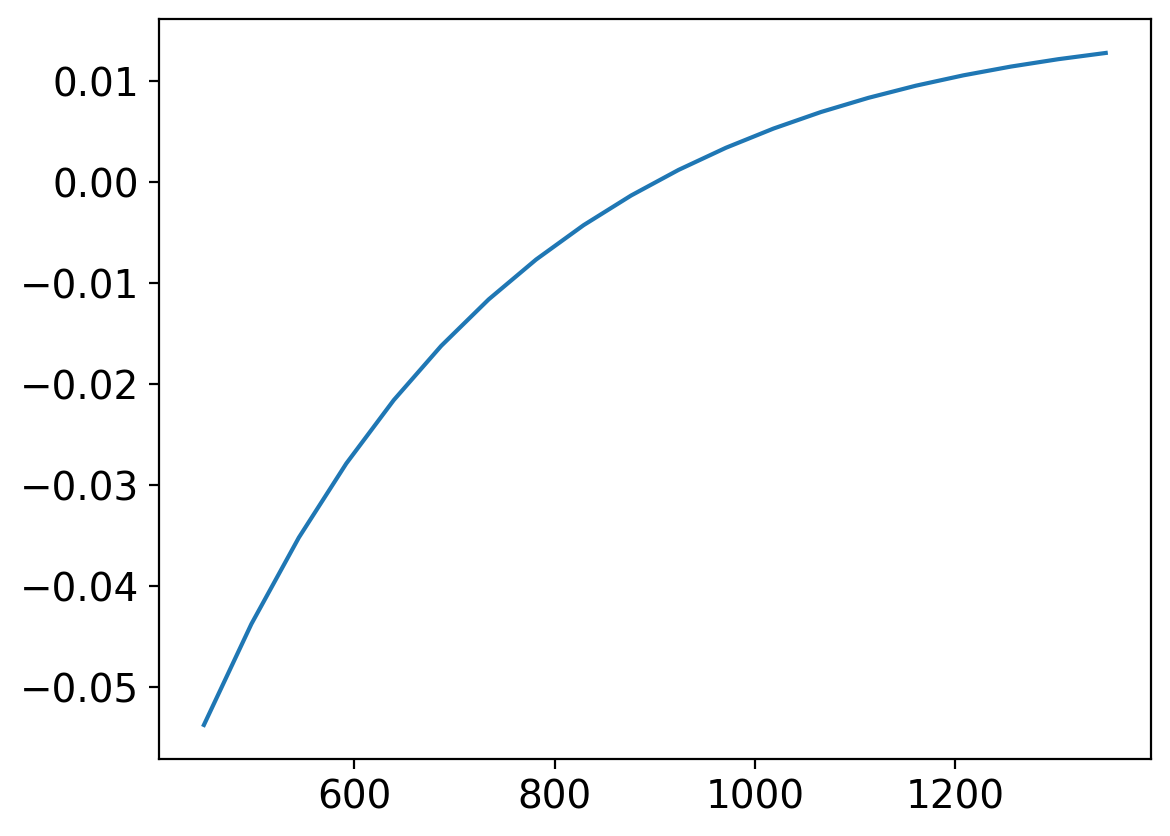

In [20]:
plt.figure()
plt.plot(values, grads)

In [18]:
%timeit get_adc_values(ref_params, wfs_filtered[:, 1:], jax.random.key(0))

9.72 ms ± 3.35 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [69]:
@jit
def get_adc_values_average_noise(params, pixels_signals):
    q = pixels_signals*params.t_sampling
    q_sum = q.cumsum(axis=-1)  # Cumulative sum over time ticks

    # N_universe = 50
    Nvalues_scaling = 100
    Npix = pixels_signals.shape[0]
    Nvalues = Nvalues_scaling*Npix


    def find_hit(carry, it):
        q_sum_loc, previous_prob, pixid = carry # q_sum_loc[Nvalues, Nticks] ; previous_prob[Nvalues] ; pixid[Nvalues]
        sigma = params.RESET_NOISE_CHARGE #Found out that only considering the reset noise was sufficient
        # sigma = jnp.sqrt(params.RESET_NOISE_CHARGE**2 + params.UNCORRELATED_NOISE_CHARGE**2)
        eps = 1e-10

        _, Nticks = q_sum_loc.shape

        erf_term = erf((q_sum_loc - params.DISCRIMINATION_THRESHOLD)/(jnp.sqrt(2)*sigma)) # erf_term[Nvalues, Nticks]
        erf_term_signal = jnp.frompyfunc(jnp.maximum, 2, 1).accumulate(erf_term, axis=-1) #erf is increasing so should be faster to make the re-ordering afterwards

        guess = 0.5*(erf_term_signal[..., 1:] - erf_term_signal[..., :-1]) # guess[Nvalues, Nticks - 1]
        guess = jnp.clip(guess, 0, 1)  # Ensure guess is between 0 and 1, should not be needed but erf got odd behavior for some reason

        interval = round((3 * params.CLOCK_CYCLE + params.ADC_HOLD_DELAY * params.CLOCK_CYCLE) / params.t_sampling)
        shifted_ticks = jnp.arange(Nticks - 1) + interval + 1 # shifted_ticks[Nticks - 1]
        shifted_ticks = jnp.clip(shifted_ticks, 0, Nticks - 1)

        prob_event = jnp.clip(0.5*(erf_term[..., shifted_ticks] - erf_term[..., :-1]), 0, guess)

        esperance_value = q_sum_loc[..., shifted_ticks] + params.DISCRIMINATION_THRESHOLD - 0.5*(q_sum_loc[..., 1:] + q_sum_loc[..., :-1]) # esperance_value[Nvalues, Nticks - 1]

        norm = jnp.clip(jnp.sum(prob_event, axis=-1) + eps, 0, 1)  # Adding a small epsilon to avoid division by zero ; norm[Nvalues]

        previous_prob_norm = jnp.full(Npix, eps, dtype=jnp.float32)  # Avoid division by zero
        previous_prob_norm = previous_prob_norm.at[pixid].add(previous_prob)

        no_hit_prob_across = jnp.ones(Npix, dtype=jnp.float32)  # Initialize no-hit probability across universes
        no_hit_prob_across = no_hit_prob_across.at[pixid].subtract(norm*previous_prob)  # No-hit probability across universes

        prob_distrib = prob_event*previous_prob[:, None] # prob_distrib[Nvalues, Nticks - 1]

        prob_distrib_across = jnp.zeros((Npix, Nticks - 1), dtype=jnp.float32)  # Initialize probability distribution across universes
        prob_distrib_across = prob_distrib_across.at[pixid].add(prob_distrib)  # prob_distrib_across[Npix, Nticks - 1]

        norm_across = jnp.sum(prob_distrib_across, axis=-1)  # Normalize across universes ; norm_across[Npix]

        tick_avg = jnp.sum(prob_distrib_across/(norm_across[:, None])*jnp.arange(Nticks - 1), axis=-1)  # + 0.5

        charge_avg = jnp.sum(prob_event*esperance_value, axis=-1) # charge_avg[Nvalues]

        charge_avg_across = jnp.zeros((Npix,), dtype=jnp.float32)  # Initialize average charge across universes
        charge_avg_across = charge_avg_across.at[pixid].add(charge_avg*previous_prob)/previous_prob_norm/norm_across  # charge_avg_across[Npix]

        best_paths = jnp.argsort(prob_distrib, axis=None, descending=True)[:Nvalues] # best_paths[Nvalues]
        best_path_universe = best_paths // (Nticks - 1)
        best_path_ticks = best_paths % (Nticks - 1)
        best_path_pixid = pixid[best_path_universe]  # best_path_pixid[Nvalues]

        best_path_next_ticks = jnp.clip(shifted_ticks + 1, 0, Nticks - 1) # best_path_next_ticks[Nticks - 1]
        best_path_esperance = q_sum_loc[best_path_universe, best_path_next_ticks[best_path_ticks]]  # best_path_esperance[Nvalues]
        best_path_wfs = q_sum_loc[best_path_universe, :]
        q_sum_new = best_path_wfs - best_path_esperance[..., None]
        # q_sum_new = jnp.clip(q_sum_new, 0, None)  # Ensure no negative values
        new_prob = prob_distrib[best_path_universe, best_path_ticks] # new_prob[Nvalues]
        # leftover = jnp.sum(prob_distrib_across, axis=1) - jnp.sum(new_prob, axis=1)  # Leftover probability after taking the best paths
        leftover = jnp.zeros(Npix)
        return (q_sum_new, new_prob, best_path_pixid), (charge_avg_across, tick_avg, no_hit_prob_across, leftover)
    
    q_sum_multi = jnp.zeros((Nvalues, q_sum.shape[1]), dtype=jnp.float32)  # Initialize q_sum for multiple universes
    q_sum_multi = q_sum_multi.at[:q_sum.shape[0], :].set(q_sum)
    previous_prob = jnp.zeros(Nvalues, dtype=jnp.float32)  # Initialize previous probability
    previous_prob = previous_prob.at[:q_sum.shape[0]].set(1.0)  # Set the first universe probability to 1.0
    pixid = jnp.full((Nvalues,), -1, dtype=jnp.int32)  # Initialize pixel IDs for multiple universes
    pixid = pixid.at[:q_sum.shape[0]].set(jnp.arange(q_sum.shape[0]))  # Set pixel IDs for the first universe

    init_loop = (q_sum_multi, previous_prob, pixid)  # Initialize previous_prob
    # init_loop = (q_sum_multi[1080:1081], previous_prob[1080:1081])  # Initialize previous_prob
    # _, (charge_avg, tick_avg, no_hit_prob, guess) = lax.scan(find_hit, init_loop, jnp.arange(0, params.MAX_ADC_VALUES))

    # _, (charge_avg, tick_avg, no_hit_prob, guess) = lax.scan(find_hit, init_loop, jnp.arange(0, 1))
    _, (charge_avg, tick_avg, no_hit_prob, leftover) = lax.scan(find_hit, init_loop, jnp.arange(0, params.MAX_ADC_VALUES))
    # _, (charge_avg, tick_avg, no_hit_prob, leftover) = lax.scan(find_hit, init_loop, jnp.arange(0, 5))
    # carry, (charge_avg, tick_avg, no_hit_prob, guess) = find_hit(init_loop, 0)
    # carry, (charge_avg, tick_avg, no_hit_prob, guess) = find_hit(carry, 1)
    # carry, (charge_avg, tick_avg, no_hit_prob, guess) = find_hit(carry, 2)
    # carry, (charge_avg, tick_avg, no_hit_prob, guess) = find_hit(carry, 3)

    return (charge_avg, tick_avg, no_hit_prob, leftover)

traced = jax.jit(get_adc_values_average_noise).trace(ref_params, wfs_filtered[:, 1:])

In [68]:
%timeit get_adc_values_average_noise(ref_params, wfs_filtered[:, 1:,])

3.65 s ± 9.14 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
%timeit get_adc_values_average_noise(ref_params, wfs_filtered[:, 1:,], 20)

652 ms ± 8.82 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [63]:
traced = jax.jit(get_adc_values_average_noise).trace(ref_params, wfs_filtered[:, 1:])
lowered = traced.lower()
compiled = lowered.compile()
print("MFlops:", compiled.cost_analysis()['flops']*1e-6)
print("MBytes accessed:", compiled.cost_analysis()['bytes accessed']*1e-6)

MFlops: 5174.9847039999995
MBytes accessed: 13578.023936


In [42]:
traced = jax.jit(get_adc_values_average_noise).trace(ref_params, wfs_filtered[:, 1:])
lowered = traced.lower()
compiled = lowered.compile()
print("MFlops:", compiled.cost_analysis()['flops']*1e-6)
print("MBytes accessed:", compiled.cost_analysis()['bytes accessed']*1e-6)

MFlops: 10559.412224
MBytes accessed: 27126.173695999998


In [41]:
traced = jax.jit(get_adc_values).trace(ref_params, wfs_filtered[:, 1:], jax.random.key(0))
lowered = traced.lower()
compiled = lowered.compile()
print("MFlops:", compiled.cost_analysis()['flops']*1e-6)
print("MBytes accessed:", compiled.cost_analysis()['bytes accessed']*1e-6)

MFlops: 179.945728
MBytes accessed: 125.998848


In [40]:
compiled.cost_analysis()

{'bytes accessed3{}': 4376.0,
 'bytes accessedout{3}': 4.0,
 'bytes accessed9{}': 8728004.0,
 'bytes accessed': 125998848.0,
 'utilization11{}': 1.0,
 'bytes accessedout{4}': 4.0,
 'bytes accessed8{}': 8732.0,
 'bytes accessedout{1}': 20230416.0,
 'utilization4{}': 8.0,
 'bytes accessed6{}': 4368.0,
 'utilization7{}': 2.0,
 'utilization3{}': 9.0,
 'utilization6{}': 3.0,
 'bytes accessed12{}': 8728000.0,
 'utilization10{}': 1.0,
 'utilization9{}': 2.0,
 'bytes accessed5{}': 8.0,
 'transcendentals': 10910.0,
 'bytes accessed11{}': 8728.0,
 'utilization5{}': 5.0,
 'utilization2{}': 28.0,
 'bytes accessed4{}': 4372.0,
 'utilization0{}': 77.0,
 'bytes accessedout{0}': 17512736.0,
 'bytes accessed2{}': 9356428.0,
 'bytes accessedout{2}': 4368.0,
 'bytes accessedout{}': 39576268.0,
 'bytes accessed0{}': 30695332.0,
 'bytes accessedout{5}': 4.0,
 'bytes accessed1{}': 40593596.0,
 'bytes accessedout{6}': 4.0,
 'utilization8{}': 2.0,
 'flops': 179945728.0,
 'utilization1{}': 642.0,
 'utilization

In [42]:
leftover_500 = leftover.copy()

ValueError: x and y must be the same size

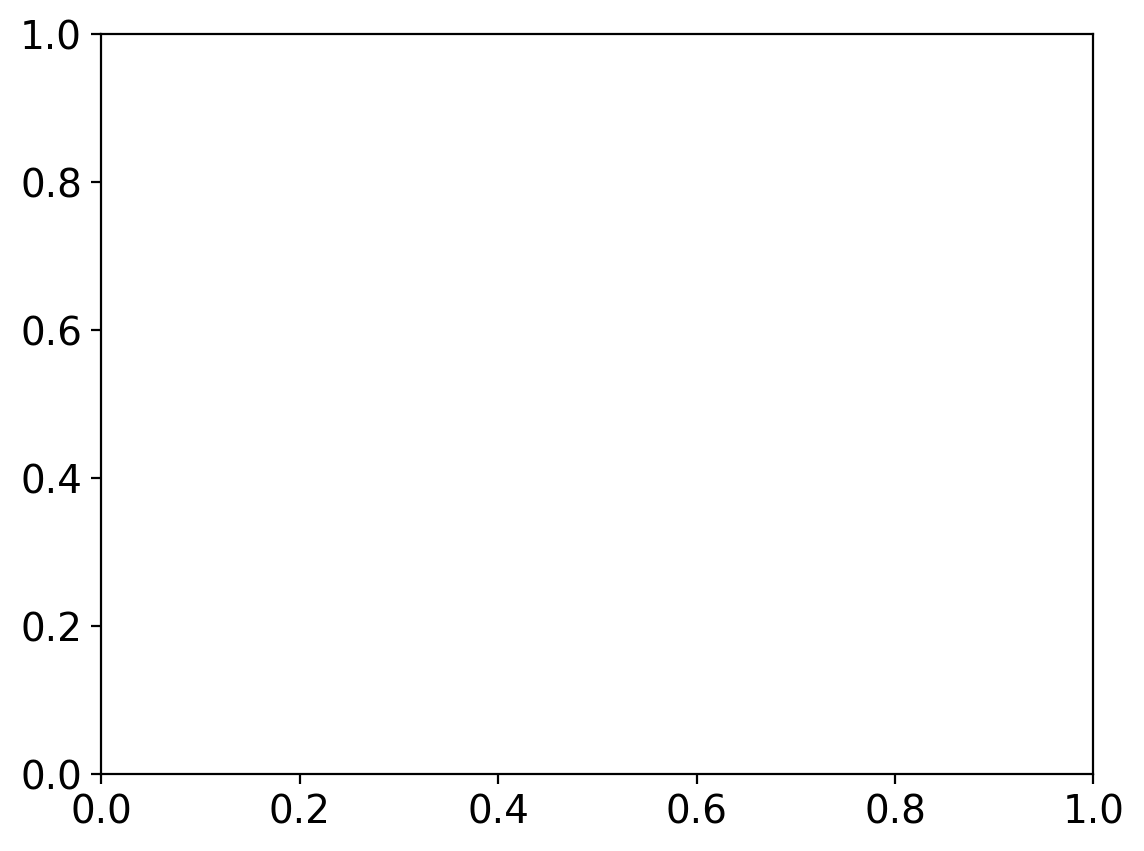

In [51]:
plt.scatter(leftover_500[1, :], leftover[1, :])

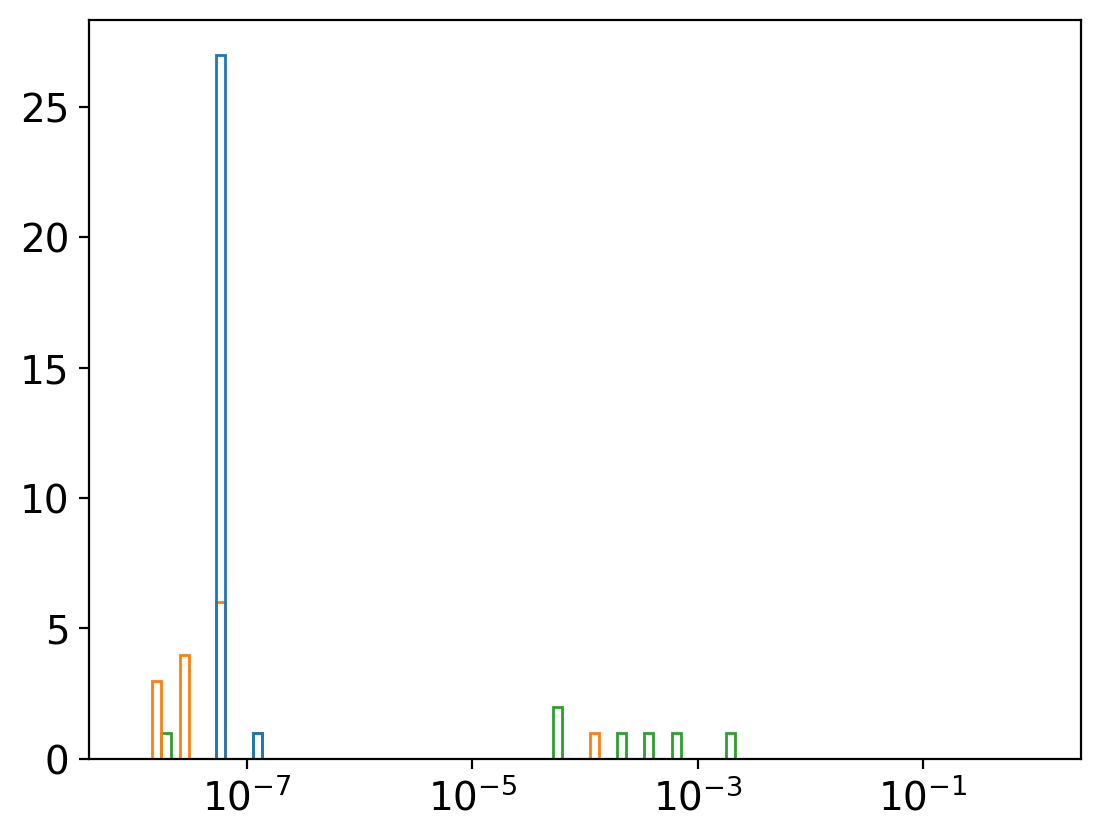

In [70]:
plt.hist(leftover.T, bins=np.logspace(-8, 0, 100), range=(0, 1), histtype='step', label='Leftover probability')
plt.xscale('log')

# plt.figure()
# for i in range(1, 3):
#     plt.scatter(leftover[i-1, :], tick_avg[i, :] - average_measured[:, i], s=5, label=f'Retrigger {i}')


In [60]:
leftover

Array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]

/lscratch/pgranger/tmp/ipykernel_3387338/3900814680.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


[845.6651 863.5482      nan      nan      nan]
[1.7881393e-07 9.6834129e-01 1.0000000e+00 1.0000000e+00 1.0000000e+00]
Guess no-hit probability: 1.0
Measured no-hit probability: 1.0
Measured avg adc: nan
Guess avg adc: nan
Guess time tick: nan
Measured time tick: nan


(array([0., 0., 0., ..., 0., 0., 0.]),
 array([0.000e+00, 1.000e+00, 2.000e+00, ..., 1.998e+03, 1.999e+03,
        2.000e+03]),
 [<matplotlib.patches.Polygon at 0x7fa544e1e3b0>])

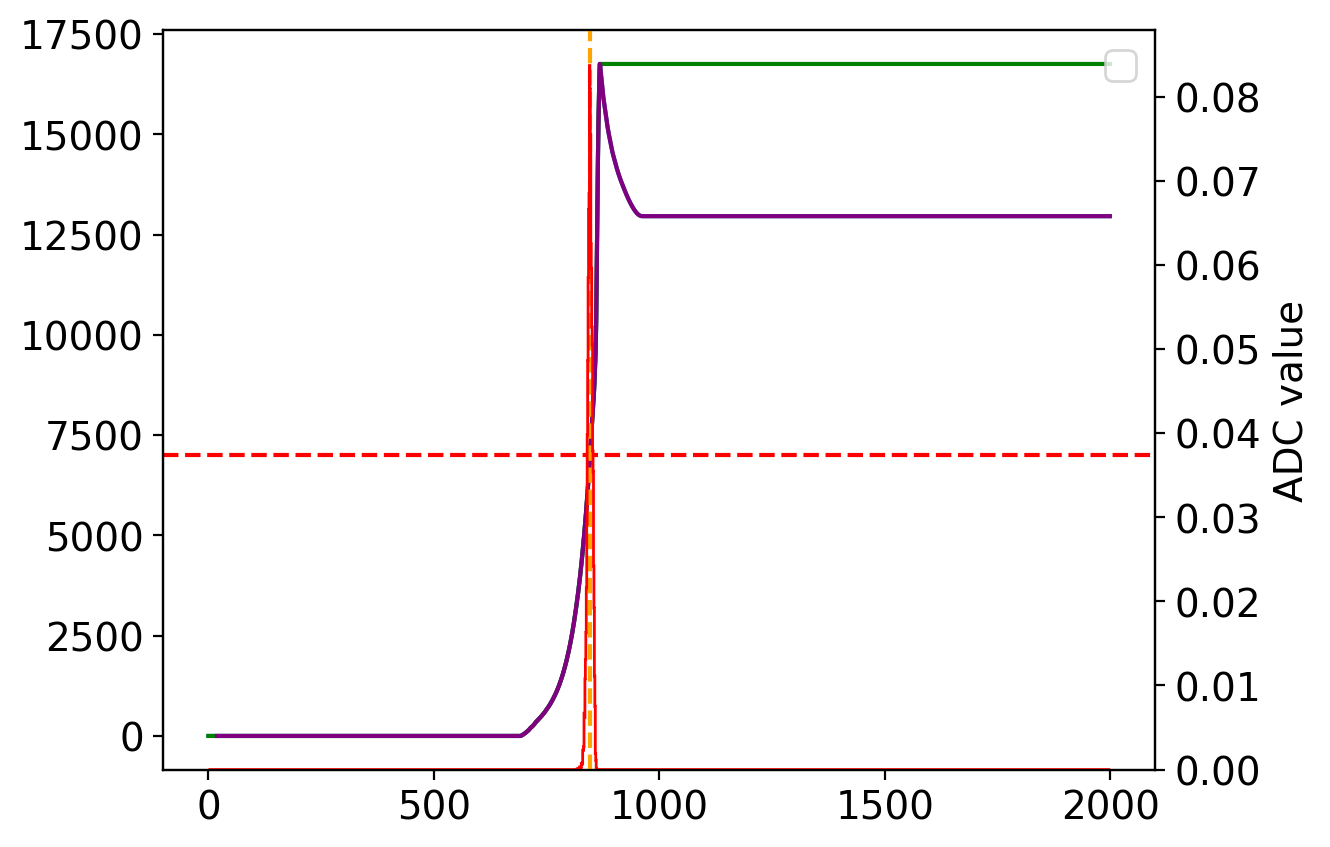

In [14]:
# iplot = 81 #1018 81 289
iplot = 7 #1018 81 289
hitidx = 2

plt.figure()
# q_sum = (wfs_filtered[:, 1:]*ref_params.t_sampling).cumsum(axis=-1)
plt.plot(q_sum[iplot], label='Waveform')
signal = jnp.frompyfunc(jnp.maximum, 2, 1, identity=0).accumulate(q_sum, axis=-1)
plt.plot(signal[iplot], label='Signal', color='green')
plt.axhline(ref_params.DISCRIMINATION_THRESHOLD, color='r', linestyle='--', label='Discrimination threshold')
# plt.plot(average_measured_adc[:, 0], label='Average measured ADC', color='blue')

sigma = ref_params.RESET_NOISE_CHARGE  # Found out that only considering the reset noise was sufficient
interval = round((3 * ref_params.CLOCK_CYCLE + ref_params.ADC_HOLD_DELAY * ref_params.CLOCK_CYCLE) / ref_params.t_sampling)
shifted_ticks = jnp.arange(q_sum.shape[1] - 1) + interval + 1
shifted_ticks = jnp.clip(shifted_ticks, 0, q_sum.shape[1] - 1)
esperance_value = q_sum[iplot, shifted_ticks] #+ sigma*0.5*(1 + erf((q_sum[iplot, :] - ref_params.DISCRIMINATION_THRESHOLD)/(jnp.sqrt(2)*sigma)))/(1 + erf(-(ref_params.DISCRIMINATION_THRESHOLD - q_sum[iplot, :])/(jnp.sqrt(2)*sigma)) + 1e-5)
esperance_value = q_sum[:, shifted_ticks] + sigma*(normpdf.pdf(q_sum[:, :-1], loc=ref_params.DISCRIMINATION_THRESHOLD, scale=sigma) - normpdf.pdf(q_sum[:, 1:], loc=ref_params.DISCRIMINATION_THRESHOLD, scale=sigma))/(erf((signal[:, 1:] - ref_params.DISCRIMINATION_THRESHOLD)/(jnp.sqrt(2)*sigma)) - erf((signal[:, :-1] - ref_params.DISCRIMINATION_THRESHOLD)/(jnp.sqrt(2)*sigma)) + 1e-5)

plt.plot(shifted_ticks, esperance_value[iplot], label='Esperance value', color='purple')

ax2 = plt.gca().twinx()


# prob_charge_pass = jnp.clip((1 + erf(-(ref_params.DISCRIMINATION_THRESHOLD - q_sum[iplot, shifted_ticks])/(jnp.sqrt(2)*sigma))) / (1 + erf(-(ref_params.DISCRIMINATION_THRESHOLD - q_sum[iplot, :])/(jnp.sqrt(2)*sigma)) + 1e-5), 0, 1)

# ax2.plot(guess[0, iplot, :]*prob_charge_pass[1:], label='Guess', color='purple' )
# ax2.plot(guess[0, iplot, :], label='Guess', color='orange' )
# ax2.plot(guess[0, iplot, :].cumsum(), label='Guess', color='red' )

plt.xlabel('Time tick')
plt.ylabel('ADC value')
# plt.xlim(680, 820)
# plt.xlim(0, 90)
plt.legend()
print(tick_avg[:, iplot])
print(no_hit_prob[:, iplot])
plt.axvline(tick_avg[0, iplot], color='orange', linestyle='--', label='Guess tick')
plt.axvline(average_measured[iplot, hitidx], color='blue', linestyle='--', label='Measured tick')
sigma = ref_params.RESET_NOISE_CHARGE  # Found out that only considering the reset noise was sufficient
# norm = 0.5*(erf((q_sum[iplot, -1] - ref_params.DISCRIMINATION_THRESHOLD)/(jnp.sqrt(2)*sigma)) - erf((q_sum[iplot, :1] - ref_params.DISCRIMINATION_THRESHOLD)/(jnp.sqrt(2)*sigma)))
# guess_plot = 0.5*(erf((signal[1:] - ref_params.DISCRIMINATION_THRESHOLD)/(jnp.sqrt(2)*sigma)) - erf((signal[:-1] - ref_params.DISCRIMINATION_THRESHOLD)/(jnp.sqrt(2)*sigma)))
# guess_plot = 0.5*(erf((signal[iplot, 1:] - ref_params.DISCRIMINATION_THRESHOLD)/(jnp.sqrt(2)*sigma)) - erf((signal[iplot, :-1] - ref_params.DISCRIMINATION_THRESHOLD)/(jnp.sqrt(2)*sigma)))



print("Guess no-hit probability:", no_hit_prob[hitidx, iplot])
print("Measured no-hit probability:", measured_no_hit_prob[iplot, hitidx])
# plt.plot(guess_plot, label='Guess (plot)', color='purple')
print("Measured avg adc:", average_measured_adc[iplot, hitidx])
print("Guess avg adc:", adc_avg[hitidx, iplot])
print("Guess time tick:", tick_avg[hitidx, iplot])
print("Measured time tick:", average_measured[iplot, hitidx])

plt.hist(ticks_filtered[:, iplot, 0][mask[:, iplot, 0]], bins=np.linspace(0, 2000, 2001), histtype='step', label='Measured ticks', color='r', density=True)

# shifted_ticks2 = jnp.clip(shifted_ticks + 1, 0, q_sum_loc.shape[1] - 1)


# plt.plot(shifted_ticks, prob_charge_pass, label='Probability of charge passing', color='purple')
# print((prob_charge_pass[..., :-1]*guess[0, iplot, :]).sum())


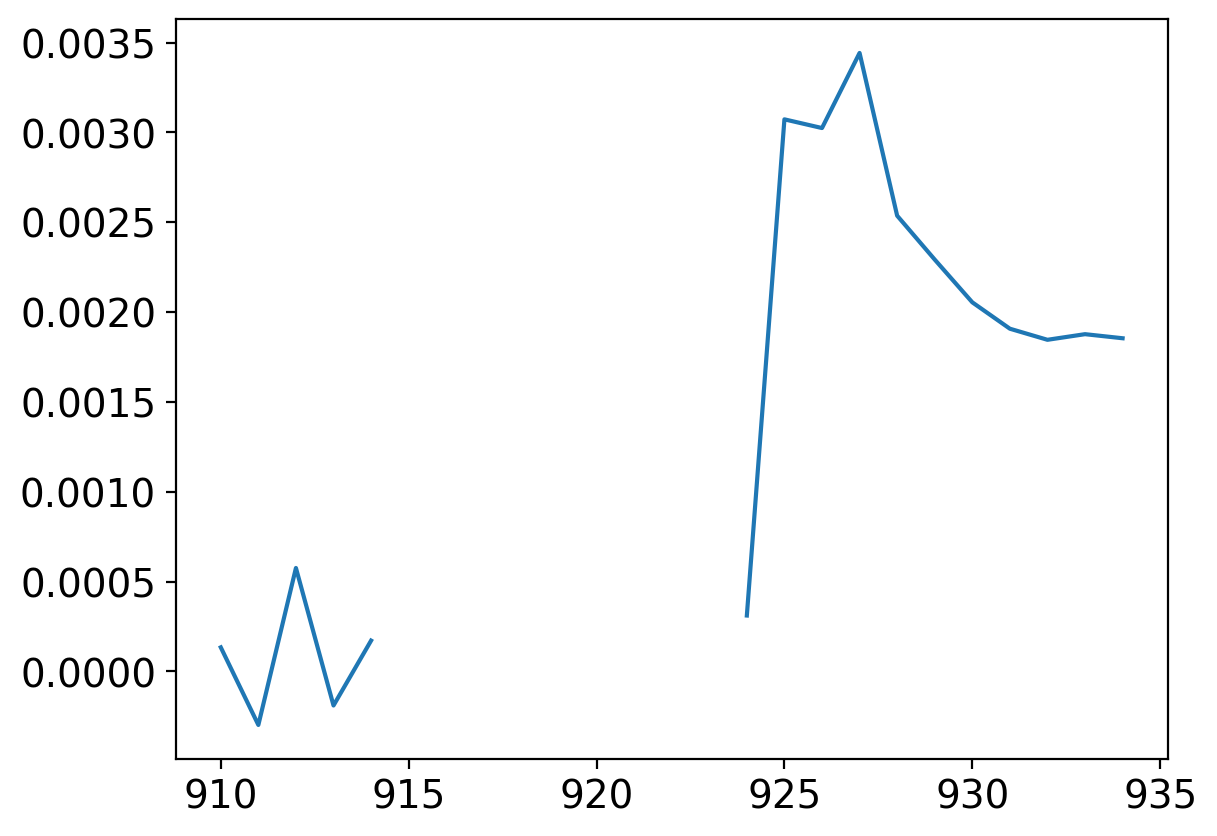

In [202]:
iplot = 550
plt.plot((normpdf.pdf(signal[iplot, 1:], loc=ref_params.DISCRIMINATION_THRESHOLD, scale=sigma) - normpdf.pdf(signal[iplot, :-1], loc=ref_params.DISCRIMINATION_THRESHOLD, scale=sigma))/(erf((signal[iplot, 1:] - ref_params.DISCRIMINATION_THRESHOLD)/(jnp.sqrt(2)*sigma)) - erf((signal[iplot, :-1] - ref_params.DISCRIMINATION_THRESHOLD)/(jnp.sqrt(2)*sigma))))

In [492]:
digitize(ref_params, ref_params.DISCRIMINATION_THRESHOLD)

Array(81.44862, dtype=float32, weak_type=True)

In [455]:
guess.shape

(10, 1128, 1999)

In [34]:
jnp.argsort(adc_avg[2, :].flatten() - average_measured_adc[:, 2].flatten())
# jnp.sort(adc_avg[0, :].flatten() - average_measured_adc[:, 0].flatten())

Array([107,   7,   8,  23,   0,  22,   2,  50, 104,   1,   3,   4,   5,
         6,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,
        21,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,
        36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,
        49,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,
        63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,
        76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,
        89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
       102, 103, 105, 106, 108, 109, 110], dtype=int32)

(1128, 1)

In [363]:
tick_avg[0, 1028]

Array(nan, dtype=float32)

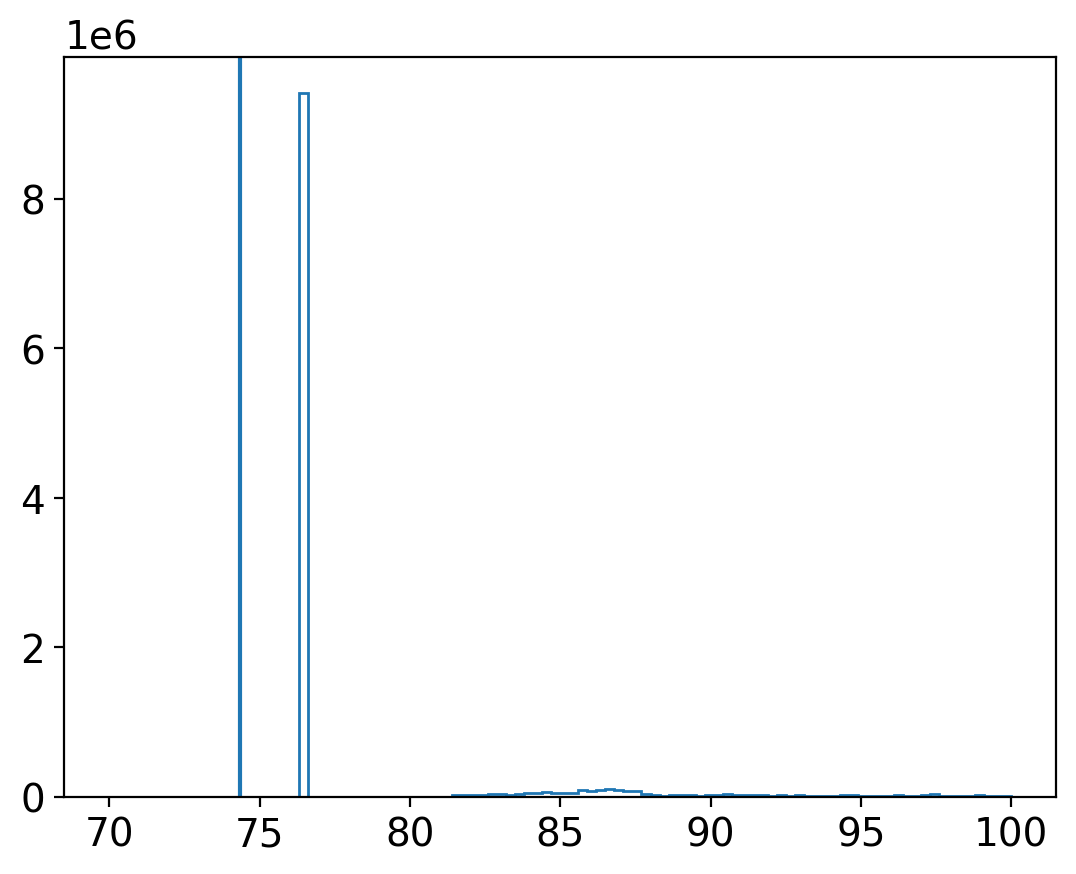

In [284]:
plt.hist(filtered.flatten(), bins=100, range=(70, 100), histtype='step', label='Filtered ADCs')
plt.axvline(74.3567)

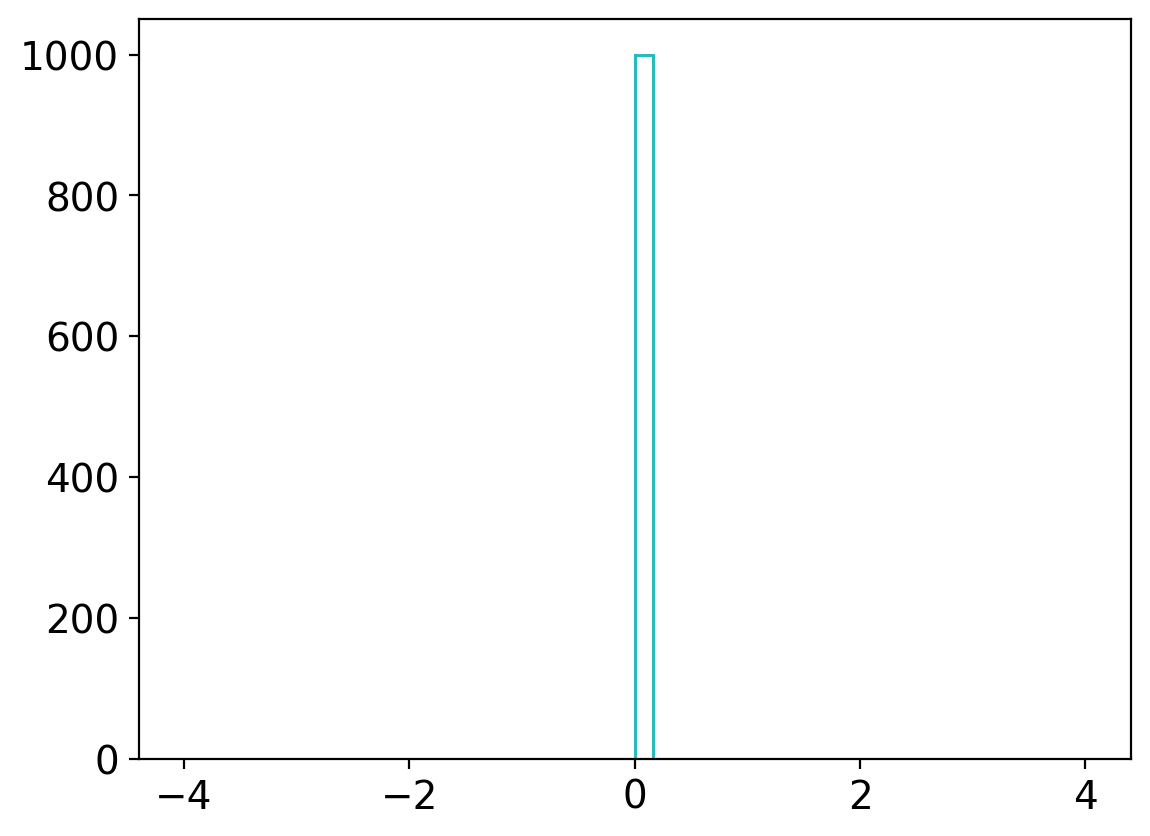

In [287]:
fig, ax = plt.subplots(1, 1)

for i in range(10):
    ax.hist(filtered[:, i, 0].flatten() - filtered[:, i, 0].flatten().mean(), bins=50, range=(-4, 4), histtype='step', label=f'pixel {i}')
    # ax.axvline(filtered_nonoise[i, 0] - filtered[:, i, 0].flatten().mean(), color='k', linestyle='--')
# plt.hist(filtered[:, :, 0].flatten(), bins=100, range=(75, 140));

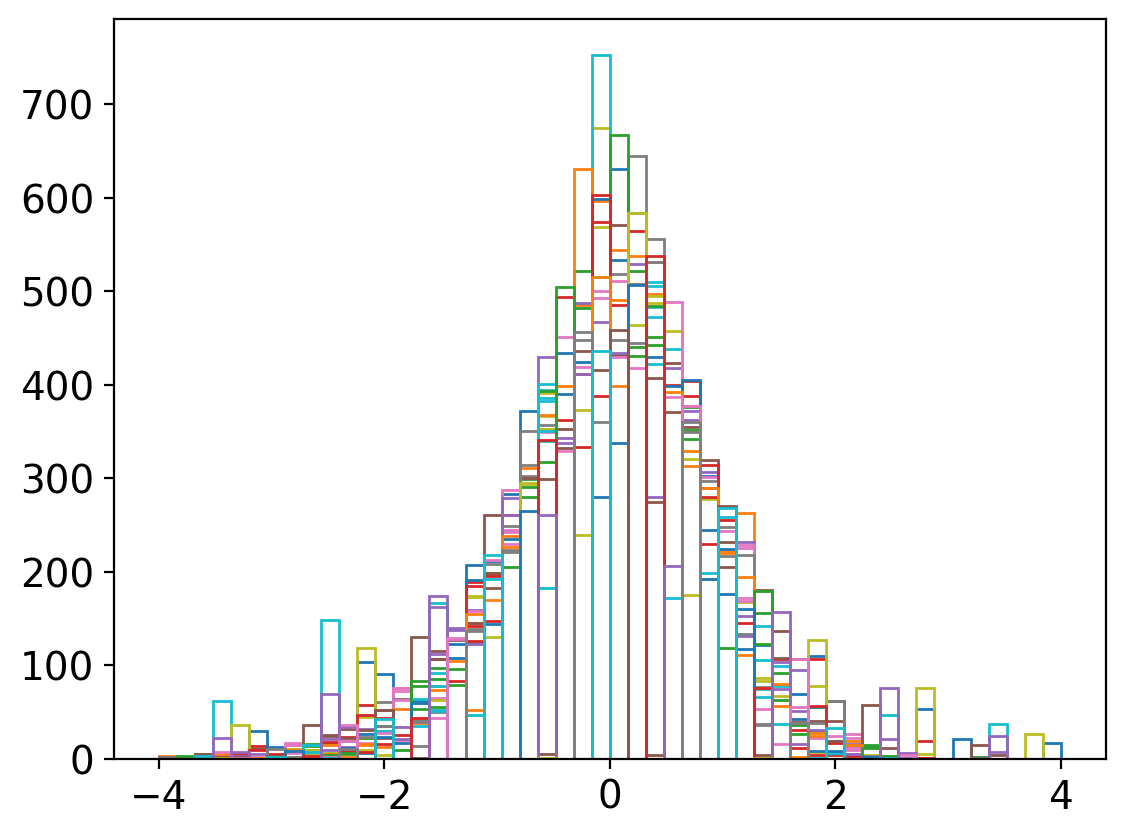

In [7]:
fig, ax = plt.subplots(1, 1)

for i in range(100):
    ax.hist(ticks_filtered[:, i, 0].flatten() - ticks_filtered[:, i, 0].flatten().mean(), bins=50, range=(-4, 4), histtype='step', label=f'pixel {i}')
    # ax.axvline(filtered_nonoise[i, 0] - filtered[:, i, 0].flatten().mean(), color='k', linestyle='--')
# plt.hist(filtered[:, :, 0].flatten(), bins=100, range=(75, 140));

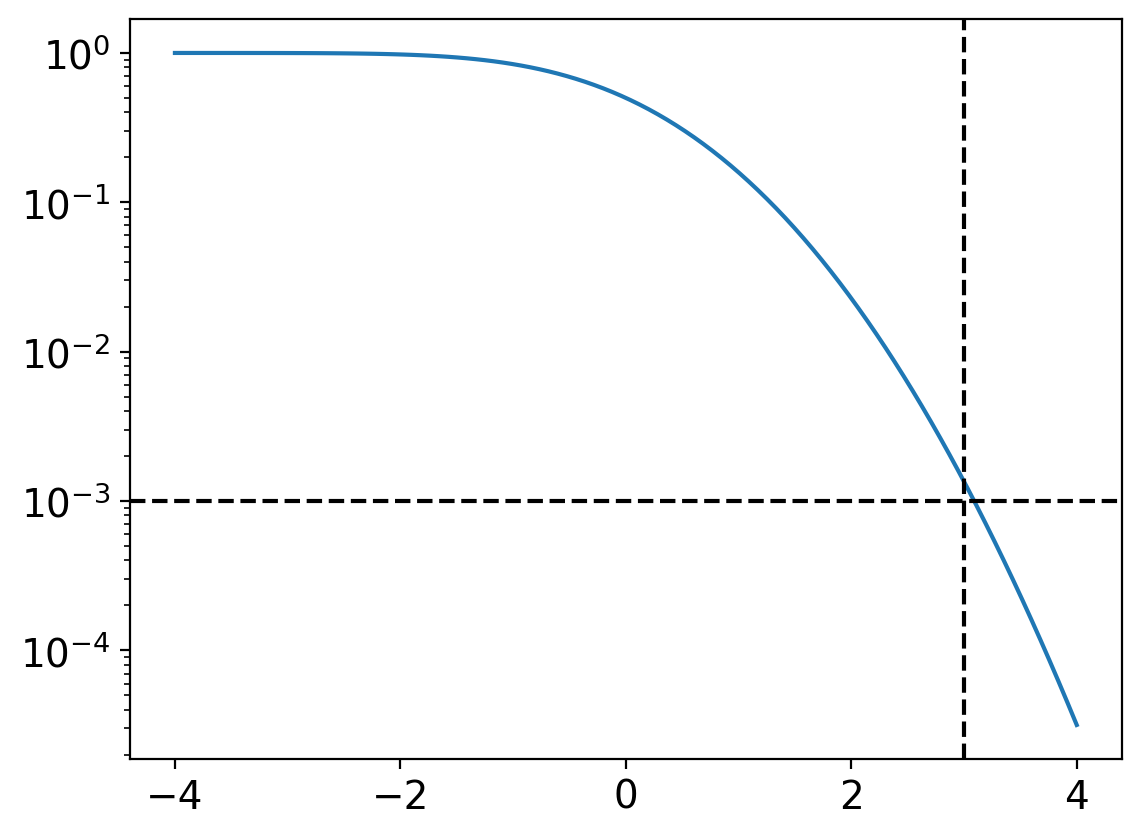

In [7]:
from scipy.special import erf

x = np.linspace(-4, 4, 100)
y = 0.5 * (1 - erf(x / np.sqrt(2)))
plt.plot(x, y)
plt.yscale('log')
plt.axhline(1e-3, color='k', linestyle='--')
plt.axvline(3, color='k', linestyle='--')

1029.5630140987
(1128,)
(1128, 2000)
(1128, 1000, 10)
(1128,)
(1128, 10)
(1010, 60)
[7.60661471e-05 1.00229693e-04 1.63388659e-04 2.47258198e-04
 2.84812649e-04 4.24598552e-04 6.50588379e-04 8.89839008e-04
 1.23898164e-03 1.53061270e-03 2.46013701e-03 3.25876409e-03
 4.61224090e-03 6.73593277e-03 9.97129302e-03 1.38850845e-02
 1.92063173e-02 2.74927142e-02 3.81187575e-02 5.36189364e-02
 6.89480071e-02 8.19051971e-02 9.06366965e-02 9.47999792e-02
 9.30552510e-02 8.48719818e-02 7.16540334e-02 5.65917632e-02
 4.08414623e-02 2.76680008e-02 1.85433504e-02 1.23880878e-02
 8.94889734e-03 7.23528339e-03 7.33467649e-03 9.25710742e-03
 1.01409467e-02 8.94260239e-03 6.27058232e-03 3.95613649e-03
 1.95048786e-03 1.35490934e-03 1.66494201e-03 1.18471467e-03
 1.27223039e-03 8.51676583e-04 5.56972372e-04 3.75528413e-04
 3.08955626e-04 2.79844865e-04 1.79346130e-04 3.91129692e-04
 1.36529780e-04 8.87101439e-05 7.03745947e-05 5.93897734e-05
 3.41636361e-05 8.17151424e-05 9.15179589e-05 1.10264709e-04]


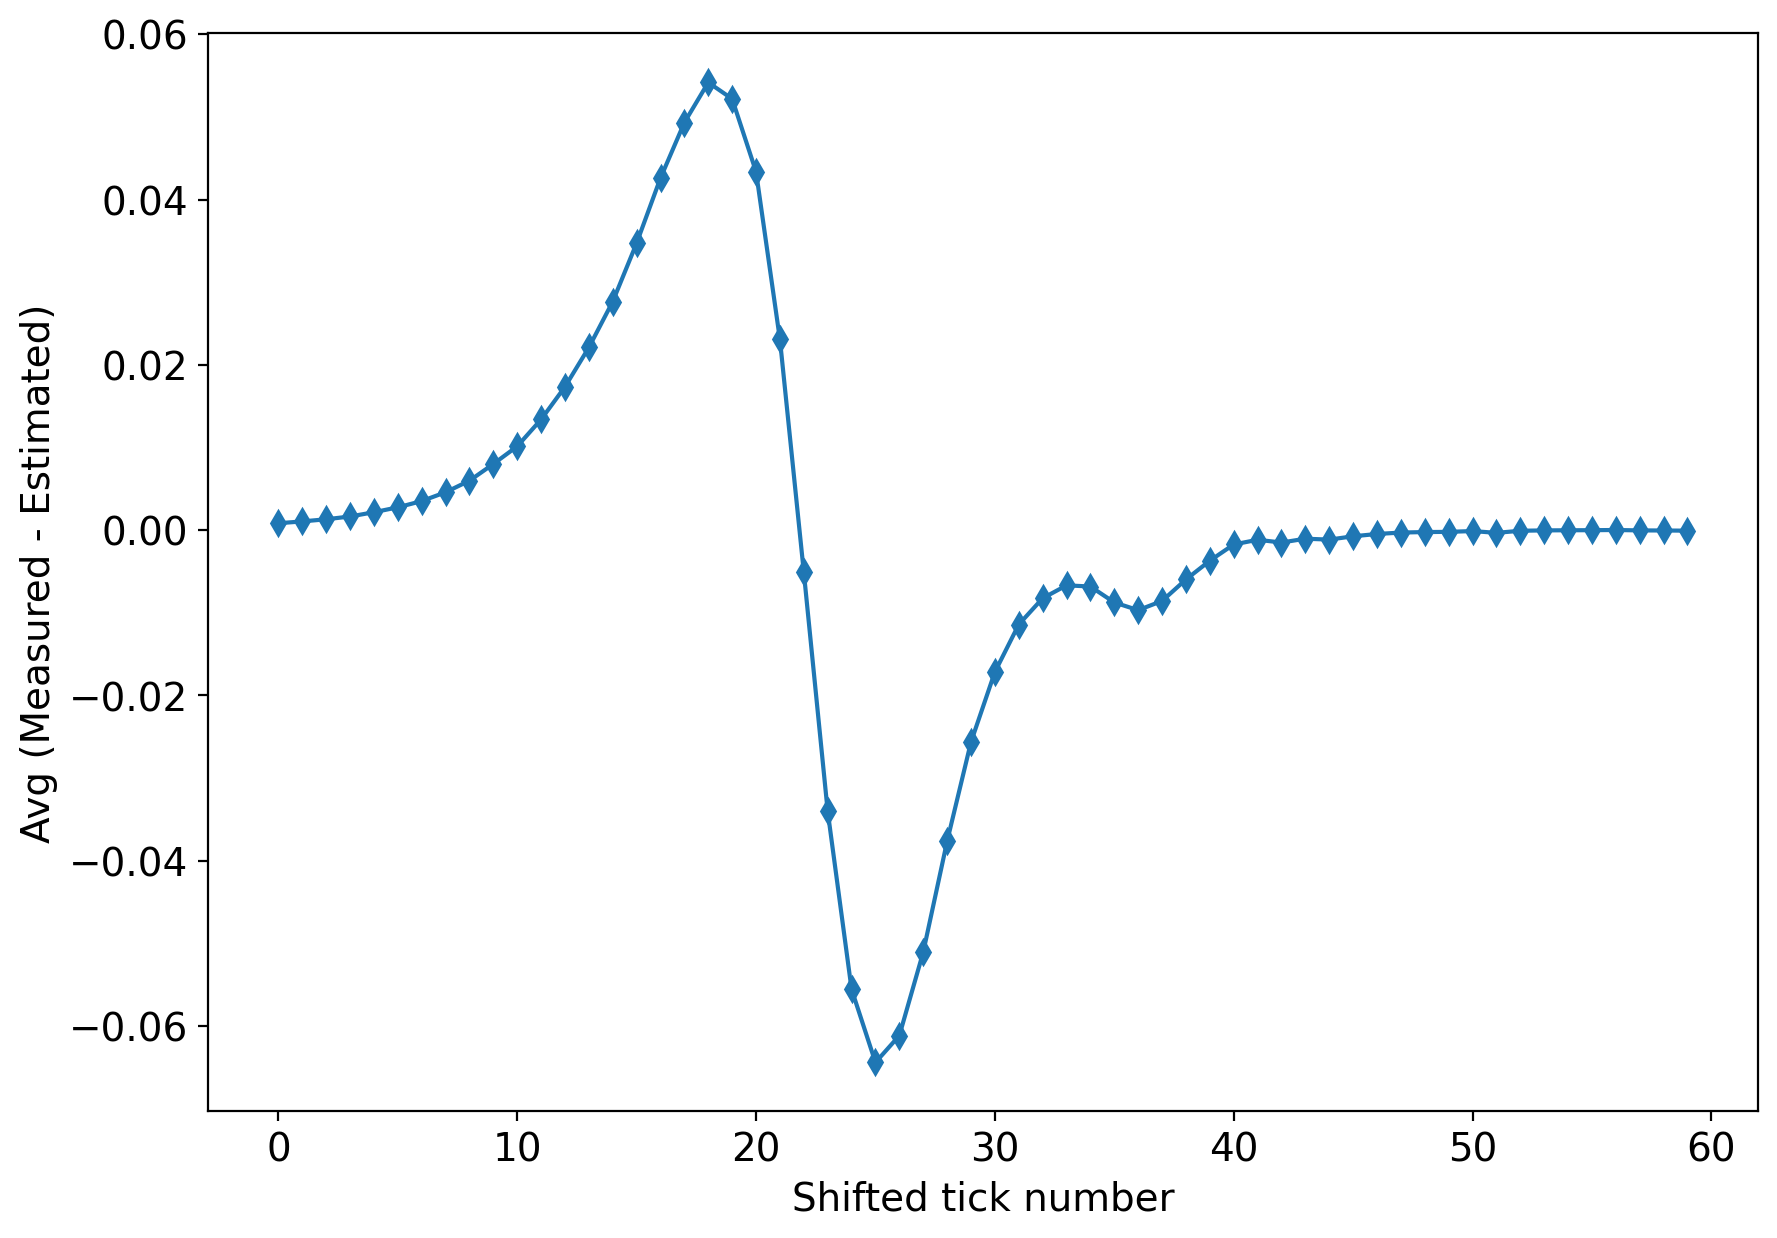

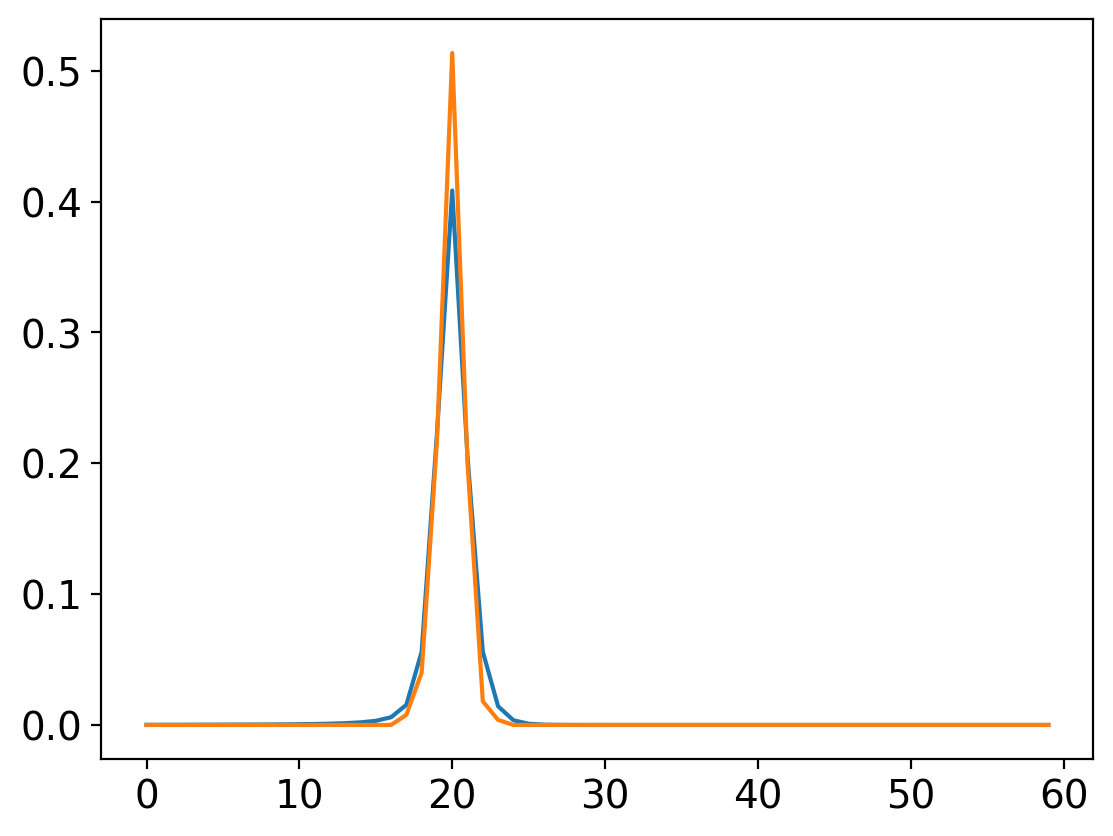

In [307]:
sigma = np.sqrt(ref_params.UNCORRELATED_NOISE_CHARGE**2 + ref_params.RESET_NOISE_CHARGE**2)
# sigma = 1
print(sigma)


plt.figure(figsize=(10, 7))

# i = 127

q_sum = np.cumsum(wfs_filtered[:, 1:], axis=1)*ref_params.t_sampling

# for i in range(0,1):
x = np.arange(1, wfs_filtered.shape[1])
lower_term = 0.5*(1 + erf((ref_params.DISCRIMINATION_THRESHOLD - q_sum)/(np.sqrt(2)*sigma)))
upper_term = 1-lower_term
lower_term = np.column_stack([np.ones((q_sum.shape[0])), np.cumprod(lower_term, axis=1)])
upper_term = np.column_stack([upper_term, np.ones((q_sum.shape[0]))])
guess = (upper_term[:, 1:]*lower_term[:, 1:])
# ax = plt.gca()
xmax = jnp.argmax(upper_term[:, 1:] * lower_term[:, 1:], axis=1)
xl = xmax - 20
xh = xmax + 40

# Print shapes for debugging
print(xl.shape)
print(q_sum.shape)

# Initialize an empty list to store selected slices
selected_slices = []


# Iterate over each element in the batch
for i in range(xl.shape[0]):
    # Extract the slice for the i-th element
    selected_slice = guess[i, xl[i]:xh[i]]
    selected_slices.append(selected_slice)

new_mask = [len(L) == 60 for L in selected_slices]
selected_slices = [L for L in selected_slices if len(L) == 60]

# Stack the selected slices along a new axis
selected = jnp.stack(selected_slices, axis=0)
# plt.plot(selected.T, 'd-', label=f'pixel {i}')
print(ticks_filtered[:, :, :].swapaxes(0, 1).shape)
print(xmax.shape)
for data in ticks_filtered:
    print(data.shape)
    break
histograms = np.vstack([np.histogram((data[:, 0]- xmax[i]), bins=np.linspace(-20, 40, 61), density=True)[0] for i, data in enumerate(ticks_filtered.swapaxes(0, 1))])
histograms = histograms[np.array(new_mask), :]
print(histograms.shape)

plt.plot(np.mean((selected -histograms), axis=0), marker='d')
# ax2 = plt.gca().twinx()
# ax2.plot(np.mean((histograms), axis=0), marker='d', color='r')
print(np.mean(histograms, axis=0))

plt.ylabel("Avg (Measured - Estimated)")
plt.xlabel('Shifted tick number')

iplot = 931

plt.figure()
plt.plot(selected[iplot])
plt.plot(histograms[iplot])

# plt.hist(jnp.floor(ticks_filtered[:, :, 0]), bins=np.arange(xl, xh), density=True, label='Measured distrib')

# ax.set_xlim(xl, xh)
# # ax.set_ylim(-1000, 10000)
# ax2 = ax.twinx()
# ax2.plot(lower_term[1:].T, 'd-', color='r', label='P(no trigger before)')
# ax2.plot(upper_term[1:].T, 'd-', label=f'P(triggered)', color='g')
# ax2.plot((upper_term[1:]*lower_term[1:]).T, 'd-', label=f'P(first trigger)', color='k')
# ax2.legend(loc='center left')
# ax.axhline(0, color='k', linestyle='--')
    # plt.fill_between(x, -ref_params.UNCORRELATED_NOISE_CHARGE*np.sqrt(x), ref_params.UNCORRELATED_NOISE_CHARGE*np.sqrt(x), alpha=0.2, color='k')
# (upper_term*lower_term[:-1])[525:535]

# plt.figure()
# plt.hist(jnp.floor(ticks_filtered[:, i, 0]), bins=np.arange(xl, xh), density=True, label='Measured distrib')
# plt.plot(np.arange(xl, xh) + 0.5, (upper_term[1:]*lower_term[1:])[xl:xh], 'd-', color='r', label='Predicted distrib')
# plt.legend()

In [308]:
sigma = np.sqrt(ref_params.UNCORRELATED_NOISE_CHARGE**2 + ref_params.RESET_NOISE_CHARGE**2)

def phi(x):
    return 0.5 * (1 - erf(x / np.sqrt(2)))

def get_noise_probability_correlated(q_sum, sigma):
    guess = 0.5*(erf((q_sum[:, 1:] - ref_params.DISCRIMINATION_THRESHOLD)/(np.sqrt(2)*sigma)) - erf((q_sum[:, :-1] - ref_params.DISCRIMINATION_THRESHOLD)/(np.sqrt(2)*sigma)))
    norm = 0.5*(erf((q_sum[:, -1] - ref_params.DISCRIMINATION_THRESHOLD)/(np.sqrt(2)*sigma)) - erf((q_sum[:, 1] - ref_params.DISCRIMINATION_THRESHOLD)/(np.sqrt(2)*sigma)))
    # guess = guess / norm[:, None]
    no_hit_prob = 1 - norm
    # prob = 1 - 0.5*(1 + erf((q_sum - ref_params.DISCRIMINATION_THRESHOLD)/(np.sqrt(2)*sigma)))
    # no_hit_prob = np.prod(prob, axis=1)
    return guess, no_hit_prob


def get_noise_probability_uncorrelated(q_sum, sigma):
    lower_term = 0.5*(1 + erf((ref_params.DISCRIMINATION_THRESHOLD - q_sum)/(np.sqrt(2)*sigma)))
    upper_term = 1-lower_term
    lower_term = np.column_stack([np.ones((q_sum.shape[0])), np.cumprod(lower_term, axis=1)])
    upper_term = np.column_stack([upper_term, np.ones((q_sum.shape[0]))])
    guess = (upper_term[:, 1:]*lower_term[:, 1:])
    norm = np.sum(guess, axis=1)
    no_hit_prob = 1 - norm
    return guess, no_hit_prob


plt.figure(figsize=(10, 7))

# i = 127

q_sum = np.cumsum(wfs_filtered[:, 1:], axis=1)*ref_params.t_sampling


guess, no_hit_prob = get_noise_probability_correlated(q_sum, sigma)

# Initialize an empty list to store selected slices
selected_slices = []
window_size = 50


# Iterate over each element in the batch
for i in range(xl.shape[0]):
    # Extract the slice for the i-th element
    selected_slice = guess[i, xl[i]:xh[i]]
    selected_slices.append(selected_slice)
print([len(L) for L in selected_slices])
new_mask = [len(L) == 2*window_size for L in selected_slices]
selected_slices = [L for L in selected_slices if len(L) == 2*window_size]

# Stack the selected slices along a new axis
selected = jnp.stack(selected_slices, axis=0)

for data in ticks_filtered:
    print(data.shape)
    break
histograms = np.vstack([np.histogram((data[:, 0]- xmax[i]), bins=np.linspace(-window_size, window_size, 2*window_size+1), density=True)[0] for i, data in enumerate(ticks_filtered.swapaxes(0, 1))])
histograms = histograms[np.array(new_mask), :]


plt.plot(np.mean((selected -histograms), axis=0), marker='d')

plt.ylabel("Avg (Measured - Estimated)")
plt.xlabel('Shifted tick number')

iplot = 3
# iplot = 32

plt.figure()
plt.plot(selected[iplot])
plt.plot(histograms[iplot])

chi2 = np.sum((selected - histograms)**2, axis=1)

print(np.argsort(chi2, )[::-1])

plt.figure()
plt.hist(np.sqrt(np.sum((selected-histograms)**2, axis=1)), bins=100, histtype='step', label='Chi2 distribution')

average_guess = np.sum(guess[iplot, :]*np.arange(guess.shape[1])) + 0.5# + no_hit_prob * (guess.shape[1] - 1)
first_ticks = ticks_filtered[:, :, 0]
average_measured = np.average(first_ticks[:, iplot], weights=(first_ticks[:, iplot] < 1998))
print("Average guess:", average_guess)
print("Average measured:", average_measured)
print(first_ticks[:, iplot][first_ticks[:, iplot] < 1998])

[60, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 60, 60, 60, 60, 20, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 20, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 20, 60, 20, 60, 20, 60, 20, 60, 20, 60, 20, 60, 20, 60, 20, 60, 20, 60, 20, 60, 60, 60, 60, 20, 60, 20, 60, 20, 60, 20, 60, 60, 60, 20, 60, 20, 60, 20, 60, 20, 20, 60, 20, 60, 20, 60, 20, 60, 20, 60, 20, 60, 20, 60, 20, 60, 20, 60, 20, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 20, 60, 60, 60, 60, 60, 20, 0, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 

ValueError: Need at least one array to stack.

<Figure size 1000x700 with 0 Axes>

ValueError: x and y must be the same size

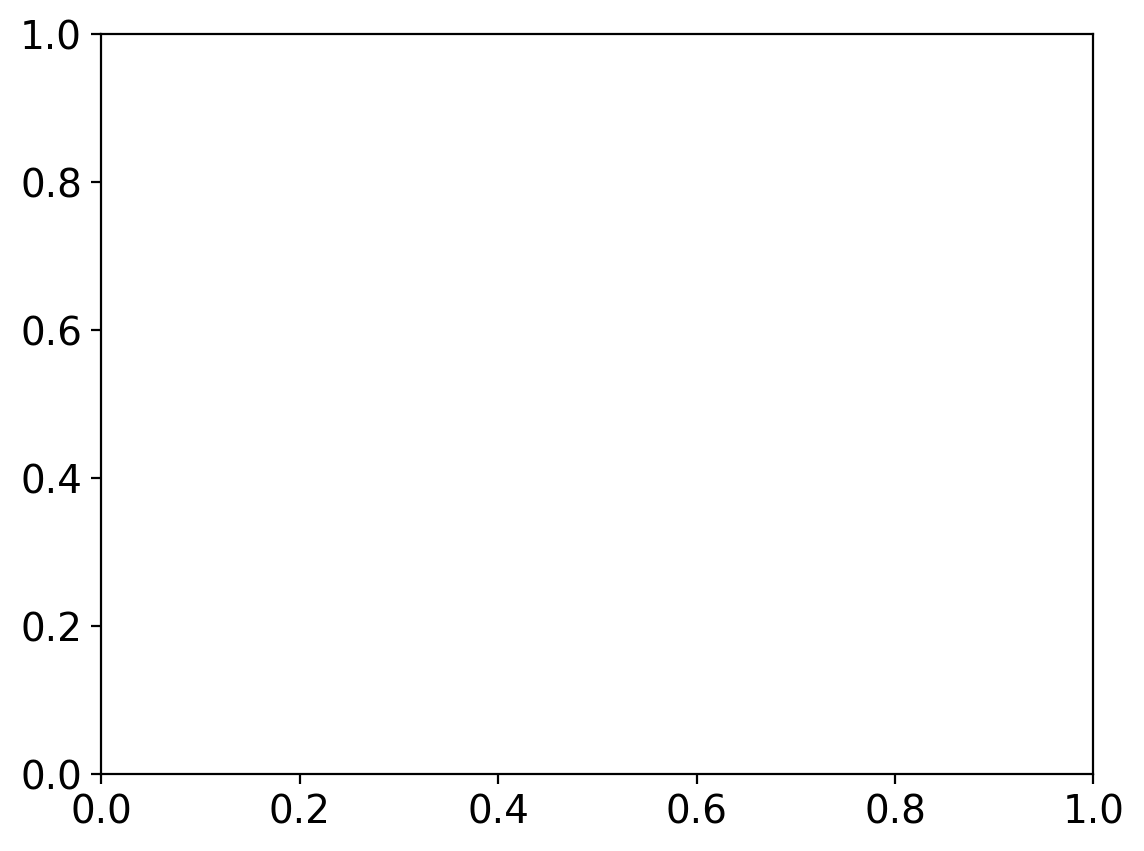

In [264]:
# sigma = 0

sigma = np.sqrt(ref_params.UNCORRELATED_NOISE_CHARGE**2 + ref_params.RESET_NOISE_CHARGE**2)

guess, no_hit_prob = get_noise_probability_correlated(q_sum, ref_params.RESET_NOISE_CHARGE)
# guess, no_hit_prob = get_noise_probability_correlated(q_sum, sigma)
guess2, no_hit_prob2 = get_noise_probability_correlated(q_sum, sigma)

average_guess = np.sum(guess/ (1-no_hit_prob[:, None])*np.arange(guess.shape[1]), axis=1) + 0.5# + no_hit_prob * (guess.shape[1] - 1)
first_ticks = ticks_filtered[:, :, 0]
average_measured = np.average(first_ticks, axis=0, weights=(first_ticks < 1998))
average_guess2 = np.sum(guess2/ (1-no_hit_prob2[:, None])*np.arange(guess2.shape[1]), axis=1) + 0.5# + no_hit_prob * (guess.shape[1] - 1)
# print(jnp.argsort(abs(average_guess - average_measured))[::-1])
plt.scatter(average_measured, average_guess, s=5)
plt.scatter(average_measured, average_guess2, s=5)
plt.plot([0, 1000], [0, 1000], color='r', linestyle='--')
plt.xlabel('Average measured tick number')
plt.ylabel('Average guess tick number')



plt.figure()
plt.hist(average_guess - average_measured, bins=100, range=(-1, 1), histtype='step', label='Average guess - measured');
plt.hist(average_guess2 - average_measured, bins=100, range=(-1, 1), histtype='step', label='Average guess2 - measured');
plt.xlabel('Average guess - measured tick number')
plt.ylabel('Counts')
print("Std of average guess - measured:", np.std(average_guess - average_measured))

plt.figure()
plt.scatter(q_sum[:,-1], average_guess - average_measured, s=5);
plt.scatter(q_sum[:,-1], average_guess2 - average_measured, s=5);
plt.axhline(0, color='k', linestyle='--')
plt.xscale('log')
# plt.yscale('symlog')
plt.xlabel('Last tick number')
plt.ylabel('Average guess - measured tick number')
plt.axvline(ref_params.DISCRIMINATION_THRESHOLD, color='k', linestyle='--', label='Discrimination threshold')

interval = round((3 * ref_params.CLOCK_CYCLE + ref_params.ADC_HOLD_DELAY * ref_params.CLOCK_CYCLE) / ref_params.t_sampling)

shifted_ticks = np.clip(np.arange(guess.shape[1]) + interval + 1, 0, q_sum.shape[1] - 1)
average_guess_adc = np.sum(guess*digitize(ref_params, q_sum[:, shifted_ticks]), axis=1) + no_hit_prob*74.3656
shifted_ticks = np.clip(np.arange(guess.shape[1]) + interval + 2, 0, q_sum.shape[1] - 1)
average_guess_adc = 0.5*(np.sum(guess*digitize(ref_params, q_sum[:, shifted_ticks]), axis=1) + no_hit_prob*74.3656 + average_guess_adc)

shifted_ticks2 = np.clip(np.arange(guess2.shape[1]) + interval + 1, 0, q_sum.shape[1] - 1)
average_guess_adc2 = np.sum(guess2*digitize(ref_params, q_sum[:, shifted_ticks2]), axis=1) + no_hit_prob2*74.3656
shifted_ticks2 = np.clip(np.arange(guess2.shape[1]) + interval + 2, 0, q_sum.shape[1] - 1)
average_guess_adc2 = 0.5*(np.sum(guess2*digitize(ref_params, q_sum[:, shifted_ticks2]), axis=1) + no_hit_prob2*74.3656 + average_guess_adc2)

first_adc = filtered[:, :, 0]
average_measured_adc = np.average(first_adc, axis=0, weights=(first_adc > 74.3567))

plt.figure()
plt.scatter(average_measured_adc, average_guess_adc, s=5)
plt.xlabel('Average measured ADC value')
plt.ylabel('Average guess ADC value')

print("Std of average guess - measured ADC:", np.std(average_guess_adc - average_measured_adc))

# average_guess_adc =  np.sum(guess * digitize(ref_params, q_sum[:, shifted_ticks]), axis=1)
# plt.scatter(average_measured_adc, average_guess_adc, s=1)

plt.plot([70, 110], [70, 110], color='k', linestyle='--')
plt.figure()
plt.hist(average_guess_adc - average_measured_adc, bins=100, range=(-3, 3), histtype='step', label='Average guess - measured');
plt.xlabel('Average guess - measured ADC value')
plt.ylabel('Counts')
print(np.argsort(np.abs(average_guess_adc - average_measured_adc))[::-1])
print(average_guess_adc[iplot], average_measured_adc[iplot])

plt.figure()
plt.scatter(average_measured_adc, average_guess_adc - average_measured_adc, s=5)
plt.scatter(average_measured_adc, average_guess_adc2 - average_measured_adc, s=5)

plt.xlabel('Average measured ADC value')
plt.ylabel('Average guess - measured ADC value')

plt.figure()
plt.scatter(np.mean((first_ticks == 1998), axis=0), no_hit_prob, s=5)
plt.scatter(np.mean((first_ticks == 1998), axis=0), no_hit_prob2, s=5)
plt.xlabel('Fraction of no-hit pixels')
plt.ylabel('No-hit probability')
plt.plot([0, 1], [0, 1], color='k', linestyle='--')
plt.xscale('log')
plt.yscale('log')
np.argsort(np.mean((first_ticks == 1998), axis=0))[::-1]

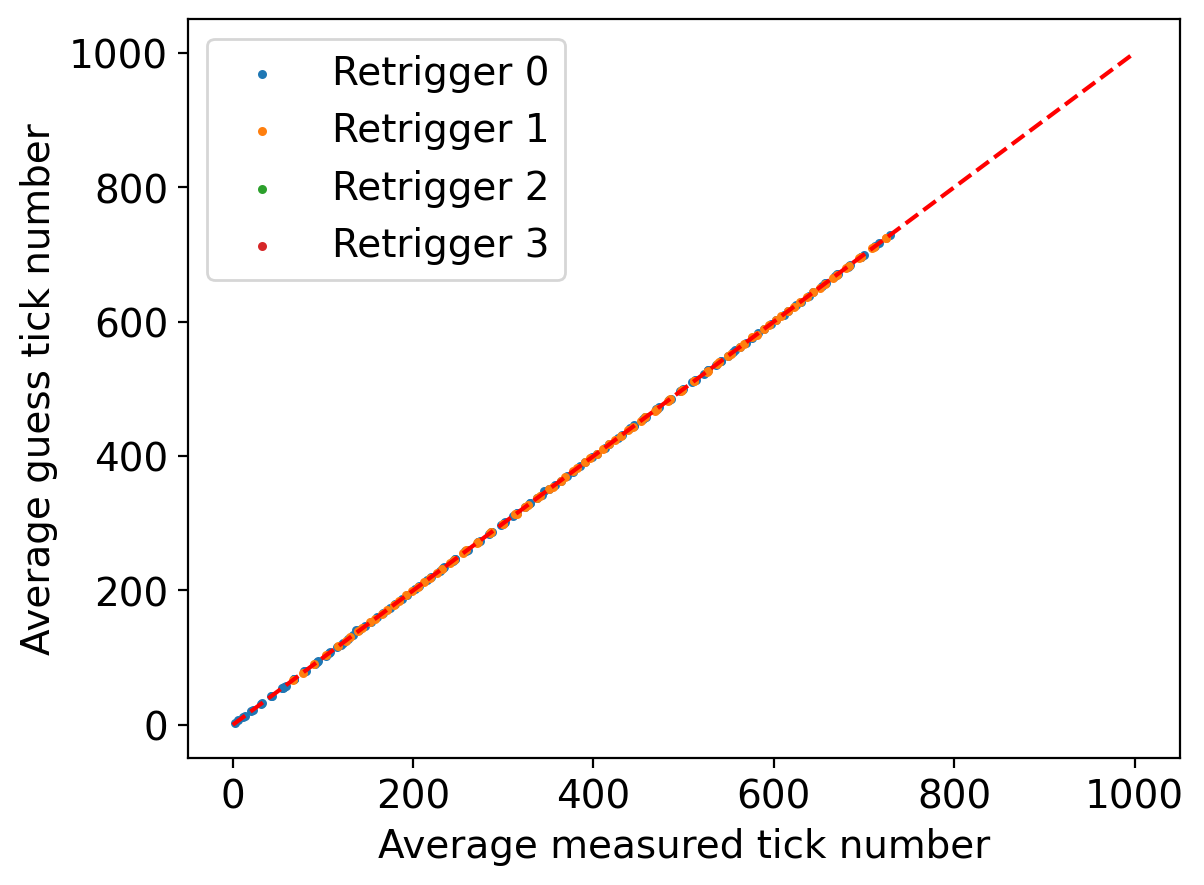

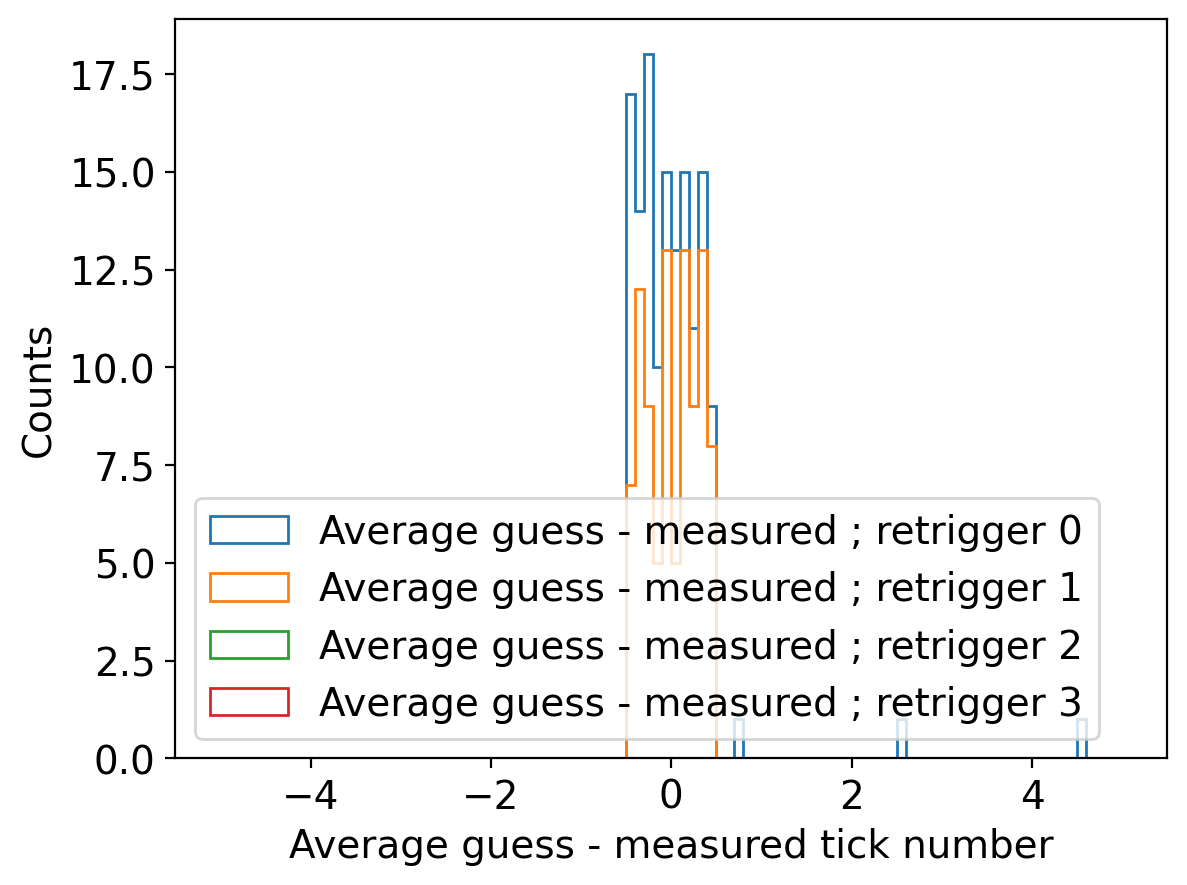

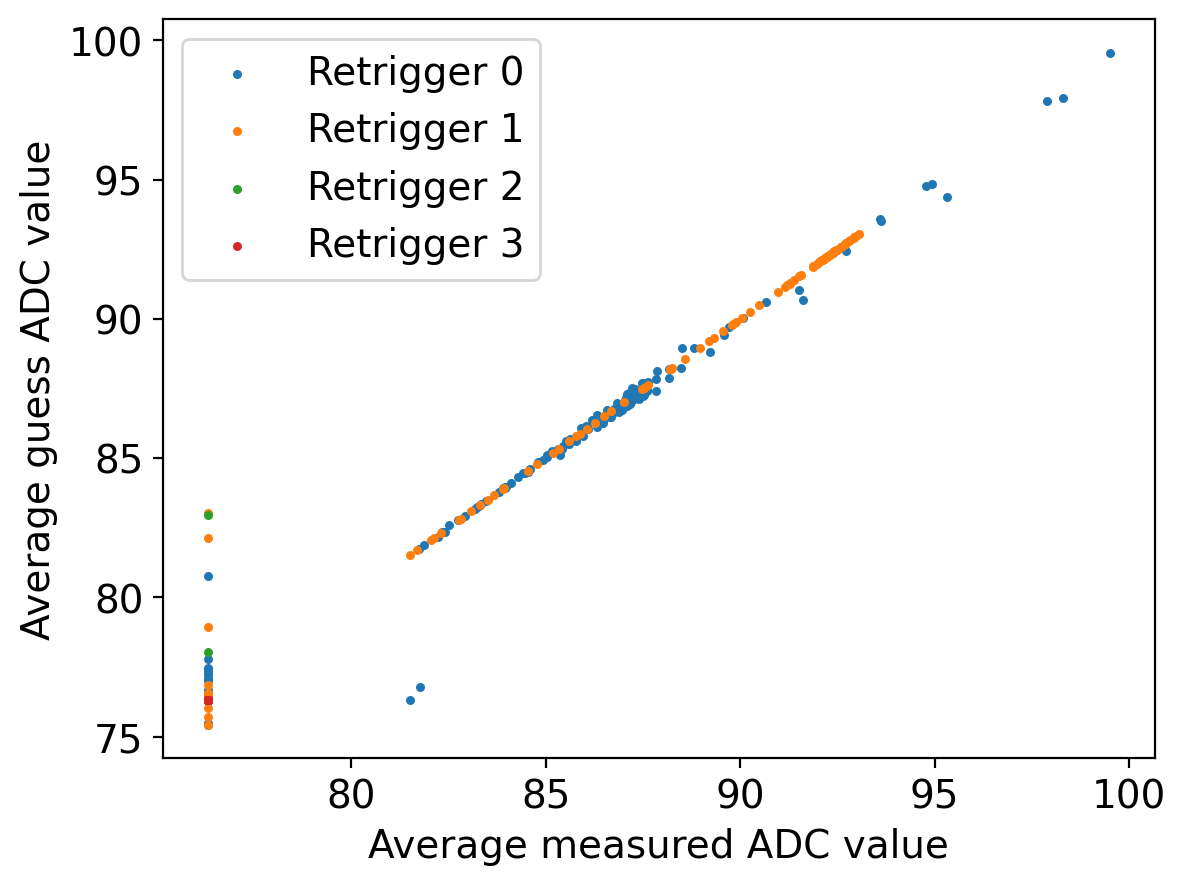

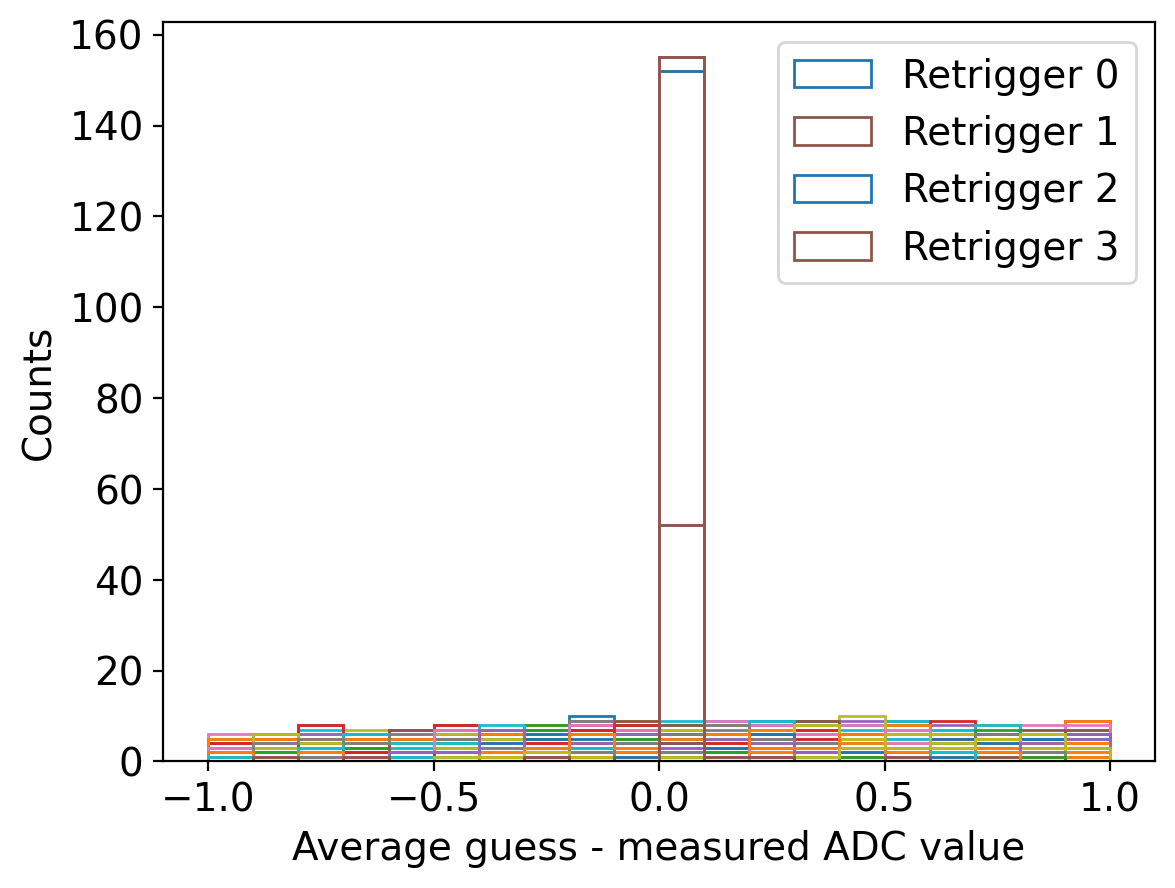

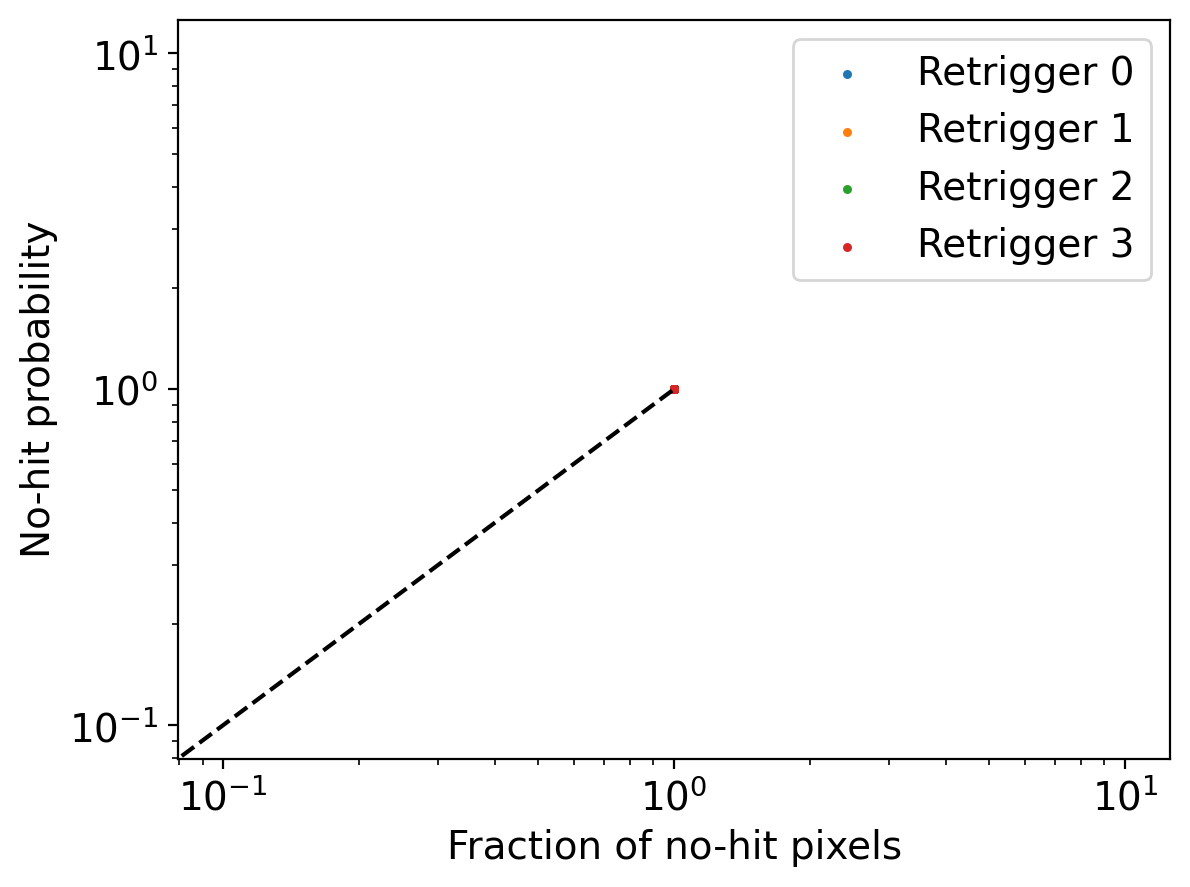

In [265]:
from jax.scipy.special import erf

@jit
def get_adc_values_average_noise(params, pixels_signals):
    q = pixels_signals*params.t_sampling
    q_sum = q.cumsum(axis=-1)  # Cumulative sum over time ticks


    def find_hit(q_sum_loc, it):
        sigma = params.RESET_NOISE_CHARGE #Found out that only considering the reset noise was sufficient
        guess = 0.5*(erf((q_sum_loc[:, 1:] - params.DISCRIMINATION_THRESHOLD)/(jnp.sqrt(2)*sigma)) - erf((q_sum_loc[:, :-1] - params.DISCRIMINATION_THRESHOLD)/(jnp.sqrt(2)*sigma)))
        norm = 0.5*(erf((q_sum_loc[:, -1] - params.DISCRIMINATION_THRESHOLD)/(jnp.sqrt(2)*sigma)) - erf((q_sum_loc[:, 1] - params.DISCRIMINATION_THRESHOLD)/(jnp.sqrt(2)*sigma)))
        no_hit_prob = 1 - norm

        interval = round((3 * params.CLOCK_CYCLE + params.ADC_HOLD_DELAY * params.CLOCK_CYCLE) / params.t_sampling)

        tick_avg  = jnp.sum(guess/ (1-no_hit_prob[:, None])*jnp.arange(guess.shape[1]), axis=1) + 0.5

        shifted_ticks = jnp.arange(guess.shape[1]) + interval + 1

        shifted_ticks = jnp.clip(shifted_ticks, 0, q_sum_loc.shape[1] - 1)
        shifted_ticks2 = jnp.clip(shifted_ticks + 1, 0, q_sum_loc.shape[1] - 1)

        charge_avg1 = jnp.sum(guess*(q_sum_loc[:, shifted_ticks]), axis=1)[:, jnp.newaxis]
        charge_avg2 = jnp.sum(guess*(q_sum_loc[:, shifted_ticks2]), axis=1)[:, jnp.newaxis]

        charge_avg = 0.5*(charge_avg1 + charge_avg2)
        # q_sum_new = q_sum_loc - charge_avg[:, jnp.newaxis]
        q_sum_new = q_sum_loc - charge_avg2

        return q_sum_new, (charge_avg, tick_avg, no_hit_prob)
    
    init_loop = q_sum
    _, (charge_avg, tick_avg, no_hit_prob) = lax.scan(find_hit, init_loop, jnp.arange(0, params.MAX_ADC_VALUES))

    return (charge_avg, tick_avg, no_hit_prob)



charge_avg, tick_avg, no_hit_prob = get_adc_values_average_noise(ref_params, wfs_filtered[:, 1:])
adc_avg = digitize(ref_params, charge_avg)


average_measured = jnp.sum(ticks_filtered*(ticks_filtered < 1998), axis=0)/jnp.sum(ticks_filtered < 1998, axis=0)

for i in range(4):
    plt.scatter(average_measured[:, i], tick_avg[i, :], s=5, label=f'Retrigger {i}')

plt.plot([0, 1000], [0, 1000], color='r', linestyle='--')
plt.xlabel('Average measured tick number')
plt.ylabel('Average guess tick number')
plt.legend()



plt.figure()
for i in range(4):
    plt.hist(tick_avg[i, :] - average_measured[:, i], bins=100, range=(-5, 5), histtype='step', label=f'Average guess - measured ; retrigger {i}');
plt.xlabel('Average guess - measured tick number')
plt.ylabel('Counts')
plt.legend()


average_measured_adc = np.average(filtered, axis=0, weights=(filtered > 74.3567))

plt.figure()
for i in range(4):
    plt.scatter(average_measured_adc[:, i], adc_avg[i, :], s=5, label=f'Retrigger {i}')
plt.xlabel('Average measured ADC value')
plt.ylabel('Average guess ADC value')
plt.legend()

plt.figure()
for i in range(4):
    plt.hist(adc_avg[i, :] - average_measured_adc[:, i], bins=20, range=(-1, 1), histtype='step', label=f'Retrigger {i}');
plt.xlabel('Average guess - measured ADC value')
plt.ylabel('Counts')
plt.legend()

# print("Std of average guess - measured ADC:", np.std(average_guess_adc - average_measured_adc))

# # average_guess_adc =  np.sum(guess * digitize(ref_params, q_sum[:, shifted_ticks]), axis=1)
# # plt.scatter(average_measured_adc, average_guess_adc, s=1)

# plt.plot([70, 110], [70, 110], color='k', linestyle='--')
# plt.figure()
# plt.hist(average_guess_adc - average_measured_adc, bins=100, range=(-3, 3), histtype='step', label='Average guess - measured');
# plt.xlabel('Average guess - measured ADC value')
# plt.ylabel('Counts')
# print(np.argsort(np.abs(average_guess_adc - average_measured_adc))[::-1])
# print(average_guess_adc[iplot], average_measured_adc[iplot])

# plt.figure()
# plt.scatter(average_measured_adc, average_guess_adc - average_measured_adc, s=5)
# plt.scatter(average_measured_adc, average_guess_adc2 - average_measured_adc, s=5)

# plt.xlabel('Average measured ADC value')
# plt.ylabel('Average guess - measured ADC value')

plt.figure()

measured_no_hit_prob = np.mean((ticks_filtered == 1998), axis=0)
for i in range(4):
    plt.scatter(measured_no_hit_prob[:, i], no_hit_prob[i, :], s=5, label=f'Retrigger {i}')
plt.xlabel('Fraction of no-hit pixels')
plt.ylabel('No-hit probability')
plt.plot([0, 1], [0, 1], color='k', linestyle='--')
plt.xscale('log')
plt.yscale('log')
plt.legend()


No hit probability for pixel 931 : [1.        1.        1.        ... 1.        1.        0.9996083]


Array(362.87668, dtype=float32)

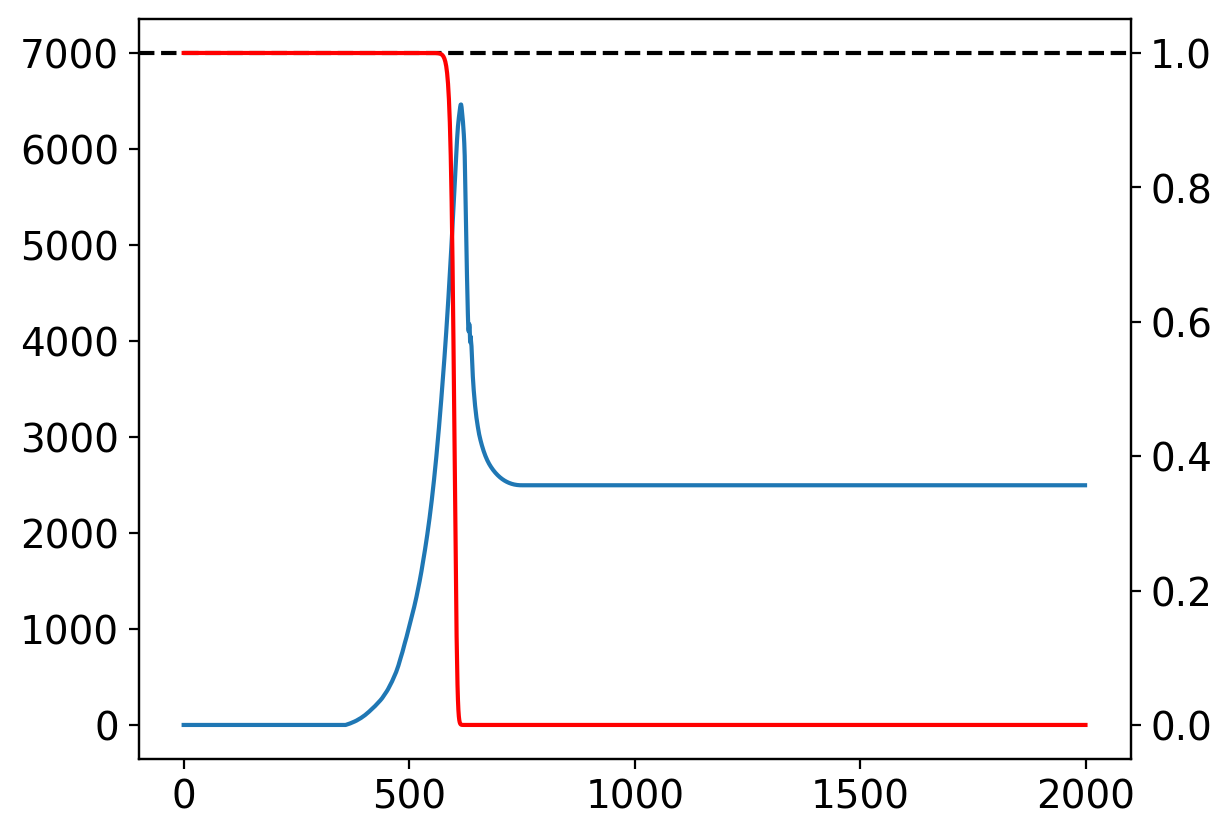

In [325]:

iplot = 931
print("No hit probability for pixel", iplot, ":", no_hit_prob[iplot])
noise_rng_key = jax.random.key(5)
plt.plot(q_sum[iplot, 1:])
plt.axhline(ref_params.DISCRIMINATION_THRESHOLD, color='k', linestyle='--')
ax2 = plt.gca().twinx()

lower_term = 0.5*(1 + erf((ref_params.DISCRIMINATION_THRESHOLD - q_sum)/(np.sqrt(2)*sigma)))
upper_term = 1-lower_term

prob = (1 - phi((ref_params.DISCRIMINATION_THRESHOLD - q_sum)/sigma))**2

guess = (upper_term[:, 1:]*lower_term[:, 1:])
# guess = 0.5*(erf((q_sum[:, 1:] - ref_params.DISCRIMINATION_THRESHOLD)/(np.sqrt(2)*sigma)) - erf((q_sum[:, :-1] - ref_params.DISCRIMINATION_THRESHOLD)/(np.sqrt(2)*sigma)))
# norm = 0.5*(erf((q_sum[:, -1] - ref_params.DISCRIMINATION_THRESHOLD)/(np.sqrt(2)*sigma)) - erf((q_sum[:, 1] - ref_params.DISCRIMINATION_THRESHOLD)/(np.sqrt(2)*sigma)))
# guess = guess / norm[:, None]

xmax = jnp.argmax(guess, axis=1)
xl = xmax - 10
xh = xmax + 10

# guess = 0.5*(erf((q_sum[:, 1:] - ref_params.DISCRIMINATION_THRESHOLD)/(np.sqrt(2)*sigma)) - erf((q_sum[:, :-1] - ref_params.DISCRIMINATION_THRESHOLD)/(np.sqrt(2)*sigma)))
# norm = 0.5*(erf((q_sum[:, -1] - ref_params.DISCRIMINATION_THRESHOLD)/(np.sqrt(2)*sigma)) - erf((q_sum[:, 1] - ref_params.DISCRIMINATION_THRESHOLD)/(np.sqrt(2)*sigma)))
# guess = guess / norm[:, None]

# ax2.plot(guess[iplot, :], color='red')
# ax2.plot(digitize(ref_params, q_sum[:, shifted_ticks])[iplot, :], color='red', label='Digitized ADC values')
ax2.plot(np.cumprod(prob[iplot, :]), color='red')
shifted_ticks = np.clip(np.arange(guess.shape[1]) + interval + 1, 0, q_sum.shape[1] - 1)
average_guess_adc = np.sum(guess*digitize(ref_params, q_sum[:, shifted_ticks]), axis=1)
average_guess_adc[iplot]
# plt.xlim(400, 700)

# plt.figure()
# plt.hist(filtered[:, iplot, 0], bins=np.arange(70, 100), density=True, histtype='step', label='Measured ADC distribution')
# plt.hist(digitize(ref_params, (guess * q_sum[iplot, shifted_ticks]).flatten()), bins=np.arange(70, 100), density=True, histtype='step', label='Predicted ADC distribution')




In [104]:
ref_params.RESET_NOISE_CHARGE

900

[74.36561584 74.36561584 74.36561584 74.36561584 74.36561584 74.36561584
 74.36561584 74.36561584 74.36561584 74.36561584 74.36561584 74.36561584
 74.36561584 74.36561584 74.36561584 74.36561584 74.36561584 74.36561584
 74.36561584 74.36561584 74.36561584 74.36561584 74.36561584 74.36561584
 74.36561584 74.36561584 74.36561584 74.36561584 74.36561584 74.36561584
 74.36561584 74.36561584 74.36561584 74.36561584 74.36561584 74.36561584
 74.36561584 74.36561584 74.36561584 74.36561584 74.36561584 74.36561584
 74.36561584 74.36561584 74.36561584 74.36561584 74.36561584 74.36561584
 74.36561584 74.36561584 74.36561584 74.36561584 74.36561584 74.36561584
 74.36561584 74.36561584 74.36561584 74.36561584 74.36561584 74.36561584
 74.36561584 74.36561584 74.36561584 74.36561584 74.36561584 74.36561584
 74.36561584 81.75991821 74.36561584 74.36561584 74.36561584 74.36561584
 74.36561584 74.36561584 74.36561584 74.36561584 74.36561584 74.36561584
 74.36561584 74.36561584 74.36561584 74.36561584 74

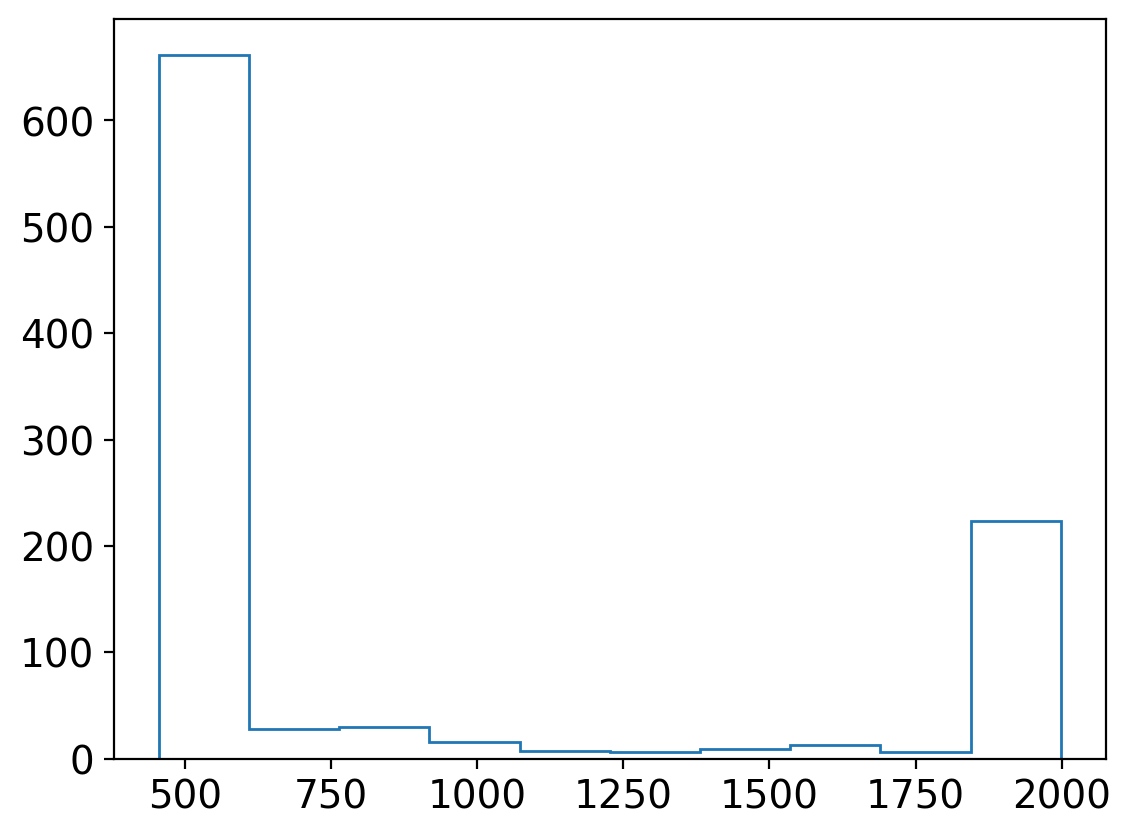

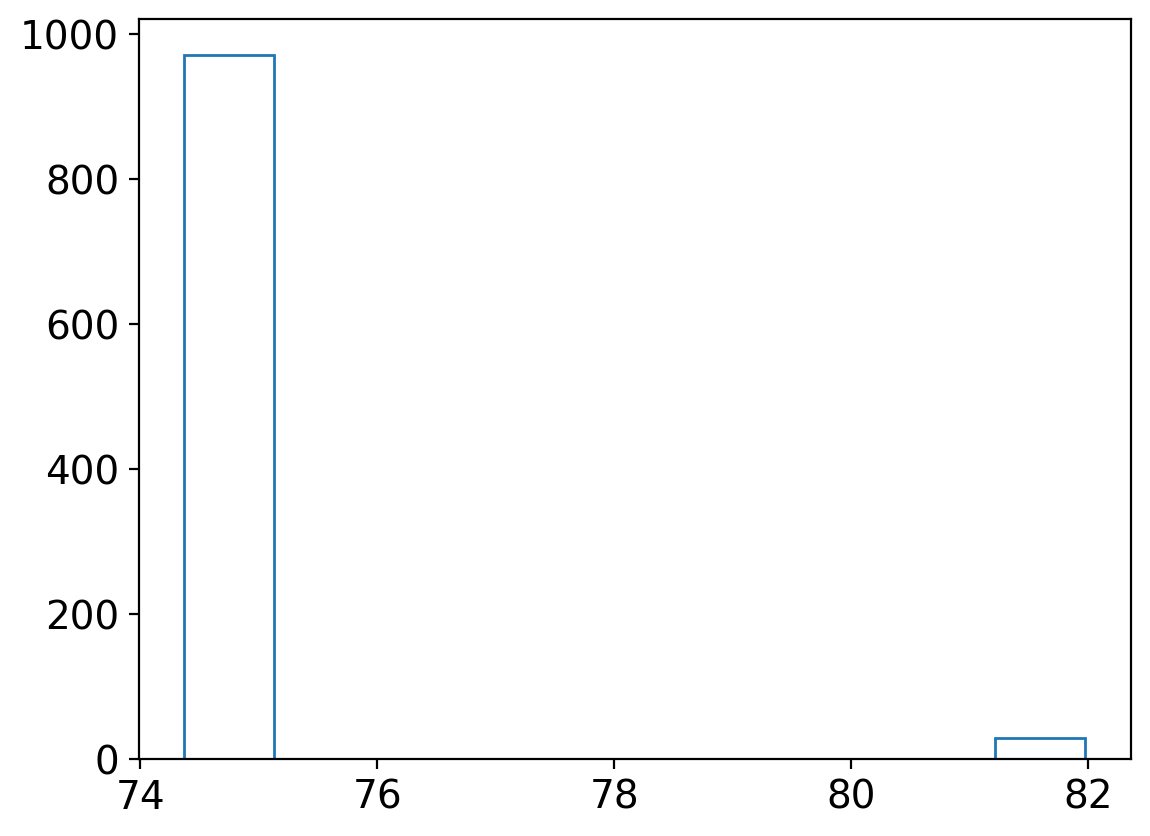

In [134]:
plt.hist(ticks_filtered[:, iplot, 0], histtype='step', label='Measured tick distribution')
plt.figure()
plt.hist(filtered[:, iplot, 0], histtype='step', label='Measured tick distribution')
print(filtered[:, iplot, 0])

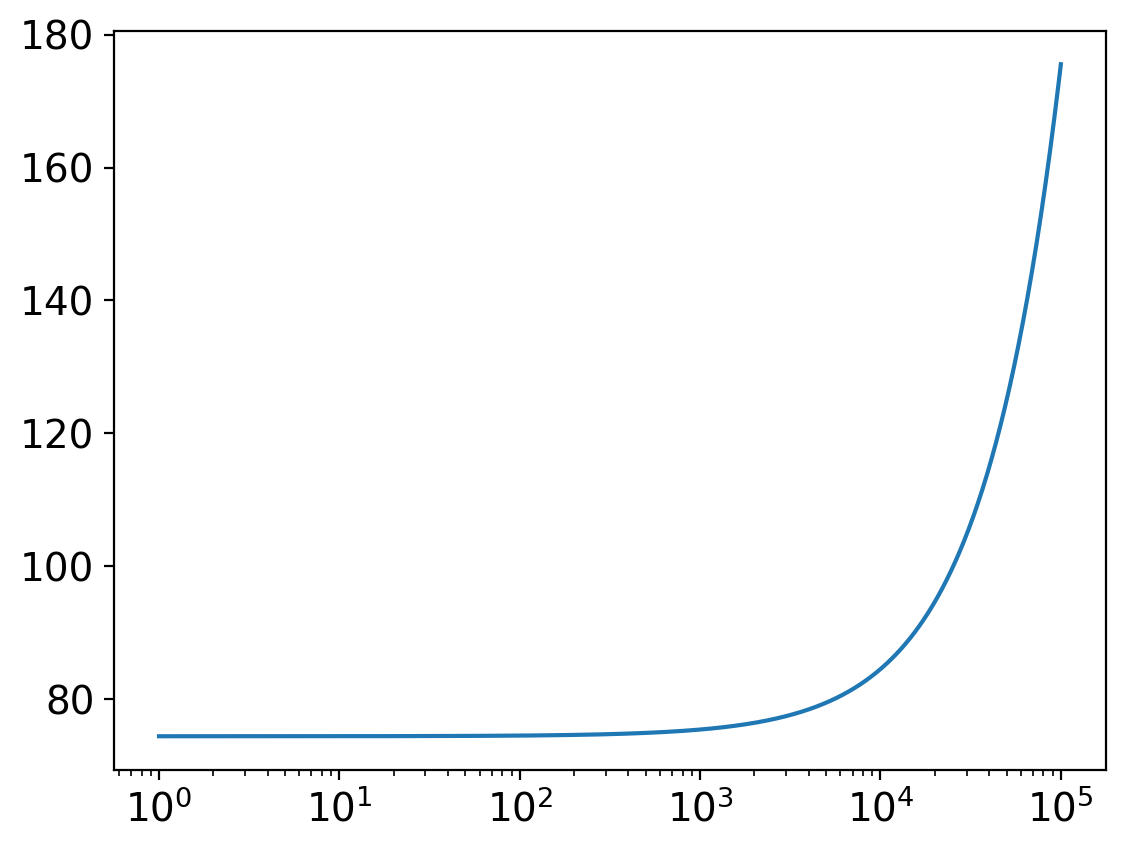

In [127]:
x = np.logspace(0, 5, 1000)
plt.figure()
plt.plot(x, digitize(ref_params, x), label='Digitized ADC values')
plt.xscale('log')

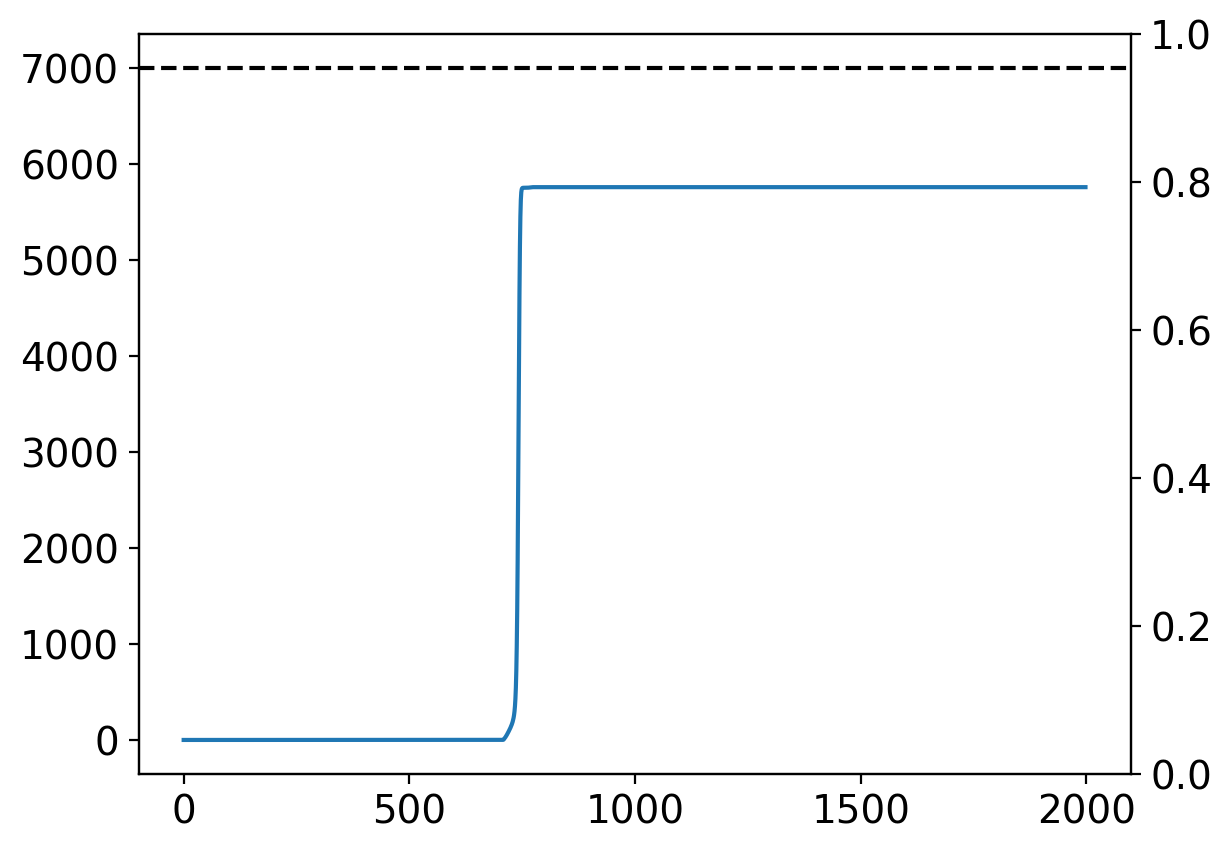

In [ ]:
plt.plot(q_sum[iplot, 1:])
plt.axhline(ref_params.DISCRIMINATION_THRESHOLD, color='k', linestyle='--')
ax2 = plt.gca().twinx()

guess = (upper_term[:, 1:]*lower_term[:, 1:])
# guess = 0.5*(erf((q_sum[:, 1:] - ref_params.DISCRIMINATION_THRESHOLD)/(np.sqrt(2)*sigma)) - erf((q_sum[:, :-1] - ref_params.DISCRIMINATION_THRESHOLD)/(np.sqrt(2)*sigma)))
# norm = 0.5*(erf((q_sum[:, -1] - ref_params.DISCRIMINATION_THRESHOLD)/(np.sqrt(2)*sigma)) - erf((q_sum[:, 1] - ref_params.DISCRIMINATION_THRESHOLD)/(np.sqrt(2)*sigma)))
# guess = guess / norm[:, None]

xmax = jnp.argmax(guess, axis=1)
xl = xmax - 10
xh = xmax + 10

# guess = 0.5*(erf((q_sum[:, 1:] - ref_params.DISCRIMINATION_THRESHOLD)/(np.sqrt(2)*sigma)) - erf((q_sum[:, :-1] - ref_params.DISCRIMINATION_THRESHOLD)/(np.sqrt(2)*sigma)))
# norm = 0.5*(erf((q_sum[:, -1] - ref_params.DISCRIMINATION_THRESHOLD)/(np.sqrt(2)*sigma)) - erf((q_sum[:, 1] - ref_params.DISCRIMINATION_THRESHOLD)/(np.sqrt(2)*sigma)))
# guess = guess / norm[:, None]

# ax2.plot(guess[iplot, :], color='red')
# plt.xlim(850, 1000)

# plt.figure()
# plt.hist(filtered[:, iplot, 0], bins=np.arange(70, 100), density=True, histtype='step', label='Measured ADC distribution')
# plt.hist(digitize(ref_params, (guess * q_sum[iplot, shifted_ticks]).flatten()), bins=np.arange(70, 100), density=True, histtype='step', label='Predicted ADC distribution')


In [85]:
digitize(ref_params, (guess * q_sum[iplot, shifted_ticks]).flatten()).max()

Array(78.26325, dtype=float32)

ValueError: Too many bins for data range. Cannot create 10 finite-sized bins.

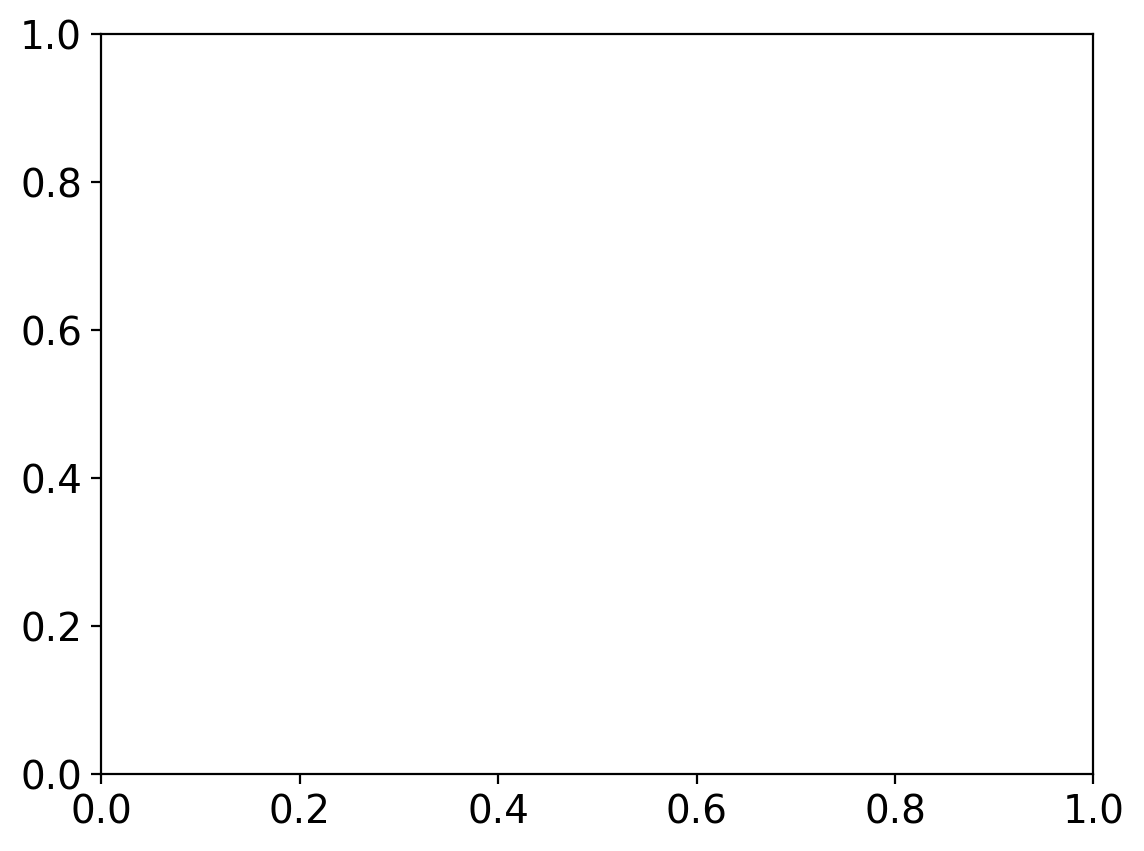

In [ ]:

# plt.hist(erf((q_sum[:, 1] - ref_params.DISCRIMINATION_THRESHOLD)/(np.sqrt(2)*sigma)), bins=20, histtype='step', label='Predicted')

# print(np.sum(guess, axis=1).shape, norm.shape)
plt.hist(np.sum(guess, axis=1)/norm, histtype='step', label='Predicted')
# plt.hist(norm, bins=20, histtype='step', label='Predicted')

In [129]:
np.sum(guess, axis=1)/norm

array([1.0000001 , 1.        , 1.        , 1.        , 1.        ,
       1.0000001 , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.0000001 , 1.        ,
       1.        , 0.99999994, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       0.99999994, 0.99999994, 1.        , 1.        , 1.        ,
       1.        , 1.        , 0.99999994, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.99999994, 1.        , 1.        , 1.        ,
       1.        , 1.        , 0.9999999 , 1.        , 1.        ,
       1.        , 1.        , 0.99999994, 1.        , 0.9999999 ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       0.99999994, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

In [49]:
sorted(guess[iplot], reverse=True)

[np.float64(0.0007856742013183861),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float6

In [1]:
q_sum = np.cumsum(wfs_filtered[:, 1:], axis=1)*ref_params.t_sampling
selec_func = lambda x: jnp.where((x[1:] >= ref_params.DISCRIMINATION_THRESHOLD) & 
            (x[:-1] <= ref_params.DISCRIMINATION_THRESHOLD), size=1, fill_value=q_sum.shape[1]-2)
idx_t, = jax.vmap(selec_func, 0, 0)(q_sum)
idx_t = idx_t.ravel()

# plt.scatter(idx_t, ticks_nonoise_filtered[:, 0])
plt.hist(idx_t - ticks_nonoise_filtered[:, 0], bins=np.linspace(-3, 3, 60));
# plt.plot(np.linspace(200, 1000, 100), np.linspace(200, 1000, 100), color='r')
# plt.ylim(200, 1200)

NameError: name 'np' is not defined

In [13]:
ticks_nonoise_filtered[:, 0]

Array([ 542.34796,  529.465  ,  517.7613 ,  455.84897,  323.84268,
        307.4467 ,  281.33017,  243.21832,  197.68945,  173.12006,
        160.15947,  116.57404,  864.79004,  874.3673 ,  884.63135,
        895.9629 ,  908.4097 ,  921.73914,  934.8167 ,  733.7697 ,
        732.57385,  742.73065,  754.22797,  769.7104 ,  778.4072 ,
        791.69464,  804.37555,  818.40875,  833.27936,  849.0465 ,
        602.36725,  612.2777 ,  623.0723 ,  635.01715,  648.05786,
        661.0774 ,  674.34955,  688.7229 ,  704.1078 ,  721.1015 ,
        566.68225,  608.47144,  626.24176,  627.8626 ,  638.35535,
        126.09506,  136.0873 ,  160.14565,  184.5785 ,  209.63347,
        226.72855,  231.7803 ,  252.41705,  272.62335,  293.77203,
        315.48242,  337.6772 ,  360.42606,  383.04453,  405.5378 ,
        428.55704,  452.05447,  476.09702,  500.6435 ,  525.3581 ,
        549.9999 ,  546.93164,  566.14777,  585.12274,  605.1518 ,
        625.95624,  647.4304 ,  669.1254 ,  690.5698 ,  712.83

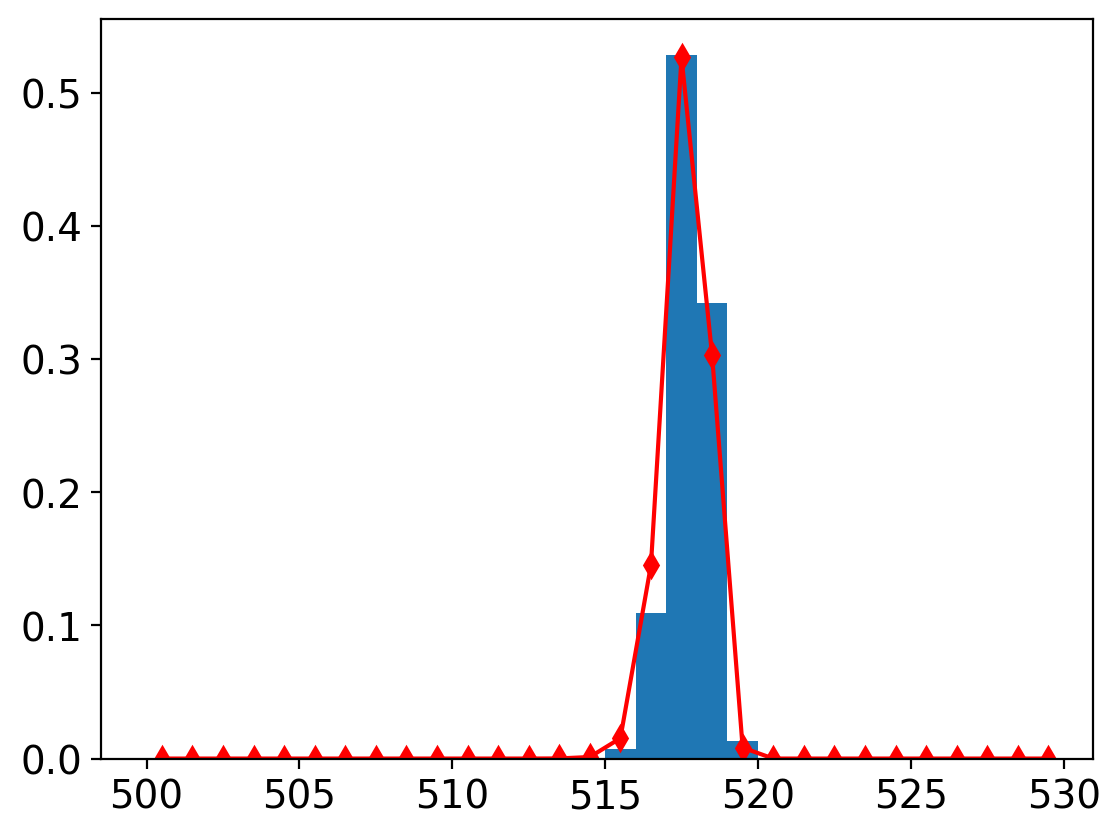

In [65]:
ticks_nonoise_filtered[1, :]

Array([ 529.465, 1998.   , 1998.   , 1998.   , 1998.   , 1998.   ,
       1998.   , 1998.   , 1998.   , 1998.   ], dtype=float32)

In [45]:
wfs_filtered.shape

(467, 2001)

In [29]:
(upper_term[1:]*lower_term[1:])[515:535]

array([1.96694003e-05, 6.69938517e-05, 2.13245500e-04, 6.45499104e-04,
       1.87754498e-03, 5.26121349e-03, 1.41246926e-02, 3.57345064e-02,
       8.24643731e-02, 1.63995430e-01, 2.55365212e-01, 2.65951593e-01,
       1.44659372e-01, 2.84452746e-02, 1.16450181e-03, 3.99391580e-06,
       2.45688801e-10, 2.19662940e-17, 0.00000000e+00, 0.00000000e+00])

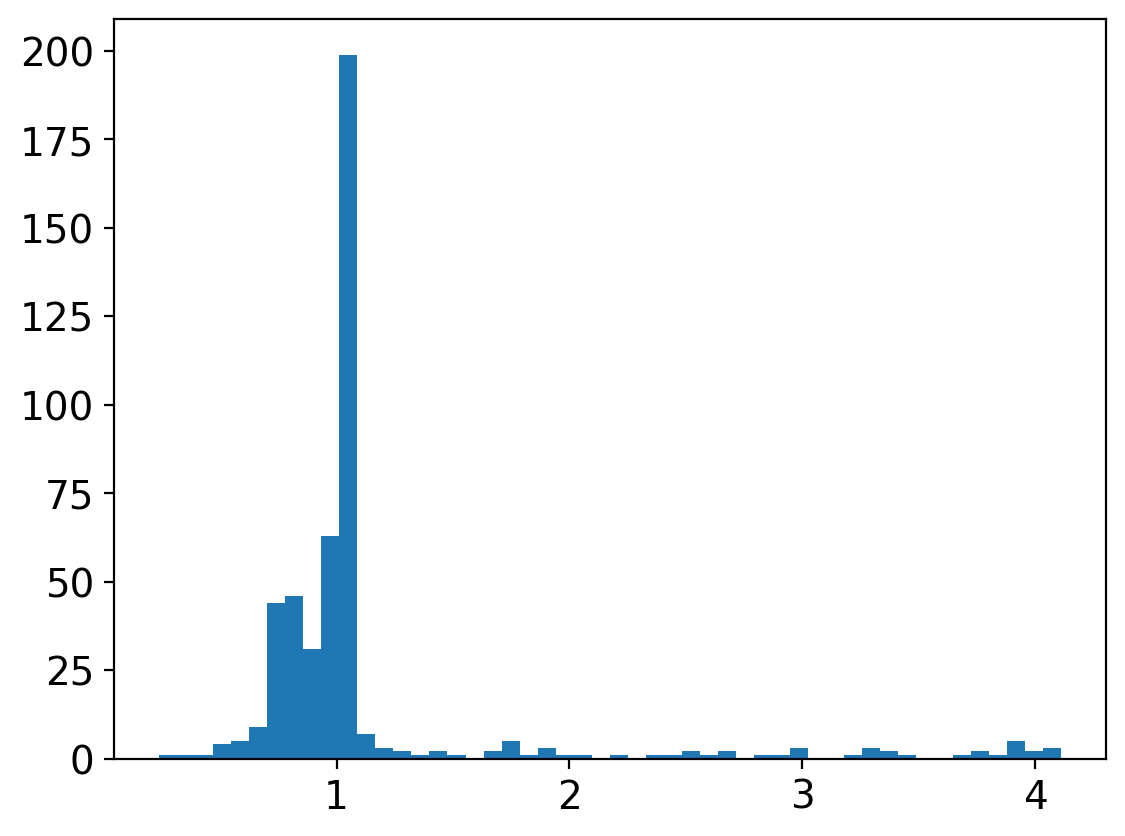

In [32]:
plt.hist(filtered[:, :, 0].std(axis=0), bins=50);

Text(0, 0.5, 'std')

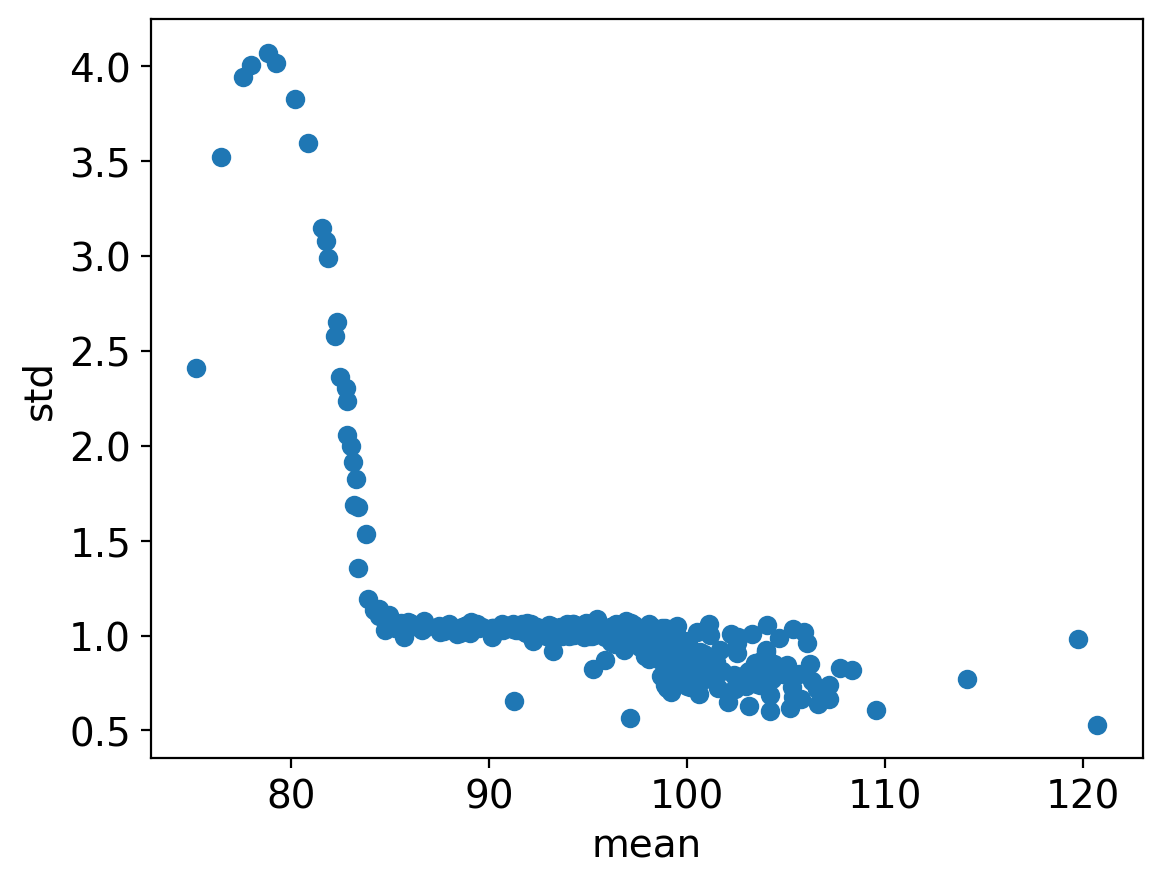

In [35]:
plt.scatter(filtered[:, :, 0].mean(axis=0), filtered[:, :, 0].std(axis=0))
plt.xlabel('mean')
plt.ylabel('std')